# KGBN manuscript

This notebook contains the code for the analysis of the KGBN manuscript.  
Note that this only includes the preprocessing and analysis of the data.  
The actual optimization is done in Hyak (the supercomputer at UW).  

# Import

In [ ]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import seaborn as sns
from matplotlib.colors import ListedColormap

sys.path.append('./src')
import BNMPy

network_file = '../input_files/Palma2021.txt' # contains the phenotype nodes
network_file_no_phenotype = '../input_files/Palma2021_no_phenotype.txt' # no phenotype nodes

drugs = [
"Venetoclax",
"Entospletinib",
"Ibrutinib",
"Trametinib",
"Selumetinib",
"Midostaurin",
]

drug2target = {
    'Venetoclax': ['BCL2'], 
    'Ibrutinib': ['BTK'], 
    'Entospletinib': ['SYK'],
    'Trametinib': ['MAP2K1','MAP2K2'],
    'Selumetinib': ['MAP2K1','MAP2K2'],
    'Midostaurin': ['FLT3','KIT'],
    }

# AUC by mutation profile with mean ± s.d. boxes (Train vs Test), with ANOVA p-values shown, and 'combined' mode option
from scipy.stats import f_oneway

def AUC_by_mutation_profile(df_plot, combined=False):
    def normalize_profile_text(p):
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\{\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return "+".join(genes) if genes else "None"

    # Merge cohort information
    df_plot = df_plot.copy()  # so we don't modify original
    df_plot["profile_label"] = df_plot["mutation_profile"].apply(normalize_profile_text)

    for drug in sorted(df_plot["inhibitor"].unique()):
        print(f"Drug:{drug}")
        sub = df_plot[df_plot["inhibitor"] == drug].copy()
        # Grouping function
        def get_profile_stats(data):
            return data.groupby("profile_label")['auc'].agg(['mean', 'std', 'count']).reset_index()

        all_profiles = sorted(df_plot["profile_label"].unique())

        if len(all_profiles) == 0:
            continue

        # Prepare ANOVA for each group
        def get_anova_p(data, labels=all_profiles):
            groups = [data[data['profile_label']==profile]['auc'].values for profile in labels]
            groups = [g for g in groups if len(g)>1]  # ANOVA requires n>1 per group
            if len(groups) <= 1:
                return None
            try:
                F, p = f_oneway(*groups)
                return p
            except Exception:
                return None

        if combined:
            stats = get_profile_stats(sub)
            pval = get_anova_p(sub)
            fig, ax = plt.subplots(1,1, figsize=(max(6, len(all_profiles) * 0.7), 6))
            positions = range(len(all_profiles))

            # Plot all data
            for i, profile in enumerate(all_profiles):
                profile_data = sub[sub['profile_label'] == profile]
                if len(profile_data) > 0:
                    x_jitter = np.random.normal(i, 0.08, len(profile_data))
                    ax.scatter(x_jitter, profile_data['auc'], alpha=0.5, s=25, color='steelblue')

            # Plot mean ± s.d. boxes
            for i, profile in enumerate(all_profiles):
                local_stats = stats[stats['profile_label'] == profile]
                if len(local_stats) > 0:
                    mean_val = local_stats['mean'].values[0]
                    std_val = local_stats['std'].values[0]
                    count = local_stats['count'].values[0]
                    box_width = 0.35
                    ax.add_patch(plt.Rectangle((i - box_width/2, mean_val - std_val),
                                                box_width, 2*std_val,
                                                facecolor='lightskyblue', alpha=0.4,
                                                linewidth=1.5, edgecolor='dodgerblue'))
                    ax.plot([i - box_width/2, i + box_width/2], [mean_val, mean_val],
                            color='darkblue', linewidth=2, zorder=10)
                    ax.text(i, mean_val - std_val - 3, f'n={int(count)}',
                            ha='center', va='top', fontsize=7)

            ax.set_xticks(positions)
            ax.set_xticklabels(all_profiles, rotation=45, ha='right', fontsize=8)
            ax.set_ylabel('AUC')
            ax.set_title(f'{drug} - Combined (All Cohorts)')
            ax.grid(axis='y', alpha=0.3)

            # Annotate ANOVA p-value
            if pval is not None:
                print(f'ANOVA p={pval:.2e}')
                ax.annotate(f'ANOVA p={pval:.2e}', xy=(1,1), xycoords='axes fraction',
                            xytext=(-10,-10), textcoords='offset points',
                            ha='right', va='top', fontsize=10, fontweight='bold',
                            bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="none", alpha=0.7))
            plt.tight_layout()
            plt.show()
        else:
            # Split by cohort
            train_data = sub[sub['cohort'] == 'Waves1+2'].copy()
            test_data = sub[sub['cohort'] == 'Waves3+4'].copy()

            train_stats = get_profile_stats(train_data)
            test_stats = get_profile_stats(test_data)
            positions = range(len(all_profiles))

            # ANOVA
            pval_train = get_anova_p(train_data)
            pval_test = get_anova_p(test_data)

            # Plot with 2 subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(6, len(all_profiles) * 0.7), 8))

            # Plot TRAIN
            for i, profile in enumerate(all_profiles):
                profile_data = train_data[train_data['profile_label'] == profile]
                if len(profile_data) > 0:
                    x_jitter = np.random.normal(i, 0.08, len(profile_data))
                    ax1.scatter(x_jitter, profile_data['auc'], alpha=0.5, s=25, color='steelblue')
            for i, profile in enumerate(all_profiles):
                stats = train_stats[train_stats['profile_label'] == profile]
                if len(stats) > 0:
                    mean_val = stats['mean'].values[0]
                    std_val = stats['std'].values[0]
                    count = stats['count'].values[0]
                    box_width = 0.35
                    ax1.add_patch(plt.Rectangle((i - box_width/2, mean_val - std_val),
                                                box_width, 2*std_val,
                                                facecolor='lightcoral', alpha=0.4,
                                                linewidth=1.5, edgecolor='coral'))
                    ax1.plot([i - box_width/2, i + box_width/2], [mean_val, mean_val],
                             color='darkred', linewidth=2, zorder=10)
                    ax1.text(i, mean_val - std_val - 3, f'n={int(count)}',
                             ha='center', va='top', fontsize=7)
            ax1.set_xticks(positions)
            ax1.set_xticklabels(all_profiles, rotation=45, ha='right', fontsize=8)
            ax1.set_ylabel('AUC')
            ax1.set_title(f'{drug} - TRAIN (Waves1+2)')
            ax1.grid(axis='y', alpha=0.3)
            # ANOVA p
            if pval_train is not None:
                ax1.annotate(f'ANOVA p={pval_train:.2e}', xy=(1,1), xycoords='axes fraction',
                             xytext=(-10,-10), textcoords='offset points',
                             ha='right', va='top', fontsize=10, fontweight='bold',
                             bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="none", alpha=0.7))

            # Plot TEST
            for i, profile in enumerate(all_profiles):
                profile_data = test_data[test_data['profile_label'] == profile]
                if len(profile_data) > 0:
                    x_jitter = np.random.normal(i, 0.08, len(profile_data))
                    ax2.scatter(x_jitter, profile_data['auc'], alpha=0.5, s=25, color='steelblue')
            for i, profile in enumerate(all_profiles):
                stats = test_stats[test_stats['profile_label'] == profile]
                if len(stats) > 0:
                    mean_val = stats['mean'].values[0]
                    std_val = stats['std'].values[0]
                    count = stats['count'].values[0]
                    box_width = 0.35
                    ax2.add_patch(plt.Rectangle((i - box_width/2, mean_val - std_val),
                                                box_width, 2*std_val,
                                                facecolor='lightskyblue', alpha=0.4,
                                                linewidth=1.5, edgecolor='dodgerblue'))
                    ax2.plot([i - box_width/2, i + box_width/2], [mean_val, mean_val],
                             color='darkblue', linewidth=2, zorder=10)
                    ax2.text(i, mean_val - std_val - 3, f'n={int(count)}',
                             ha='center', va='top', fontsize=7)
            ax2.set_xticks(positions)
            ax2.set_xticklabels(all_profiles, rotation=45, ha='right', fontsize=8)
            ax2.set_xlabel('Mutation Profile')
            ax2.set_ylabel('AUC')
            ax2.set_title(f'{drug} - TEST (Waves3+4)')
            ax2.grid(axis='y', alpha=0.3)
            # ANOVA p
            if pval_test is not None:
                ax2.annotate(f'ANOVA p={pval_test:.2e}', xy=(1,1), xycoords='axes fraction',
                             xytext=(-10,-10), textcoords='offset points',
                             ha='right', va='top', fontsize=10, fontweight='bold',
                             bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="none", alpha=0.7))
            plt.tight_layout()
            plt.show()

def create_experimental_data(df, cohort='Waves1+2',
                            mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'], 
                            inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
                            drug2target=None,
                            gene_to_class=None,
                            output_file='beataml_experiments.csv'):
    """
    Create experimental data CSV from BeatAML drug response data.
    
    Parameters:
    - df: DataFrame with mutation_profile, inhibitor, and auc columns
    - cohort: 'Waves1+2' or 'Waves3+4' or None
    - mutation_genes: List of genes
    - inhibitors: List of drug names
    - output_file: Output CSV filename
    
    Note: Oncogenes become Stimuli, TSGs become Inhibitors based on gene_to_class
    """
    
    # Drug to target mapping
    if drug2target is None:
        drug2target = {
            'Venetoclax': ['BCL2'], 
            'Ibrutinib': ['BTK'], 
            'Entospletinib': ['SYK'],
            'Trametinib': ['MAP2K1','MAP2K2'],
            'Selumetinib': ['MAP2K1','MAP2K2'],
            'Midostaurin': ['FLT3','KIT'],
            }
    if gene_to_class is None:
        # mutation class
        classification = pd.read_csv("../input_files/Palma_class.csv")
        gene_to_class = dict(zip(classification['symbol'], classification['class']))
    # Normalize profile text for comparison
    def normalize_profile_text(p):
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\\{\\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return set(genes) if genes else set()
    
    df_work = df.copy()
    if cohort:
        df_work = df_work[df_work['cohort'] == cohort]
    df_work['profile_set'] = df_work['mutation_profile'].apply(normalize_profile_text)
    
    # Generate all mutation profile combinations
    from itertools import combinations
    all_profiles = []
    for r in range(len(mutation_genes) + 1):
        for combo in combinations(mutation_genes, r):
            all_profiles.append(set(combo))
    
    print(f"\\nGenerating data for {len(all_profiles)} profiles × {len(inhibitors)} drugs = {len(all_profiles) * len(inhibitors)} experiments")
    
    # Create experiment rows
    experiments = []
    exp_id = 1
    
    for profile in all_profiles:
        for drug in inhibitors:
            # Filter data for this profile and drug
            matching_data = df_work[
                (df_work['profile_set'] == profile) & 
                (df_work['inhibitor'].str.contains(drug, case=False, na=False))
            ]
            
            if len(matching_data) == 0:
                continue
            
            # Calculate average AUC
            avg_auc = matching_data['auc'].mean()
            std_auc = matching_data['auc'].std()
            n_patients = len(matching_data)
            
            # Classify genes as oncogenes or TSGs
            oncogenes = []
            tsgs = []
            
            for gene in profile:
                if gene == 'FLT3_ITD':
                    gene = 'FLT3'
                gene_class = gene_to_class.get(gene, 'unknown')
                if gene_class == 'oncogene':
                    oncogenes.append(gene)
                elif gene_class == 'TSG':
                    tsgs.append(gene)
                else:
                    print(f"Warning: Unknown classification for {gene}, treating as oncogene")
                    oncogenes.append(gene)
            
            # Oncogenes → Stimuli (activate)
            stimuli = ','.join(sorted(oncogenes)) if oncogenes else ''
            stimuli_efficacy = ','.join(['1'] * len(oncogenes)) if oncogenes else ''
            
            # TSGs + Drug target → Inhibitors (knockdown)
            target = drug2target.get(drug, '')
            if not target:
                print(f"Warning: No target mapping for {drug}, skipping...")
                continue
            
            all_inhibitors = sorted(tsgs + target)
            inhibitors_str = ','.join(all_inhibitors)
            inhibitors_efficacy = ','.join(['1'] * len(all_inhibitors))
            
            measured_nodes = 'AUC'
            measured_values = f'{avg_auc:.2f}'
            
            experiments.append({
                'Experiments': exp_id,
                'Stimuli': stimuli,
                'Stimuli_efficacy': stimuli_efficacy,
                'Inhibitors': inhibitors_str,
                'Inhibitors_efficacy': inhibitors_efficacy,
                'Measured_nodes': measured_nodes,
                'Measured_values': measured_values,
                'n_patients': n_patients,
                'std': f'{std_auc:.2f}',
                'drug': drug
            })
            
            exp_id += 1
    
    # Create DataFrame
    exp_df = pd.DataFrame(experiments)
    
    # Save to CSV
    exp_df.to_csv(output_file, index=False)
    
    print(f"\\nSaved {len(exp_df)} experiments to {output_file}")
    print(f"\\nSummary by drug:")
    print(exp_df.groupby('drug').agg({
        'n_patients': 'sum',
        'Measured_values': lambda x: f"{pd.to_numeric(x).mean():.2f}±{pd.to_numeric(x).std():.2f}"
    }).rename(columns={'Measured_values': 'Mean AUC±SD', 'n_patients': 'Total patients'}))
    
    return exp_df

# BeatAML data

This follows the exact approach from the BeatAML2 manuscript   
(see https://github.com/biodev/beataml2_manuscript/blob/main/R/preprocess.R, function `mutation.only.dataset()`):

1. Filter clinical data: Only samples with `manuscript_dnaseq == 'yes'`
2. Create binary mutation matrix: Rows = patients (ptid), Columns = genes, Values = 1 (mutation present) or 0 (absent)
3. Add consensus annotations: Override with manual annotations from clinical file for:
   - NPM1 (from NPM1 column: positive = 1)
   - FLT3_ITD (from FLT3-ITD column: positive = 1)
   - RUNX1 (from RUNX1 column: not NA = 1)
   - ASXL1 (from ASXL1 column: not NA = 1)
   - TP53 (from TP53 column: not NA = 1)

In [534]:
# BeatAML data
drug_response = pd.read_csv("https://media.githubusercontent.com/media/biodev/beataml2.0_data/main/beataml_probit_curve_fits_v4_dbgap.txt", sep='\t')
mutations = pd.read_csv("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx")

# Filter clinical data to those with DNA sequencing
dna_clin = clinical[clinical['manuscript_dnaseq'] == 'yes'].copy()

# Merge with clinical data 
dna_clin['ptid'] = 'pt' + dna_clin['dbgap_subject_id'].astype(str)
muts_merged = pd.merge(
    dna_clin[['ptid', 'dbgap_dnaseq_sample', 'cohort', 'NPM1', 'FLT3-ITD', 'RUNX1', 'ASXL1', 'TP53']],
    mutations,
    left_on='dbgap_dnaseq_sample',
    right_on='dbgap_sample_id',
    how='inner'
)
# Create binary mutation matrix (patient x gene): if a patient has any mutation in a gene, mark as 1
muts_merged['value'] = 1
mutation_matrix = muts_merged.pivot_table(
    index='ptid',
    columns='symbol',
    values='value',
    aggfunc='max',  # If multiple mutations in same gene, still just 1
    fill_value=0
)
# Add manual annotations from clinical data (NPM1, FLT3-ITD, RUNX1, ASXL1, TP53)
manual_muts = dna_clin.set_index('ptid')[['NPM1', 'FLT3-ITD', 'RUNX1', 'ASXL1', 'TP53']].copy()
manual_muts['NPM1'] = (manual_muts['NPM1'] == 'positive').astype(int)
manual_muts['FLT3_ITD'] = (manual_muts['FLT3-ITD'] == 'positive').astype(int)
manual_muts['RUNX1'] = manual_muts['RUNX1'].notna().astype(int)
manual_muts['ASXL1'] = manual_muts['ASXL1'].notna().astype(int)
manual_muts['TP53'] = manual_muts['TP53'].notna().astype(int)
manual_muts = manual_muts[['NPM1', 'FLT3_ITD', 'RUNX1', 'ASXL1', 'TP53']]

# some patients in clinical file don't have WES mutations
missing_patients = list(set(manual_muts.index) - set(mutation_matrix.index))
if missing_patients:
    missing_df = pd.DataFrame(0, index=missing_patients, columns=mutation_matrix.columns)
    mutation_matrix = pd.concat([mutation_matrix, missing_df])

# Add missing gene columns if needed
for gene in ['FLT3', 'FLT3_ITD', 'NPM1', 'RUNX1', 'ASXL1', 'TP53']:
    if gene not in mutation_matrix.columns:
        mutation_matrix[gene] = 0

# Override with consensus annotations for NPM1, RUNX1, ASXL1, TP53
# For FLT3_ITD: update the FLT3_ITD column with clinical consensus
common_patients = list(set(manual_muts.index) & set(mutation_matrix.index))
for gene in ['NPM1', 'FLT3_ITD', 'RUNX1', 'ASXL1', 'TP53']:
    mutation_matrix.loc[common_patients, gene] = manual_muts.loc[common_patients, gene]

# Keep any patient with FLT3 from WES OR FLT3_ITD from clinical
mutation_matrix['FLT3_combined'] = ((mutation_matrix['FLT3'] == 1) | (mutation_matrix['FLT3_ITD'] == 1)).astype(int)

print(f"Mutation matrix shape: {mutation_matrix.shape}")

# mutation frequencies as percentages
mut_freq = mutation_matrix.sum().sort_values(ascending=False)
mut_pct = (mut_freq / len(mutation_matrix) * 100).round(1)
print(f"\nTop 20 most frequent mutations:")
for gene, pct in mut_pct.head(20).items():
    print(f"  {gene}: {pct}%")

# dbgap_sample_id -> ptid -> mutation profile
sample_to_ptid = dna_clin[['dbgap_dnaseq_sample', 'ptid', 'dbgap_subject_id', 'cohort']].copy()
sample_to_ptid.rename(columns={'dbgap_dnaseq_sample': 'dbgap_sample_id'}, inplace=True)

Mutation matrix shape: (713, 2989)

Top 20 most frequent mutations:
  FLT3_combined: 29.7%
  NPM1: 25.8%
  FLT3_ITD: 22.4%
  DNMT3A: 21.6%
  NRAS: 14.3%
  TET2: 13.7%
  RUNX1: 13.5%
  IDH2: 13.3%
  SRSF2: 12.2%
  ASXL1: 10.8%
  TP53: 10.7%
  FLT3: 9.0%
  STAG2: 7.9%
  IDH1: 7.6%
  WT1: 7.3%
  BCOR: 5.9%
  CEBPA: 5.8%
  U2AF1: 5.3%
  KRAS: 5.0%
  PTPN11: 4.9%


In [535]:
# Create dataset with drug response and mutations
sample_mutations = {}
for ptid in mutation_matrix.index:
    mutated_genes = mutation_matrix.loc[ptid][mutation_matrix.loc[ptid] == 1].index.tolist()
    # Filter to only model genes
    # mutated_genes_in_model = [g for g in mutated_genes if g in pbn.nodeDict.keys()]
    mutated_genes_in_model = [g for g in mutated_genes if g in ['FLT3_ITD', 'NPM1', 'DNMT3A']]
    sample_mutations[ptid] = set(mutated_genes_in_model)

# Create mutation profile mapping
mutation_profiles = []
for _, row in sample_to_ptid.iterrows():
    ptid = row['ptid']
    if ptid in sample_mutations:
        mutation_profiles.append({
            'dbgap_sample_id': row['dbgap_sample_id'],
            'ptid': ptid,
            'mutation_profile': sample_mutations[ptid]
        })

mutation_profile_df = pd.DataFrame(mutation_profiles)

# Merge with drug response data
drug_response_merged = pd.merge(
    mutation_profile_df,
    drug_response,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample',
    how='inner'
)

# Filter for selected drugs of interest
df = drug_response_merged[drug_response_merged['inhibitor'].apply(lambda x: any(drug in x for drug in drugs))].copy()

# Merge cohort information
df = pd.merge(df, sample_to_ptid[['dbgap_sample_id', 'cohort']], on='dbgap_sample_id', how='left')

print(f"dataset: {len(df)} records")
print(f"Drugs: {sorted(df['inhibitor'].unique())}")

dataset: 2383 records
Drugs: ['Entospletinib (GS-9973)', 'Ibrutinib (PCI-32765)', 'Midostaurin', 'Selumetinib (AZD6244)', 'Trametinib (GSK1120212)', 'Venetoclax']


In [489]:
df

dbgap_sample_id    ptid mutation_profile  dbgap_subject_id  \
0            BA3039D  pt2207               {}              2207   
1            BA3172D  pt2751               {}              2751   
2            BA3172D  pt2751               {}              2751   
3            BA3172D  pt2751               {}              2751   
4            BA3172D  pt2751               {}              2751   
...              ...     ...              ...               ...   
2378         BA3100D  pt2750   {NPM1, DNMT3A}              2750   
2379         BA3100D  pt2750   {NPM1, DNMT3A}              2750   
2380         BA3100D  pt2750   {NPM1, DNMT3A}              2750   
2381         BA3100D  pt2750   {NPM1, DNMT3A}              2750   
2382         BA3100D  pt2750   {NPM1, DNMT3A}              2750   

     dbgap_dnaseq_sample dbgap_rnaseq_sample                inhibitor  \
0                BA3039D                 NaN    Ibrutinib (PCI-32765)   
1                BA3172D                 NaN    Ibrutinib (PCI-32765)   
2                BA3172D                 NaN              Midostaurin   
3                BA3172D                 NaN    Selumetinib (AZD6244)   
4                BA3172D                 NaN  Trametinib (GSK1120212)   
...                  ...                 ...                      ...   
2378             BA3100D                 NaN    Ibrutinib (PCI-32765)   
2379             BA3100D                 NaN              Midostaurin   
2380             BA3100D                 NaN    Selumetinib (AZD6244)   
2381             BA3100D                 NaN  Trametinib (GSK1120212)   
2382             BA3100D                 NaN               Venetoclax   

              type      status  paper_inclusion  ...       ic10       ic25  \
0     single-agent  train/test             True  ...  10.000000  10.000000   
1     single-agent  train/test             True  ...   4.007967  10.000000   
2     single-agent  train/test             True  ...   0.013700   0.061417   
3     single-agent  train/test             True  ...   0.013700   0.371165   
4     single-agent  train/test             True  ...   0.013700   0.013700   
...            ...         ...              ...  ...        ...        ...   
2378  single-agent  train/test             True  ...   0.013700   0.917243   
2379  single-agent  train/test             True  ...   0.035519  10.000000   
2380  single-agent  train/test             True  ...  10.000000  10.000000   
2381  single-agent  train/test             True  ...   4.394901   3.974823   
2382  single-agent    combined             True  ...   0.013700   0.013700   

           ic50       ic75       ic90         auc  all_gt_50  all_lt_50  \
0     10.000000  10.000000  10.000000  275.085653       True      False   
1     10.000000  10.000000  10.000000  275.704046       True      False   
2      1.051243  10.000000  10.000000  168.625182      False      False   
3     10.000000  10.000000  10.000000  212.700908       True      False   
4      0.557860  10.000000  10.000000  147.067312      False      False   
...         ...        ...        ...         ...        ...        ...   
2378  10.000000  10.000000  10.000000  218.715266       True      False   
2379  10.000000  10.000000  10.000000  271.662263       True      False   
2380  10.000000  10.000000  10.000000  284.545522       True      False   
2381   3.555000   3.179523   2.875606   44.916043      False      False   
2382   0.013700   0.108646   1.364257   54.410634      False       True   

      curve_type    cohort  
0     increasing  Waves1+2  
1     decreasing  Waves3+4  
2     decreasing  Waves3+4  
3     decreasing  Waves3+4  
4     decreasing  Waves3+4  
...          ...       ...  
2378  decreasing  Waves3+4  
2379  increasing  Waves3+4  
2380  decreasing  Waves3+4  
2381  increasing  Waves3+4  
2382  decreasing  Waves3+4  

[2383 rows x 30 columns]

# Mutation profile vs AUC

Drug:Entospletinib (GS-9973)


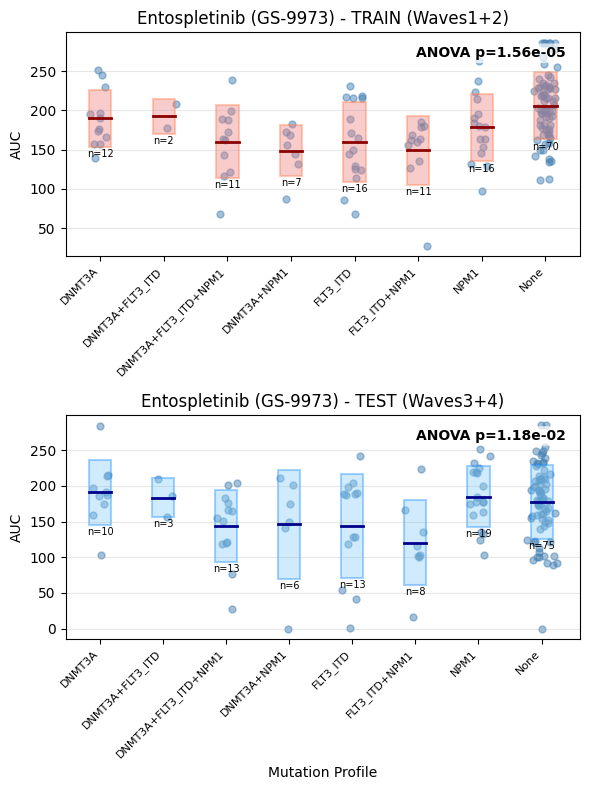

Drug:Ibrutinib (PCI-32765)


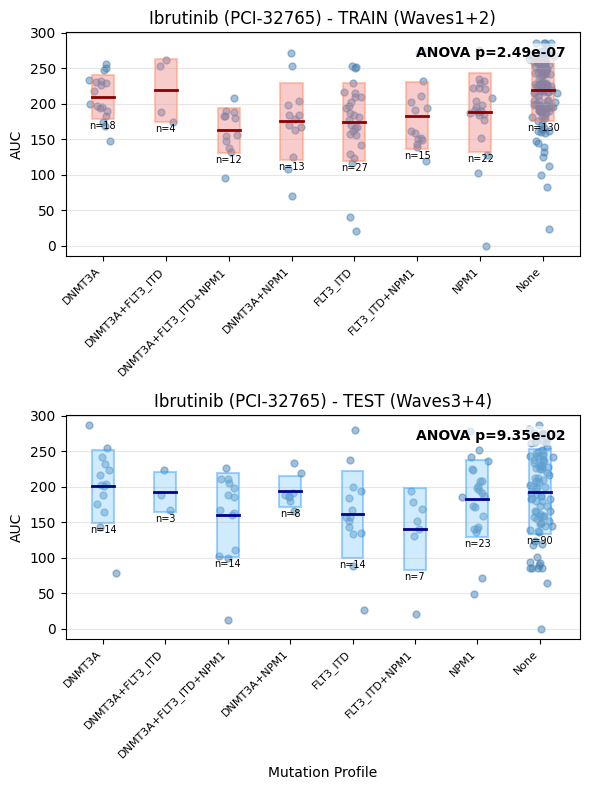

Drug:Midostaurin


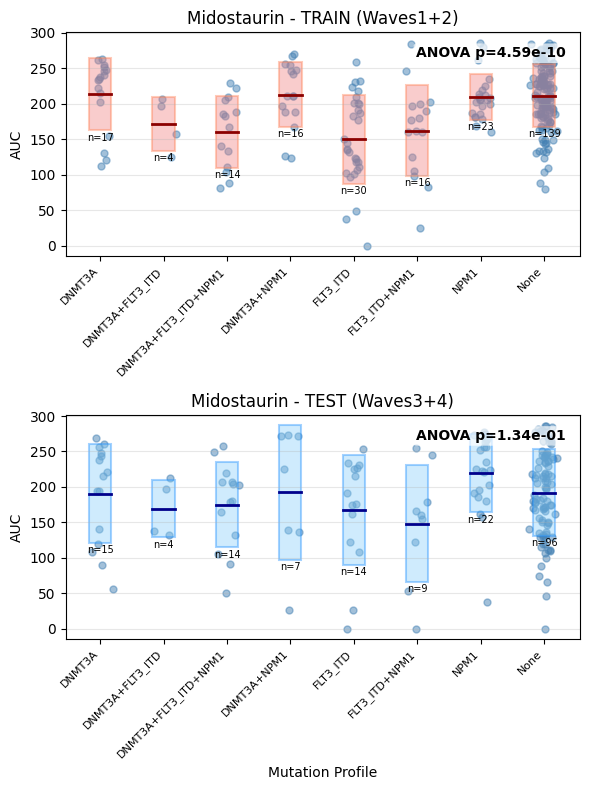

Drug:Selumetinib (AZD6244)


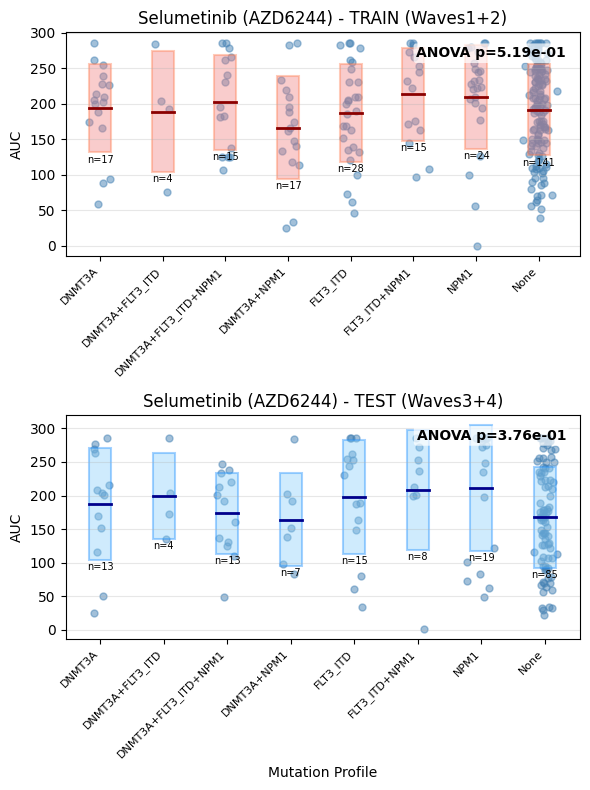

Drug:Trametinib (GSK1120212)


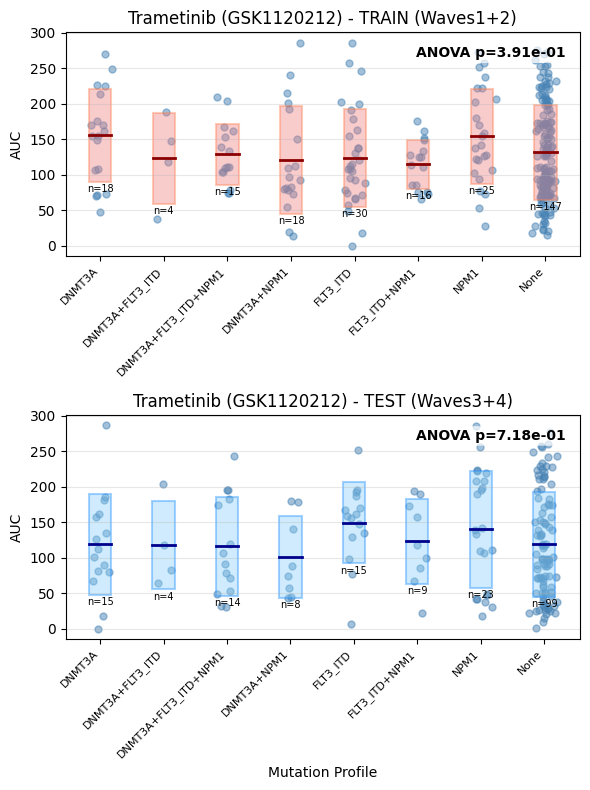

Drug:Venetoclax


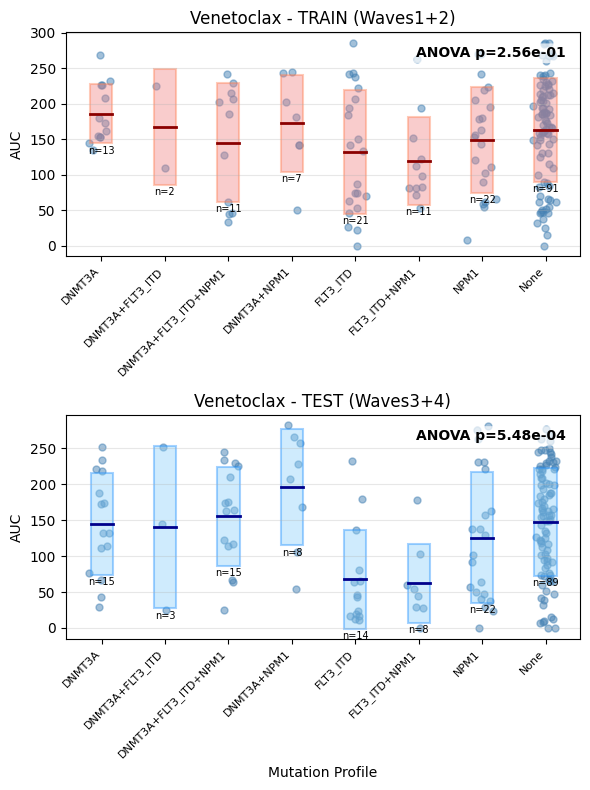

In [538]:
# AUC by mutation profile with mean ± s.d. boxes (Train vs Test)
AUC_by_mutation_profile(df, combined=False)

# Run Optimization
## Create exp data

The 8 mutation profiles (FLT3-ITD, NPM1, DNMT3A and their combinations) for 3 drugs: Venetoclax, Ibrutinib, Entospletinib.

In [41]:
# mutation class
classification = pd.read_csv("../input_files/Palma_class.csv")
gene_to_class = dict(zip(classification['symbol'], classification['class']))
gene_to_class

{'AKT1': 'oncogene',
 'BCL2': 'oncogene',
 'CCND1': 'oncogene',
 'CDKN2A': 'TSG',
 'CEBPA': 'TSG',
 'DNMT3A': 'TSG',
 'ETV6': 'TSG',
 'FBXW7': 'TSG',
 'FLT3': 'oncogene',
 'GSK3B': 'oncogene',
 'HOXA9': 'oncogene',
 'MAPK1': 'oncogene',
 'MEIS1': 'oncogene',
 'MYC': 'oncogene',
 'NPM1': 'TSG',
 'SOX4': 'oncogene',
 'STAT5A': 'oncogene',
 'TP53': 'TSG',
 'ATM': 'TSG',
 'CDKN1B': 'TSG',
 'CYCS': 'TSG',
 'MTOR': 'oncogene',
 'NRAS': 'oncogene',
 'PIK3CA': 'oncogene',
 'ROS1': 'oncogene'}

In [ ]:
# Create experimental data for three drugs combined - train
create_experimental_data(
    df, 
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    cohort='Waves1+2',
    inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    output_file='../data/BeatAML_AUC_Ven+Ibr+Ent_Waves1+2.csv'
)

\nGenerating data for 8 profiles × 3 drugs = 24 experiments
\nSaved 24 experiments to ../data/BeatAML_AUC_Ven+Ibr+Ent_Waves1+2.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             145  173.02±21.53
Ibrutinib                 241  191.57±21.89
Venetoclax                178  154.34±22.17


Experiments Stimuli Stimuli_efficacy        Inhibitors  \
0             1                                       BCL2   
1             2                                        BTK   
2             3                                        SYK   
3             4    FLT3                1              BCL2   
4             5    FLT3                1               BTK   
5             6    FLT3                1               SYK   
6             7                                  BCL2,NPM1   
7             8                                   BTK,NPM1   
8             9                                   NPM1,SYK   
9            10                                BCL2,DNMT3A   
10           11                                 BTK,DNMT3A   
11           12                                 DNMT3A,SYK   
12           13    FLT3                1         BCL2,NPM1   
13           14    FLT3                1          BTK,NPM1   
14           15    FLT3                1          NPM1,SYK   
15           16    FLT3                1       BCL2,DNMT3A   
16           17    FLT3                1        BTK,DNMT3A   
17           18    FLT3                1        DNMT3A,SYK   
18           19                           BCL2,DNMT3A,NPM1   
19           20                            BTK,DNMT3A,NPM1   
20           21                            DNMT3A,NPM1,SYK   
21           22    FLT3                1  BCL2,DNMT3A,NPM1   
22           23    FLT3                1   BTK,DNMT3A,NPM1   
23           24    FLT3                1   DNMT3A,NPM1,SYK   

   Inhibitors_efficacy Measured_nodes Measured_values  n_patients    std  \
0                    1            AUC          163.40          91  72.91   
1                    1            AUC          219.95         130  44.23   
2                    1            AUC          205.72          70  42.86   
3                    1            AUC          131.74          21  87.09   
4                    1            AUC          174.50          27  55.41   
5                    1            AUC          160.19          16  50.94   
6                  1,1            AUC          148.79          22  74.22   
7                  1,1            AUC          187.75          22  55.73   
8                  1,1            AUC          178.17          16  43.02   
9                  1,1            AUC          186.14          13  41.90   
10                 1,1            AUC          209.69          18  30.68   
11                 1,1            AUC          189.63          12  36.21   
12                 1,1            AUC          119.48          11  61.96   
13                 1,1            AUC          183.47          15  47.50   
14                 1,1            AUC          149.07          11  44.16   
15                 1,1            AUC          167.35           2  81.99   
16                 1,1            AUC          219.14           4  44.31   
17                 1,1            AUC          192.51           2  22.18   
18               1,1,1            AUC          172.68           7  68.20   
19               1,1,1            AUC          175.14          13  54.04   
20               1,1,1            AUC          148.75           7  32.52   
21               1,1,1            AUC          145.15          11  83.50   
22               1,1,1            AUC          162.93          12  31.50   
23               1,1,1            AUC          160.09          11  46.47   

             drug  
0      Venetoclax  
1       Ibrutinib  
2   Entospletinib  
3      Venetoclax  
4       Ibrutinib  
5   Entospletinib  
6      Venetoclax  
7       Ibrutinib  
8   Entospletinib  
9      Venetoclax  
10      Ibrutinib  
11  Entospletinib  
12     Venetoclax  
13      Ibrutinib  
14  Entospletinib  
15     Venetoclax  
16      Ibrutinib  
17  Entospletinib  
18     Venetoclax  
19      Ibrutinib  
20  Entospletinib  
21     Venetoclax  
22      Ibrutinib  
23  Entospletinib

In [ ]:
# Create experimental data for three drugs combined - test
create_experimental_data(
    df, 
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    cohort='Waves3+4',
    inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    output_file='../data/BeatAML_AUC_Ven+Ibr+Ent_Waves3+4.csv'
)

\nGenerating data for 8 profiles × 3 drugs = 24 experiments
\nSaved 24 experiments to ../data/BeatAML_AUC_Ven+Ibr+Ent_Waves3+4.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             147  161.29±26.05
Ibrutinib                 173  177.96±21.50
Venetoclax                174  130.05±45.02


Experiments Stimuli Stimuli_efficacy        Inhibitors  \
0             1                                       BCL2   
1             2                                        BTK   
2             3                                        SYK   
3             4    FLT3                1              BCL2   
4             5    FLT3                1               BTK   
5             6    FLT3                1               SYK   
6             7                                  BCL2,NPM1   
7             8                                   BTK,NPM1   
8             9                                   NPM1,SYK   
9            10                                BCL2,DNMT3A   
10           11                                 BTK,DNMT3A   
11           12                                 DNMT3A,SYK   
12           13    FLT3                1         BCL2,NPM1   
13           14    FLT3                1          BTK,NPM1   
14           15    FLT3                1          NPM1,SYK   
15           16    FLT3                1       BCL2,DNMT3A   
16           17    FLT3                1        BTK,DNMT3A   
17           18    FLT3                1        DNMT3A,SYK   
18           19                           BCL2,DNMT3A,NPM1   
19           20                            BTK,DNMT3A,NPM1   
20           21                            DNMT3A,NPM1,SYK   
21           22    FLT3                1  BCL2,DNMT3A,NPM1   
22           23    FLT3                1   BTK,DNMT3A,NPM1   
23           24    FLT3                1   DNMT3A,NPM1,SYK   

   Inhibitors_efficacy Measured_nodes Measured_values  n_patients     std  \
0                    1            AUC          148.01          89   75.42   
1                    1            AUC          192.85          90   59.80   
2                    1            AUC          177.06          75   51.66   
3                    1            AUC           67.68          14   68.71   
4                    1            AUC          160.96          14   61.14   
5                    1            AUC          143.85          13   73.05   
6                  1,1            AUC          125.95          22   90.58   
7                  1,1            AUC          182.98          23   54.14   
8                  1,1            AUC          184.96          19   42.17   
9                  1,1            AUC          144.50          15   71.24   
10                 1,1            AUC          200.52          14   51.23   
11                 1,1            AUC          191.20          10   45.63   
12                 1,1            AUC           62.10           8   55.44   
13                 1,1            AUC          140.41           7   57.32   
14                 1,1            AUC          120.19           8   59.54   
15                 1,1            AUC          140.49           3  113.26   
16                 1,1            AUC          192.59           3   28.41   
17                 1,1            AUC          183.65           3   26.67   
18               1,1,1            AUC          196.18           8   81.26   
19               1,1,1            AUC          193.46           8   21.84   
20               1,1,1            AUC          145.95           6   76.59   
21               1,1,1            AUC          155.50          15   68.74   
22               1,1,1            AUC          159.91          14   59.29   
23               1,1,1            AUC          143.50          13   50.60   

             drug  
0      Venetoclax  
1       Ibrutinib  
2   Entospletinib  
3      Venetoclax  
4       Ibrutinib  
5   Entospletinib  
6      Venetoclax  
7       Ibrutinib  
8   Entospletinib  
9      Venetoclax  
10      Ibrutinib  
11  Entospletinib  
12     Venetoclax  
13      Ibrutinib  
14  Entospletinib  
15     Venetoclax  
16      Ibrutinib  
17  Entospletinib  
18     Venetoclax  
19      Ibrutinib  
20  Entospletinib  
21     Venetoclax  
22      Ibrutinib  
23  Entospletinib

## Extend PBN for drug targets
- Venetoclax	BCL2  
- Ibrutinib	BTK  
- Entospletinib	SYK  

In [ ]:
# The Palma model
network = KGBN.load_network(network_file_no_phenotype)
KGBN.vis_network(network, output_html="Palma2021_nophe.html", interactive=True, color_node='lightblue', physics=False)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
Network visualization saved to Palma2021_nophe.html


In [ ]:
# extended PBN by adding drug targets
genes = list(network.nodeDict.keys())
genes = genes + ['BCL2','SYK', 'BTK']
KG_string, relations = KGBN.load_signor_network(genes, joiner='&')
KG = KGBN.load_network_from_string(KG_string)
KGBN.vis_network(KG, output_html="drug_targets_KG.html", interactive=True, color_node='#E1F2D0', physics=False)

number of genes found: 21
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596, 6850, 695]
No initial state provided, using a random initial state
Network loaded successfully. There are 20 genes in the network.
Network visualization saved to drug_targets_KG.html


In [ ]:
import sys
import importlib
importlib.reload(sys.modules['KGBN.vis'])
from KGBN.vis import vis_extension

In [ ]:
# Visualize extended PBN
pbn_string = KGBN.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = KGBN.load_pbn_from_string(pbn_string)
vis_extension(network,pbn, output_html="Palma2021+KG.html", interactive=True, color_node='lightblue', color_edge='lightblue', extension_color_node='#FBE1BE', physics=False)

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Extension comparison:
  Original nodes: 18
  Extended nodes: 20
  New nodes: 2 - ['BTK', 'SYK']
  Original edges: 20
  Extended edges: 42
  New edges: 22
Extension visualization saved to Palma2021+KG.html


In [ ]:
pbn_string = KGBN.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = KGBN.load_pbn_from_string(pbn_string)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.4
AKT1 = FLT3, 0.6
BCL2 = !GSK3B & MAPK1 & !TP53, 0.4
BCL2 = MAPK1 & !TP53, 0.6
CCND1 = ! ( DNMT3A | GSK3B ), 0.6
CCND1 = !DNMT3A & !GSK3B & MYC, 0.4
CDKN2A = !DNMT3A & !MYC, 0.4
CDKN2A = NPM1, 0.6
CEBPA = !FLT3, 0.6
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.4
DNMT3A = DNMT3A, 0.6
DNMT3A = MYC & STAT5A, 0.4
ETV6 = !MAPK1, 1.0
FBXW7 = AKT1 & NPM1, 0.4
FBXW7 = NPM1, 0.6
FLT3 = FLT3, 1.0
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.4
GSK3B = !AKT1, 0.6
HOXA9 = !DNMT3A & !NPM1, 0.4
HOXA9 = !NPM

In [ ]:
# Three alternative networks
KG_OR_string, relations = KGBN.load_signor_network(genes, joiner='|')
KG_AND_string, relations = KGBN.load_signor_network(genes, joiner='&')
KG_IW_string, relations = KGBN.load_signor_network(genes, joiner='inhibitor_wins')

KG_OR = KGBN.load_network_from_string(KG_OR_string)
KG_AND = KGBN.load_network_from_string(KG_AND_string)
KG_IW = KGBN.load_network_from_string(KG_IW_string)

pbn_string = KGBN.merge_networks([network, KG_OR, KG_AND, KG_IW], method="PBN", prob=0.25)
pbn = KGBN.load_pbn_from_string(pbn_string)
print(pbn_string)

number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.25
AKT1 = AKT1 | FLT3, 0.5
AKT1 = FLT3, 0.25
BCL2 = !GSK3B & MAPK1 & !TP53, 0.5
BCL2 = !

In [ ]:
# get phenotype score formula
formula = KGBN.phenotype_scores(
    genes=genes,
    simulation_results=None,
    phenotypes=['APOPTOSIS']
)
formula['APOPTOSIS']

Path found for 1 phenotypes: ['APOPTOSIS']


'- AKT1 -  BCL2 + CDKN2A + GSK3B -  MAPK1 -  MEIS1 -  STAT5A + TP53'

In [ ]:
# get phenotype score formula - reversed
formula = KGBN.phenotype_scores(
    genes=genes,
    simulation_results=None,
    phenotypes=['APOPTOSIS'],
    reversed=True
)
formula['APOPTOSIS']

Path found for 1 phenotypes: ['APOPTOSIS']


'AKT1 + BCL2 - CDKN2A - GSK3B + MAPK1 + MEIS1 + STAT5A - TP53'

## Config

In [58]:
# optimizer configuration
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 2000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 1000,
        'popsize': 20,
        'tol': 0.001, 
        'atol': 0,
        'mutation': (0.5, 1.5),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'seed': 9
}

## Train on Waves1+2, test on Waves3+4

In [93]:
# Create experimental data for Venetoclax - Waves1+2
exp_data = create_experimental_data(
    df, 
    cohort='Waves1+2',
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    # inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    inhibitors=['Venetoclax'],
    # output_file='../data/BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib.csv'
    output_file='../data/BeatAML_AUC_Venetoclax_Waves1+2.csv'
)

exp_data

\nGenerating data for 8 profiles × 1 drugs = 8 experiments
\nSaved 8 experiments to ../data/BeatAML_AUC_Venetoclax_Waves1+2.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             178  154.34±22.17


Experiments Stimuli Stimuli_efficacy        Inhibitors Inhibitors_efficacy  \
0            1                                       BCL2                   1   
1            2    FLT3                1              BCL2                   1   
2            3                                  BCL2,NPM1                 1,1   
3            4                                BCL2,DNMT3A                 1,1   
4            5    FLT3                1         BCL2,NPM1                 1,1   
5            6    FLT3                1       BCL2,DNMT3A                 1,1   
6            7                           BCL2,DNMT3A,NPM1               1,1,1   
7            8    FLT3                1  BCL2,DNMT3A,NPM1               1,1,1   

  Measured_nodes Measured_values  n_patients    std        drug  
0            AUC          163.40          91  72.91  Venetoclax  
1            AUC          131.74          21  87.09  Venetoclax  
2            AUC          148.79          22  74.22  Venetoclax  
3            AUC          186.14          13  41.90  Venetoclax  
4            AUC          119.48          11  61.96  Venetoclax  
5            AUC          167.35           2  81.99  Venetoclax  
6            AUC          172.68           7  68.20  Venetoclax  
7            AUC          145.15          11  83.50  Venetoclax

In [94]:
# Create experimental data for Venetoclax - Waves3+4
exp_data = create_experimental_data(
    df, 
    cohort='Waves3+4',
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    # inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    inhibitors=['Venetoclax'],
    # output_file='../data/BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib.csv'
    output_file='../data/BeatAML_AUC_Venetoclax_Waves3+4.csv'
)


\nGenerating data for 8 profiles × 1 drugs = 8 experiments
\nSaved 8 experiments to ../data/BeatAML_AUC_Venetoclax_Waves3+4.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             174  130.05±45.02


In [43]:
# Create experimental data for Entospletinib - Waves1+2
exp_data = create_experimental_data(
    df, 
    cohort='Waves1+2',
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    inhibitors=['Entospletinib'],
    output_file='../data/BeatAML_AUC_Entospletinib_Waves1+2.csv'
)

exp_data

\nGenerating data for 8 profiles × 1 drugs = 8 experiments
\nSaved 8 experiments to ../data/BeatAML_AUC_Entospletinib_Waves1+2.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             145  173.02±21.53


Experiments Stimuli Stimuli_efficacy       Inhibitors Inhibitors_efficacy  \
0            1                                       SYK                   1   
1            2    FLT3                1              SYK                   1   
2            3                                  NPM1,SYK                 1,1   
3            4                                DNMT3A,SYK                 1,1   
4            5    FLT3                1         NPM1,SYK                 1,1   
5            6    FLT3                1       DNMT3A,SYK                 1,1   
6            7                           DNMT3A,NPM1,SYK               1,1,1   
7            8    FLT3                1  DNMT3A,NPM1,SYK               1,1,1   

  Measured_nodes Measured_values  n_patients    std           drug  
0            AUC          205.72          70  42.86  Entospletinib  
1            AUC          160.19          16  50.94  Entospletinib  
2            AUC          178.17          16  43.02  Entospletinib  
3            AUC          189.63          12  36.21  Entospletinib  
4            AUC          149.07          11  44.16  Entospletinib  
5            AUC          192.51           2  22.18  Entospletinib  
6            AUC          148.75           7  32.52  Entospletinib  
7            AUC          160.09          11  46.47  Entospletinib

# Difference between PBNs

In [521]:
vene_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Venetoclax_Waves1+2_AND+OR+IW/pbn.txt')
ento_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Entospletinib_Waves1+2_AND+OR+IW/pbn.txt')
ibru_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ibrutinib_Waves1+2_AND+OR+IW/pbn.txt')

No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 19 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 19 genes in the network.


In [470]:
vene_cij = vene_pbn.cij
ento_cij = ento_pbn.cij
ibru_cij = ibru_pbn.cij
nodes = network.nodeDict.keys()

# Compute the absolute difference for each node
diff_dict = {}
for node in nodes:
    vene_vals = vene_cij[vene_pbn.nodeDict[node]]
    ento_vals = ento_cij[ento_pbn.nodeDict[node]]
    ibru_vals = ibru_cij[ibru_pbn.nodeDict[node]]
    diff = np.abs(vene_vals - ento_vals) + np.abs(vene_vals - ibru_vals) + np.abs(ento_vals - ibru_vals)
    # For ranking, use the sum of absolute differences for the node
    diff_sum = np.sum(diff)
    diff_dict[node] = {
        'vene_cij': vene_vals,
        'ento_cij': ento_vals,
        'ibru_cij': ibru_vals,
        'diff_sum': diff_sum
    }

# Rank nodes from largest to smallest difference
ranked = sorted(diff_dict.items(), key=lambda x: x[1]['diff_sum'], reverse=True)

# Prepare the output dictionary as requested
output_dict = {node: { 'venetoclax': vals['vene_cij'], 'entospletinib': vals['ento_cij'], 'ibrutinib': vals['ibru_cij']} for node, vals in ranked}

output_dict

{'FLT3': {'venetoclax': array([ 1., -1., -1., -1.]),
  'entospletinib': array([ 1.000e-04,  5.053e-01,  4.946e-01, -1.000e+00]),
  'ibrutinib': array([ 1., -1., -1., -1.])},
 'TP53': {'venetoclax': array([ 0.1453,  0.694 ,  0.1607, -1.    ]),
  'entospletinib': array([ 0.9153,  0.0611,  0.0236, -1.    ]),
  'ibrutinib': array([ 0.1446,  0.054 ,  0.8014, -1.    ])},
 'STAT5A': {'venetoclax': array([ 8.154e-01,  1.844e-01,  2.000e-04, -1.000e+00]),
  'entospletinib': array([ 0.6718,  0.2753,  0.0529, -1.    ]),
  'ibrutinib': array([ 0.0148,  0.1146,  0.8706, -1.    ])},
 'AKT1': {'venetoclax': array([ 0.1902,  0.5392,  0.2706, -1.    ]),
  'entospletinib': array([ 0.0256,  0.8885,  0.0859, -1.    ]),
  'ibrutinib': array([ 0.7543,  0.016 ,  0.2297, -1.    ])},
 'MAPK1': {'venetoclax': array([ 0.193 ,  0.6545,  0.1525, -1.    ]),
  'entospletinib': array([ 0.3244,  0.3513,  0.3243, -1.    ]),
  'ibrutinib': array([ 0.4418,  0.0053,  0.5529, -1.    ])},
 'MEIS1': {'venetoclax': array([ 0.

In [526]:
vene_nras_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Venetoclax_NRAS_DAB_Waves1+2_AND+OR+IW/pbn.txt')
ento_nras_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Entospletinib_NRAS_DAB_Waves1+2_AND+OR+IW/pbn.txt')
ibru_nras_pbn = BNMPy.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ibrutinib_NRAS_DAB_Waves1+2_AND+OR+IW/pbn.txt')

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 21 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 21 genes in the network.


In [527]:
vene_nras_cij = vene_nras_pbn.cij
ento_nras_cij = ento_nras_pbn.cij
ibru_nras_cij = ibru_nras_pbn.cij
nodes = network.nodeDict.keys()

# Compute the absolute difference for each node
diff_dict = {}
for node in nodes:
    vene_vals = vene_cij[vene_pbn.nodeDict[node]]
    ento_vals = ento_cij[ento_pbn.nodeDict[node]]
    ibru_vals = ibru_cij[ibru_pbn.nodeDict[node]]
    vene_nras_vals = vene_nras_cij[vene_nras_pbn.nodeDict[node]]
    ento_nras_vals = ento_nras_cij[ento_nras_pbn.nodeDict[node]]
    ibru_nras_vals = ibru_nras_cij[ibru_nras_pbn.nodeDict[node]]
    diff_vene = np.abs(vene_vals - vene_nras_vals)
    diff_ento = np.abs(ento_vals - ento_nras_vals)
    diff_ibru = np.abs(ibru_vals - ibru_nras_vals)
    diff = diff_vene + diff_ento + diff_ibru
    # For ranking, use the sum of absolute differences for the node
    diff_sum = np.sum(diff)
    diff_dict[node] = {
        'vene_cij': vene_vals,
        'ento_cij': ento_vals,
        'ibru_cij': ibru_vals,
        'vene_nras_cij': vene_nras_vals,
        'ento_nras_cij': ento_nras_vals,
        'ibru_nras_cij': ibru_nras_vals,
        'diff_sum': diff_sum
    }

# Rank nodes from largest to smallest difference
ranked = sorted(diff_dict.items(), key=lambda x: x[1]['diff_sum'], reverse=True)

# Prepare the output dictionary as requested
output_dict = {node: { 'ven': vals['vene_cij'], 'ven_nras': vals['vene_nras_cij'], 'ent': vals['ento_cij'], 'ent_nras': vals['ento_nras_cij'], 'ibr': vals['ibru_cij'], 'ibr_nras': vals['ibru_nras_cij']} for node, vals in ranked}

output_dict

{'GSK3B': {'ven': array([ 0.3265,  0.5224,  0.1511, -1.    ]),
  'ven_nras': array([0.0226, 0.7593, 0.0008, 0.2173]),
  'ent': array([ 0.4743,  0.4437,  0.082 , -1.    ]),
  'ent_nras': array([0.5788, 0.3098, 0.0369, 0.0745]),
  'ibr': array([ 0.5941,  0.1733,  0.2326, -1.    ]),
  'ibr_nras': array([0.1446, 0.4013, 0.11  , 0.3441])},
 'TP53': {'ven': array([ 0.1453,  0.694 ,  0.1607, -1.    ]),
  'ven_nras': array([ 0.3012,  0.2697,  0.4291, -1.    ]),
  'ent': array([ 0.9153,  0.0611,  0.0236, -1.    ]),
  'ent_nras': array([ 0.0284,  0.9592,  0.0124, -1.    ]),
  'ibr': array([ 0.1446,  0.054 ,  0.8014, -1.    ]),
  'ibr_nras': array([ 0.1249,  0.4913,  0.3838, -1.    ])},
 'NPM1': {'ven': array([ 0.0017,  0.9983, -1.    , -1.    ]),
  'ven_nras': array([ 0.3492,  0.6508, -1.    , -1.    ]),
  'ent': array([ 0.0491,  0.9509, -1.    , -1.    ]),
  'ent_nras': array([ 0.8738,  0.1262, -1.    , -1.    ]),
  'ibr': array([ 0.5281,  0.4719, -1.    , -1.    ]),
  'ibr_nras': array([ 0.864

In [528]:
cols = ['ven', 'ent', 'ibr', 'ven_nras', 'ent_nras', 'ibr_nras']
rows = []
for gene, gene_dict in output_dict.items():
    max_len = max(len(v) for v in gene_dict.values())
    for i in range(max_len):
        row = {'gene': gene, 'row': i}
        for c in cols:
            arr = gene_dict.get(c, [])
            row[c] = round(arr[i], 3) if arr[i]>0 else '-'
        rows.append(row)
df_diff = pd.DataFrame(rows).set_index(['gene', 'row'])

In [529]:
def build_rhs_map(eqs):
    """Return dict: gene -> [rhs0, rhs1, ...] in the order they appear."""
    rhs_map = {}
    for s in eqs:
        m = re.match(r'^\s*([^=]+?)\s*=\s*(.+?)\s*$', s)
        if not m:
            continue
        lhs = m.group(1).strip()
        rhs = m.group(2).strip()
        rhs_map.setdefault(lhs, []).append(rhs)
    return rhs_map

def rhs_at(rhs_map, gene, row):
    lst = rhs_map.get(gene, [])
    return lst[row] if row < len(lst) else None


rhs_base_map = build_rhs_map(vene_pbn.equations)
rhs_nras_map = build_rhs_map(vene_nras_pbn.equations)

df_out = df_diff.copy()

# add equation columns (RHS only)
base_rhs = [rhs_at(rhs_base_map, g, r) for g, r in df_out.index]
nras_rhs = [rhs_at(rhs_nras_map, g, r) for g, r in df_out.index]

df_out["equation"] = [x if x is not None else "-" for x in base_rhs]
df_out["equation_nras"] = [x if x is not None else "-" for x in nras_rhs]

# combine if identical and not empty
same = (df_out["equation"] == df_out["equation_nras"]) & (df_out["equation"] != "-")
df_out.loc[same, "equation_nras"] = "-"

# (optional) put them as the first two columns
front = ["equation", "equation_nras"]
df_out = df_out[front + [c for c in df_out.columns if c not in front]]
# remove rows where both equation and equation_nras are '-'
df_out = df_out[~((df_out["equation"] == "-") & (df_out["equation_nras"] == "-"))]

df_out.to_csv('nras_diff.csv')

In [513]:
vene_nras_cij = vene_nras_pbn.cij
nodes = vene_pbn.nodeDict.keys()

# Compute the absolute difference for each node
diff_dict = {}
for node in nodes:
    vene_vals = vene_cij[vene_pbn.nodeDict[node]]
    vene_nras_vals = vene_nras_cij[vene_nras_pbn.nodeDict[node]]
    diff_vene = np.abs(vene_vals - vene_nras_vals)
    diff = diff_vene
    # For ranking, use the sum of absolute differences for the node
    diff_sum = np.sum(diff)
    diff_dict[node] = {
        'vene_cij': vene_vals,
        'vene_nras_cij': vene_nras_vals,
        'diff_sum': diff_sum
    }

# Rank nodes from largest to smallest difference
ranked = sorted(diff_dict.items(), key=lambda x: x[1]['diff_sum'], reverse=True)

# Prepare the output dictionary as requested
output_dict = {node: { 'ven': vals['vene_cij'], 'ven_nras': vals['vene_nras_cij']} for node, vals in ranked}

output_dict

{'GSK3B': {'ven': array([ 0.3265,  0.5224,  0.1511, -1.    ]),
  'ven_nras': array([0.0226, 0.7593, 0.0008, 0.2173])},
 'AKT1': {'ven': array([ 0.1902,  0.5392,  0.2706, -1.    ]),
  'ven_nras': array([ 9.985e-01,  1.300e-03,  2.000e-04, -1.000e+00])},
 'STAT5A': {'ven': array([ 8.154e-01,  1.844e-01,  2.000e-04, -1.000e+00]),
  'ven_nras': array([ 0.0121,  0.8159,  0.172 , -1.    ])},
 'MYC': {'ven': array([0.3124, 0.1471, 0.4269, 0.1136]),
  'ven_nras': array([0.0418, 0.0222, 0.0242, 0.9118])},
 'MAPK1': {'ven': array([ 0.193 ,  0.6545,  0.1525, -1.    ]),
  'ven_nras': array([ 0.0717,  0.1324,  0.7959, -1.    ])},
 'HOXA9': {'ven': array([ 0.8125,  0.105 ,  0.0825, -1.    ]),
  'ven_nras': array([ 0.1873,  0.1982,  0.6145, -1.    ])},
 'FBXW7': {'ven': array([ 0.5419,  0.0822,  0.3759, -1.    ]),
  'ven_nras': array([ 0.391 ,  0.5744,  0.0346, -1.    ])},
 'TP53': {'ven': array([ 0.1453,  0.694 ,  0.1607, -1.    ]),
  'ven_nras': array([ 0.3012,  0.2697,  0.4291, -1.    ])},
 'CEBPA

In [515]:
cols = ['ven', 'ven_nras']
rows = []
for gene, gene_dict in output_dict.items():
    max_len = max(len(v) for v in gene_dict.values())
    for i in range(max_len):
        row = {'gene': gene, 'row': i}
        for c in cols:
            arr = gene_dict.get(c, [])
            row[c] = round(arr[i], 3) if arr[i]>0 else '-'
        rows.append(row)
df_diff = pd.DataFrame(rows).set_index(['gene', 'row'])

def build_rhs_map(eqs):
    """Return dict: gene -> [rhs0, rhs1, ...] in the order they appear."""
    rhs_map = {}
    for s in eqs:
        m = re.match(r'^\s*([^=]+?)\s*=\s*(.+?)\s*$', s)
        if not m:
            continue
        lhs = m.group(1).strip()
        rhs = m.group(2).strip()
        rhs_map.setdefault(lhs, []).append(rhs)
    return rhs_map

def rhs_at(rhs_map, gene, row):
    lst = rhs_map.get(gene, [])
    return lst[row] if row < len(lst) else None

rhs_base_map = build_rhs_map(vene_pbn.equations)
rhs_nras_map = build_rhs_map(vene_nras_pbn.equations)

df_out = df_diff.copy()

# add equation columns (RHS only)
base_rhs = [rhs_at(rhs_base_map, g, r) for g, r in df_out.index]
nras_rhs = [rhs_at(rhs_nras_map, g, r) for g, r in df_out.index]

df_out["equation"] = [x if x is not None else "-" for x in base_rhs]
df_out["equation_nras"] = [x if x is not None else "-" for x in nras_rhs]

# combine if identical and not empty
same = (df_out["equation"] == df_out["equation_nras"]) & (df_out["equation"] != "-")
df_out.loc[same, "equation_nras"] = "-"

# (optional) put them as the first two columns
front = ["equation", "equation_nras"]
df_out = df_out[front + [c for c in df_out.columns if c not in front]]
# remove rows where both equation and equation_nras are '-'
df_out = df_out[~((df_out["equation"] == "-") & (df_out["equation_nras"] == "-"))]

df_out.to_csv('nras_ven_diff.csv')

# Plot predicted vs experimental with individual points

In [507]:
def expanded_plot_beataml(drug, df, drug2target, text_size=7, extended_gene=None, use_spearman=False, save_path=None):
    """
    Expanded plot for BeatAML data with individual samples, colored by drug.
    Generates side-by-side plots for Waves1+2 (train) and Waves3+4 (test).
    
    Parameters:
    -----------
    drug : str
        Drug name or combined drugs (e.g., 'Venetoclax' or 'Ven+Ibr+Ent')
    df : DataFrame
        BeatAML data with columns: inhibitor, mutation_profile, auc, cohort
    drug2target : dict
        Mapping of drug names to their target genes
    text_size : int
        Font size for text annotations
    extended_gene : str
        Extended gene name (e.g., 'TP53')
    use_spearman : bool
        If True, use Spearman correlation; otherwise use Pearson
    save_path : str
        Path to save the figure (optional)
    """
    from scipy import stats
    from scipy.stats import spearmanr
    from itertools import combinations
    from adjustText import adjust_text

    # Color for highlighting points containing extended_gene in their label
    highlight_color = '#D783FF'
    
    def normalize_profile_text(p):
        """Normalize mutation profile to consistent text format"""
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\{\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return "+".join(genes) if genes else "None"
    
    # Read simulation results
    if extended_gene:
        name = f'{drug}_{extended_gene}'
    else:
        name = drug
    if extended_gene == 'NRAS':
        train_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_NRAS_DAB_Waves1+2_AND+OR+IW/detailed_results.csv')
        test_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_NRAS_DAB_Waves1+2_AND+OR+IW/Waves3+4/detailed_results.csv')
    else:
        train_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{name}_Waves1+2_AND+OR+IW/detailed_results.csv')
        test_results_df = pd.read_csv(f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{name}_Waves1+2_AND+OR+IW/Waves3+4/detailed_results.csv')
    data_df_train = pd.read_csv(f'../data/BeatAML_AUC_{name}_Waves1+2.csv')
    data_df_test = pd.read_csv(f'../data/BeatAML_AUC_{name}_Waves3+4.csv')
    
    # Min-max normalize predicted values to 0-1
    def minmax_normalize(series):
        min_val = series.min()
        max_val = series.max()
        if max_val - min_val == 0:
            return series * 0
        return (series - min_val) / (max_val - min_val)
    
    train_results_df['Predicted_Normalized'] = minmax_normalize(train_results_df['Predicted_Value'])
    test_results_df['Predicted_Normalized'] = minmax_normalize(test_results_df['Predicted_Value'])
    
    # Extract mutation profile from data_df
    all_drug_targets = set()
    for targets in drug2target.values():
        all_drug_targets.update(targets)
    
    def get_profile_label_from_exp(row):
        """Extract mutation profile from Stimuli and Inhibitors columns"""
        mutated_genes = set()
        stimuli = str(row.get('Stimuli', ''))
        if stimuli and stimuli != 'nan':
            for gene in stimuli.split(','):
                gene = gene.strip()
                if gene:
                    if gene == 'FLT3':
                        mutated_genes.add('FLT3_ITD')
                    else:
                        mutated_genes.add(gene)
        inhibitors = str(row.get('Inhibitors', ''))
        if inhibitors and inhibitors != 'nan':
            for gene in inhibitors.split(','):
                gene = gene.strip()
                if gene and gene not in all_drug_targets:
                    mutated_genes.add(gene)
        if mutated_genes:
            return '+'.join(sorted(mutated_genes))
        return 'None'
    
    # Add profile_label and drug name to data_df
    data_df_train['profile_label'] = data_df_train.apply(get_profile_label_from_exp, axis=1)
    data_df_test['profile_label'] = data_df_test.apply(get_profile_label_from_exp, axis=1)

    # Get drug name
    data_df_train['drug_name'] = drug
    data_df_test['drug_name'] = drug
    exp_to_drug_train = dict(zip(data_df_train['Experiments'], data_df_train['drug_name']))
    exp_to_drug_test = dict(zip(data_df_test['Experiments'], data_df_test['drug_name']))

    exp_to_profile_train = dict(zip(data_df_train['Experiments'], data_df_train['profile_label']))
    exp_to_profile_test = dict(zip(data_df_test['Experiments'], data_df_test['profile_label']))
    
    train_results_df['profile_label'] = train_results_df['Experiment_ID'].map(exp_to_profile_train)
    train_results_df['drug_name'] = train_results_df['Experiment_ID'].map(exp_to_drug_train)
    test_results_df['profile_label'] = test_results_df['Experiment_ID'].map(exp_to_profile_test)
    test_results_df['drug_name'] = test_results_df['Experiment_ID'].map(exp_to_drug_test)
    
    # Get individual samples from df
    if drug == 'Ven+Ibr+Ent':
        drug_samples = df[df['inhibitor'].str.contains('Venetoclax|Ibrutinib|Entospletinib', case=False, na=False)].copy()
    elif drug == '5drugs':
        drug_samples = df[df['inhibitor'].str.contains('Venetoclax|Ibrutinib|Entospletinib|Midostaurin|Selumetinib', case=False, na=False)].copy()
    else:
        drug_samples = df[df['inhibitor'].str.contains(drug, case=False, na=False)].copy()
    
    drug_samples['profile_label'] = drug_samples['mutation_profile'].apply(normalize_profile_text)
    
    # Map inhibitor to drug name for coloring
    def get_drug_from_inhibitor(inhibitor):
        inhibitor_lower = str(inhibitor).lower()
        if 'venetoclax' in inhibitor_lower:
            return 'Venetoclax'
        elif 'ibrutinib' in inhibitor_lower:
            return 'Ibrutinib'
        elif 'entospletinib' in inhibitor_lower:
            return 'Entospletinib'
        elif 'trametinib' in inhibitor_lower:
            return 'Trametinib'
        elif 'selumetinib' in inhibitor_lower:
            return 'Selumetinib'
        elif 'midostaurin' in inhibitor_lower:
            return 'Midostaurin'
        return 'Unknown'
    
    drug_samples['Drug_name'] = drug_samples['inhibitor'].apply(get_drug_from_inhibitor)
    
    # Separate by cohort
    train_samples = drug_samples[drug_samples['cohort'] == 'Waves1+2'].copy()
    test_samples = drug_samples[drug_samples['cohort'] == 'Waves3+4'].copy()
    
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # Define colors for each drug
    drug_colors = {
        'Venetoclax': '#D2B55B',   # Yellow
        'Ibrutinib': '#377EB8',    # Blue
        'Entospletinib': '#4DAF4A', # Green
        'Selumetinib': '#C0C0C0',  # gray
        'Midostaurin': '#C0C0C0',  # gray
        'Trametinib': '#C0C0C0',  # gray
    }
    
    box_height = 0.01
    np.random.seed(42)
    
    # --- TRAIN PLOT (Waves1+2) ---
    # Create profile_drug mapping for train
    train_results_df['profile_drug'] = train_results_df['profile_label'] + '_' + train_results_df['drug_name']
    pred_map_df = train_results_df[['profile_drug', 'Predicted_Normalized']].drop_duplicates(subset='profile_drug', keep='first')
    train_pred_map = dict(zip(pred_map_df['profile_drug'], pred_map_df['Predicted_Normalized']))
    
    train_samples['profile_drug'] = train_samples['profile_label'] + '_' + train_samples['Drug_name']
    train_samples['predicted'] = train_samples['profile_drug'].map(train_pred_map)
    train_samples = train_samples.dropna(subset=['predicted', 'auc'])
    
    print(f"TRAIN: Matched {len(train_samples)} individual samples to predictions")
    
    if len(train_samples) > 0:
        # Plot individual samples with jitter, highlighting if profile_label has extended_gene
        for _, row in train_samples.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.012)
            if extended_gene is not None and extended_gene in row['profile_label'].split('+'):
                color = highlight_color
            else:
                color = drug_colors.get(row['Drug_name'], 'gray')
            ax1.scatter(row['auc'], y_jitter, alpha=0.4, s=30, color=color)

        # Calculate mean ± s.d. per profile-drug combination
        profile_drug_means = train_samples.groupby(['profile_label', 'Drug_name']).agg({
            'auc': ['mean', 'std', 'count'],
            'predicted': 'first'
        }).reset_index()
        profile_drug_means.columns = ['profile_label', 'Drug_name', 'auc_mean', 'auc_std', 'count', 'predicted']
        
        # Correlation
        if use_spearman:
            r, p_value = spearmanr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Spearman'
        else:
            r, p_value = stats.pearsonr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Pearson'
        
        # Correlation line
        if len(profile_drug_means) >= 2:
            slope, intercept, _, _, _ = stats.linregress(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            x_line = np.linspace(profile_drug_means['auc_mean'].min(), profile_drug_means['auc_mean'].max(), 100)
            y_line = slope * x_line + intercept
            ax1.plot(x_line, y_line, color='gray', linewidth=2, linestyle='--', alpha=0.8)

        # Plot mean ± s.d. patches and collect text annotations (highlighting if label contains extended_gene)
        train_texts = []
        for _, row in profile_drug_means.iterrows():
            mean_val = row['auc_mean']
            std_val = row['auc_std'] if pd.notna(row['auc_std']) else 0
            pred = row['predicted']
            base_color = drug_colors.get(row['Drug_name'], 'gray')
            # Decide if highlight for dot (background of marker)
            if extended_gene is not None and extended_gene in row['profile_label'].split('+'):
                marker_facecolor = highlight_color
                edgecolor = highlight_color
            else:
                marker_facecolor = base_color
                edgecolor = 'black'
            # Patch remains drug color as normal
            ax1.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                        2*std_val, box_height, 
                                        facecolor=base_color, alpha=0.3, 
                                        linewidth=1.5, edgecolor=base_color))
            ax1.plot([mean_val, mean_val], [pred - box_height/2, pred + box_height/2], 
                    color='darkred', linewidth=2, zorder=10)
            ax1.scatter(mean_val, pred, s=100, color=marker_facecolor, edgecolor=edgecolor, linewidth=1.5, zorder=15)
            
            # Collect text annotations for adjustText
            txt = ax1.text(mean_val, pred, f'{row["profile_label"]}', 
                          fontsize=text_size, alpha=0.8, ha='center', va='top')
            train_texts.append(txt)
        
        # Adjust text positions to avoid overlap
        adjust_text(train_texts, ax=ax1, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
        
        ax1.set_xlabel('Experimental Value (AUC)', fontsize=11)
        ax1.set_ylabel('Predicted Value (reversed Apoptosis Score)', fontsize=11)
        if extended_gene:
            ax1.set_title(f'{drug} ({extended_gene} extension) - TRAIN (Waves1+2)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
        else:
            ax1.set_title(f'{drug} - TRAIN (Waves1+2)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
    
    # --- TEST PLOT (Waves3+4) ---
    test_results_df['profile_drug'] = test_results_df['profile_label'] + '_' + test_results_df['drug_name']
    pred_map_df = test_results_df[['profile_drug', 'Predicted_Normalized']].drop_duplicates(subset='profile_drug', keep='first')
    test_pred_map = dict(zip(pred_map_df['profile_drug'], pred_map_df['Predicted_Normalized']))
    
    test_samples['profile_drug'] = test_samples['profile_label'] + '_' + test_samples['Drug_name']
    test_samples['predicted'] = test_samples['profile_drug'].map(test_pred_map)
    test_samples = test_samples.dropna(subset=['predicted', 'auc'])
    
    print(f"TEST: Matched {len(test_samples)} individual samples to predictions")
    
    if len(test_samples) > 0:
        # Plot individual samples with jitter, highlighting if profile_label has extended_gene
        for _, row in test_samples.iterrows():
            y_jitter = row['predicted'] + np.random.normal(0, 0.012)
            if extended_gene is not None and extended_gene in row['profile_label'].split('+'):
                color = highlight_color
            else:
                color = drug_colors.get(row['Drug_name'], 'gray')
            ax2.scatter(row['auc'], y_jitter, alpha=0.4, s=30, color=color)
        
        # Calculate mean ± s.d. per profile-drug combination
        profile_drug_means = test_samples.groupby(['profile_label', 'Drug_name']).agg({
            'auc': ['mean', 'std', 'count'],
            'predicted': 'first'
        }).reset_index()
        profile_drug_means.columns = ['profile_label', 'Drug_name', 'auc_mean', 'auc_std', 'count', 'predicted']
        
        # Correlation
        if use_spearman:
            r, p_value = spearmanr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Spearman'
        else:
            r, p_value = stats.pearsonr(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            corr_label = 'Pearson'

        # Correlation line
        if len(profile_drug_means) >= 2:
            slope, intercept, _, _, _ = stats.linregress(profile_drug_means['auc_mean'], profile_drug_means['predicted'])
            x_line = np.linspace(profile_drug_means['auc_mean'].min(), profile_drug_means['auc_mean'].max(), 100)
            y_line = slope * x_line + intercept
            line_color = drug_colors[drug_name]
            ax2.plot(x_line, y_line, color='gray', linewidth=2, linestyle='--', alpha=0.8)    
                
        # Plot mean ± s.d. patches and collect text annotations
        test_texts = []
        for _, row in profile_drug_means.iterrows():
            mean_val = row['auc_mean']
            std_val = row['auc_std'] if pd.notna(row['auc_std']) else 0
            pred = row['predicted']
            base_color = drug_colors.get(row['Drug_name'], 'gray')
            # Decide if highlight for dot (background of marker)
            if extended_gene is not None and extended_gene in row['profile_label'].split('+'):
                marker_facecolor = highlight_color
                edgecolor = highlight_color
            else:
                marker_facecolor = base_color
                edgecolor = 'black'
            ax2.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                        2*std_val, box_height, 
                                        facecolor=base_color, alpha=0.3, 
                                        linewidth=1.5, edgecolor=base_color))
            ax2.plot([mean_val, mean_val], [pred - box_height/2, pred + box_height/2], 
                    color='darkblue', linewidth=2, zorder=10)
            ax2.scatter(mean_val, pred, s=100, color=marker_facecolor, edgecolor=edgecolor, linewidth=1.5, zorder=15)
            
            # Collect text annotations for adjustText
            txt = ax2.text(mean_val, pred, f'{row["profile_label"]}', 
                          fontsize=text_size, alpha=0.8, ha='center', va='top')
            test_texts.append(txt)
        
        # Adjust text positions to avoid overlap
        adjust_text(test_texts, ax=ax2, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
        
        ax2.set_xlabel('Experimental Value (AUC)', fontsize=11)
        ax2.set_ylabel('Predicted Value (reversed Apoptosis Score)', fontsize=11)
        if extended_gene:
            ax2.set_title(f'{drug} ({extended_gene} extension) - TEST (Waves3+4)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
        else:
            ax2.set_title(f'{drug} - TEST (Waves3+4)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
    
    # Legend for drugs (outside plot)
    if drug == 'Ven+Ibr+Ent' or drug == '5drugs':
        used_drugs = set(drug_samples['Drug_name'].unique())
        legend_handles = [plt.scatter([], [], c=drug_colors.get(d, 'gray'), s=60, label=d) 
                        for d in drug_colors.keys() if d in used_drugs]
        ax2.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=9)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {save_path}")
    
    plt.show()

TRAIN: Matched 178 individual samples to predictions
TEST: Matched 174 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Venetoclax_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


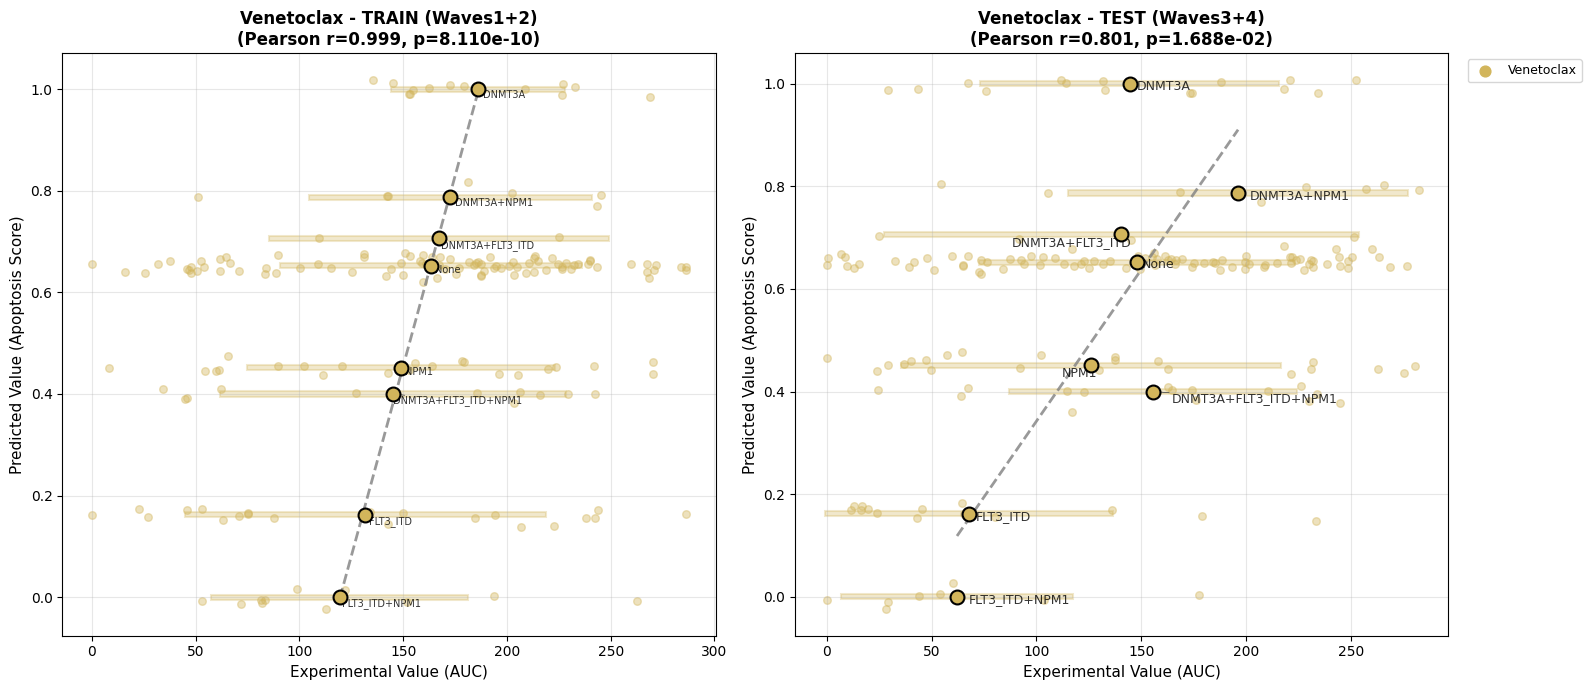

TRAIN: Matched 145 individual samples to predictions
TEST: Matched 147 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Entospletinib_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


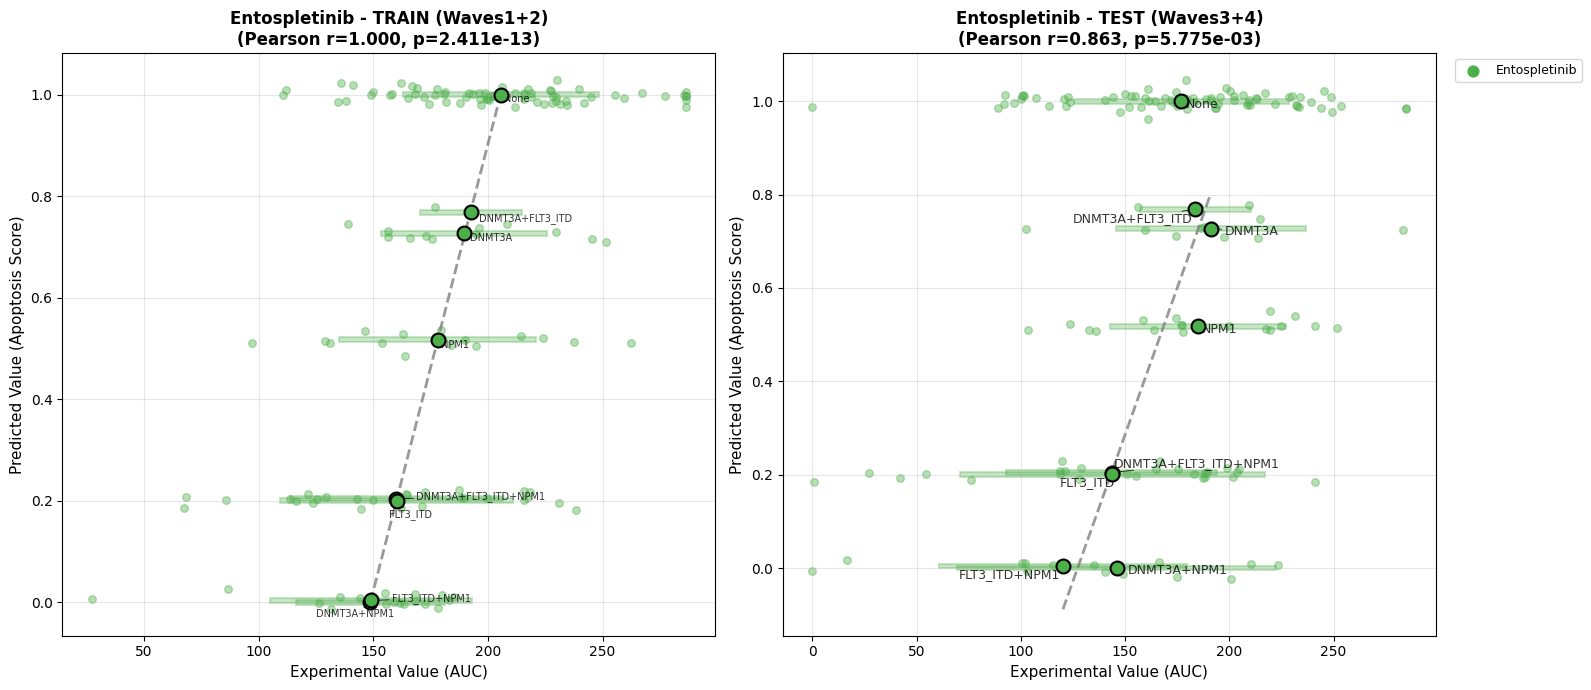

TRAIN: Matched 241 individual samples to predictions
TEST: Matched 173 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ibrutinib_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


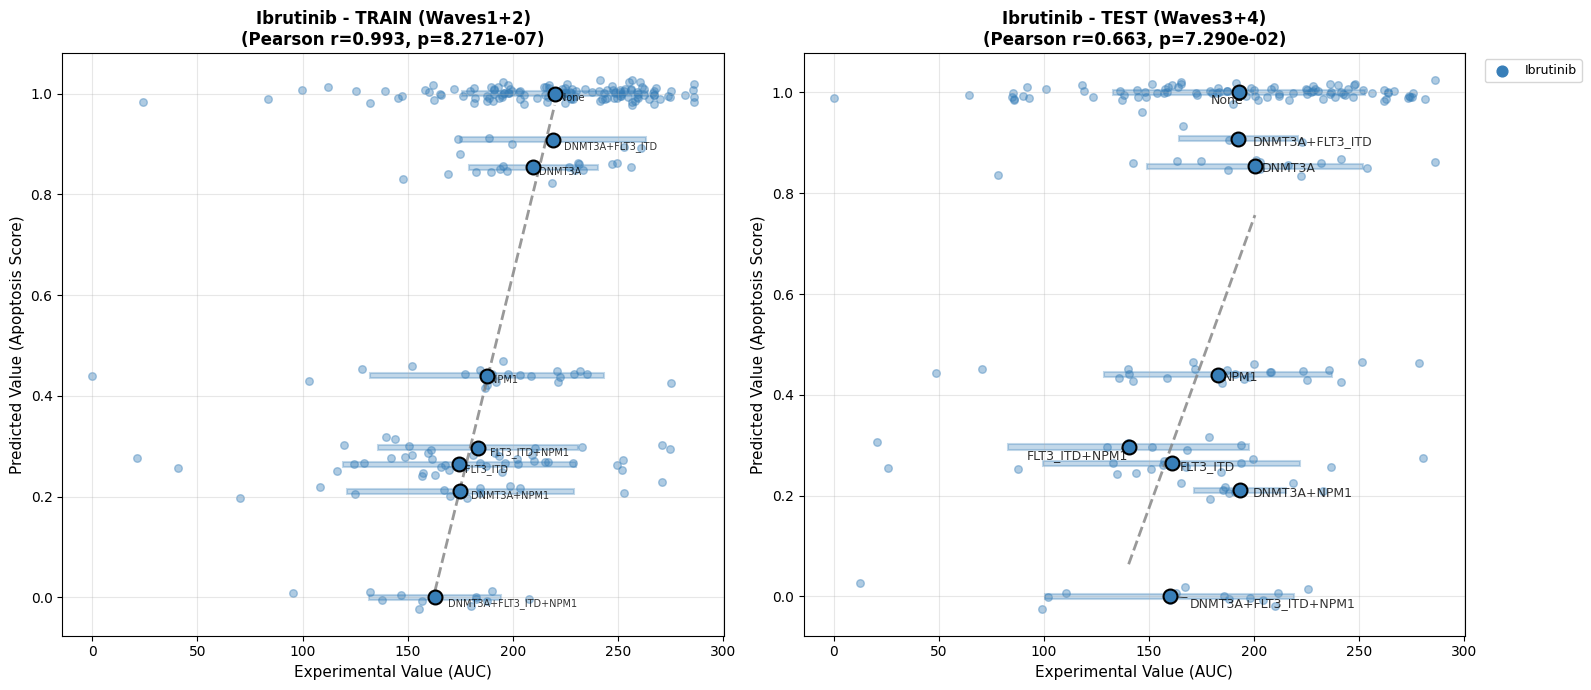

TRAIN: Matched 273 individual samples to predictions
TEST: Matched 187 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Trametinib_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


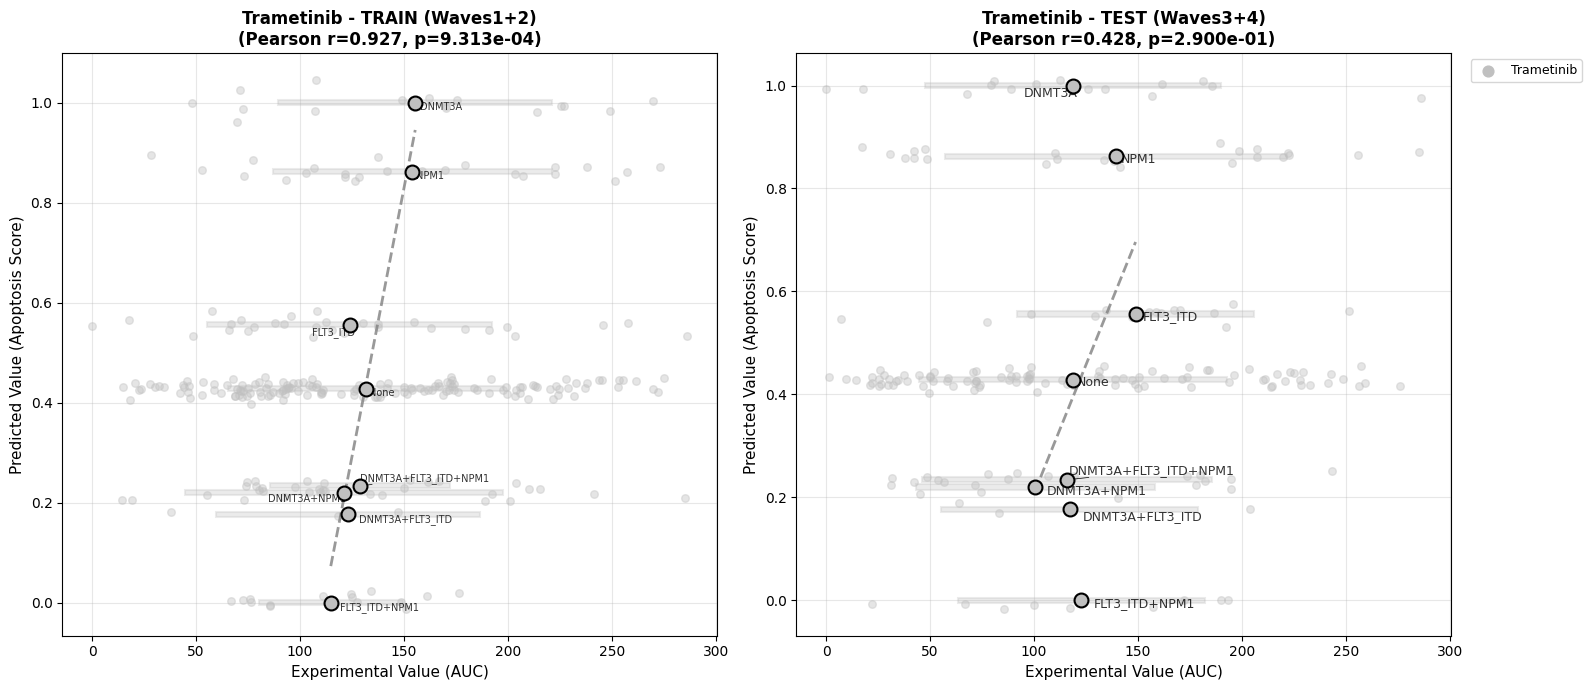

TRAIN: Matched 261 individual samples to predictions
TEST: Matched 164 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Selumetinib_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


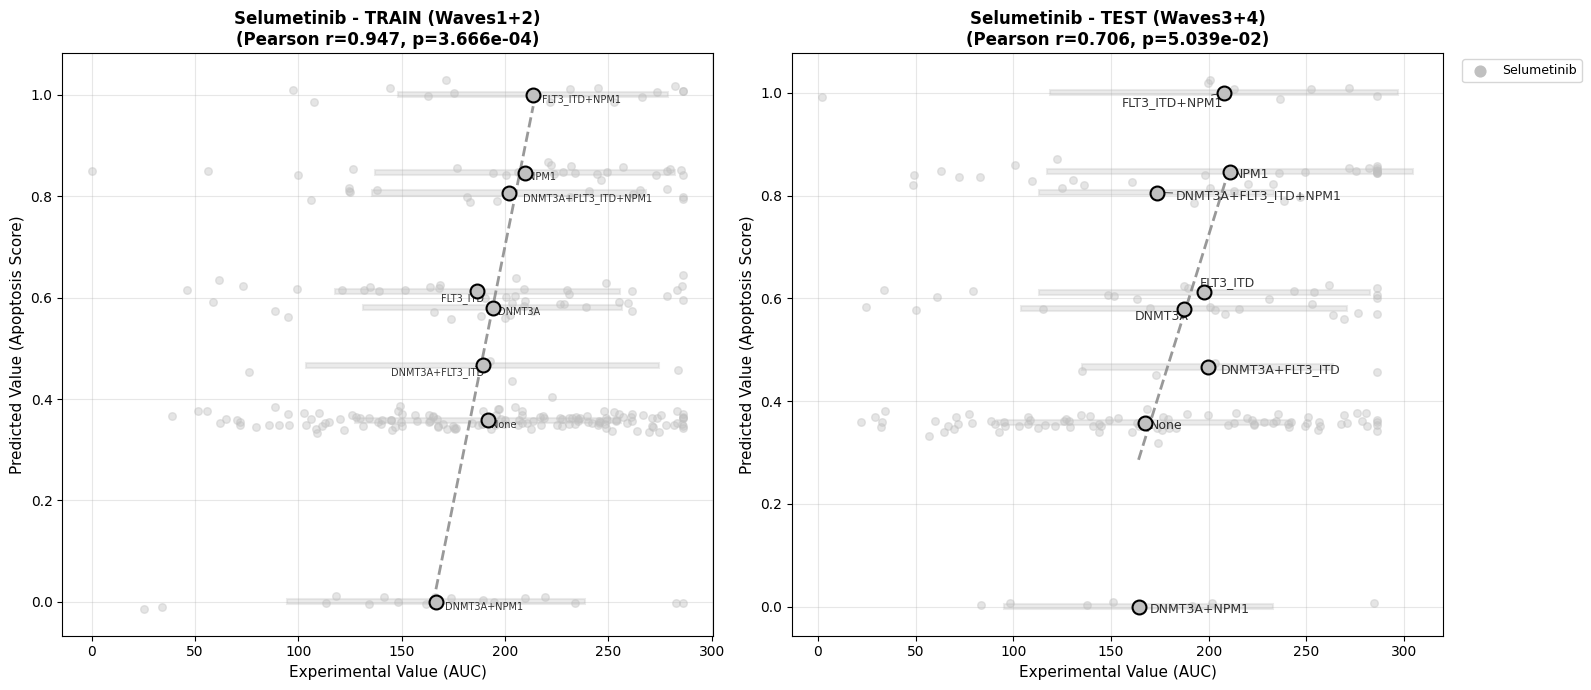

TRAIN: Matched 259 individual samples to predictions
TEST: Matched 181 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Midostaurin_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


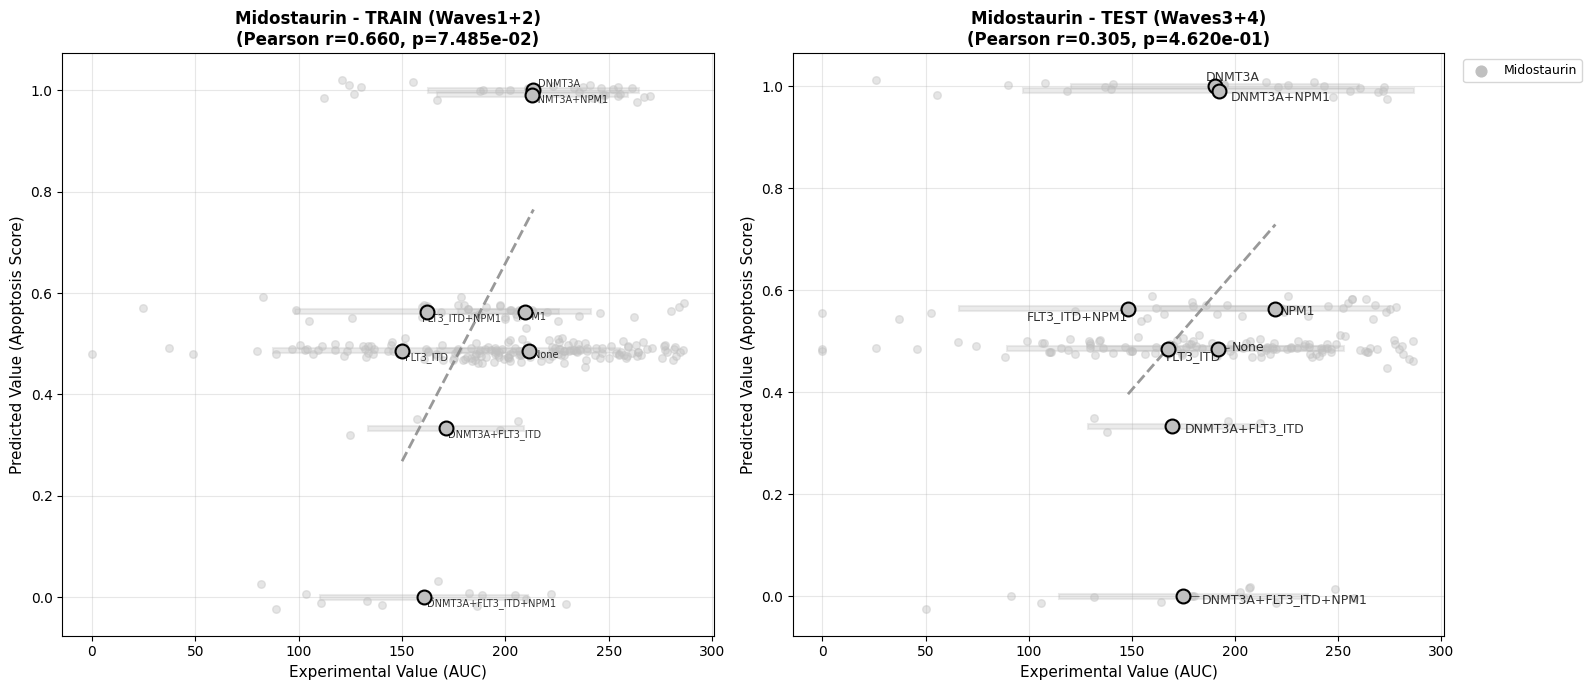

In [430]:
# Plot for each drug
for drug in drugs:
    expanded_plot_beataml(
        drug=drug, 
        df=df, 
        drug2target=drug2target, 
        text_size=9,
        use_spearman=False,
        save_path=f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png'
    )

TRAIN: Matched 564 individual samples to predictions
TEST: Matched 494 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


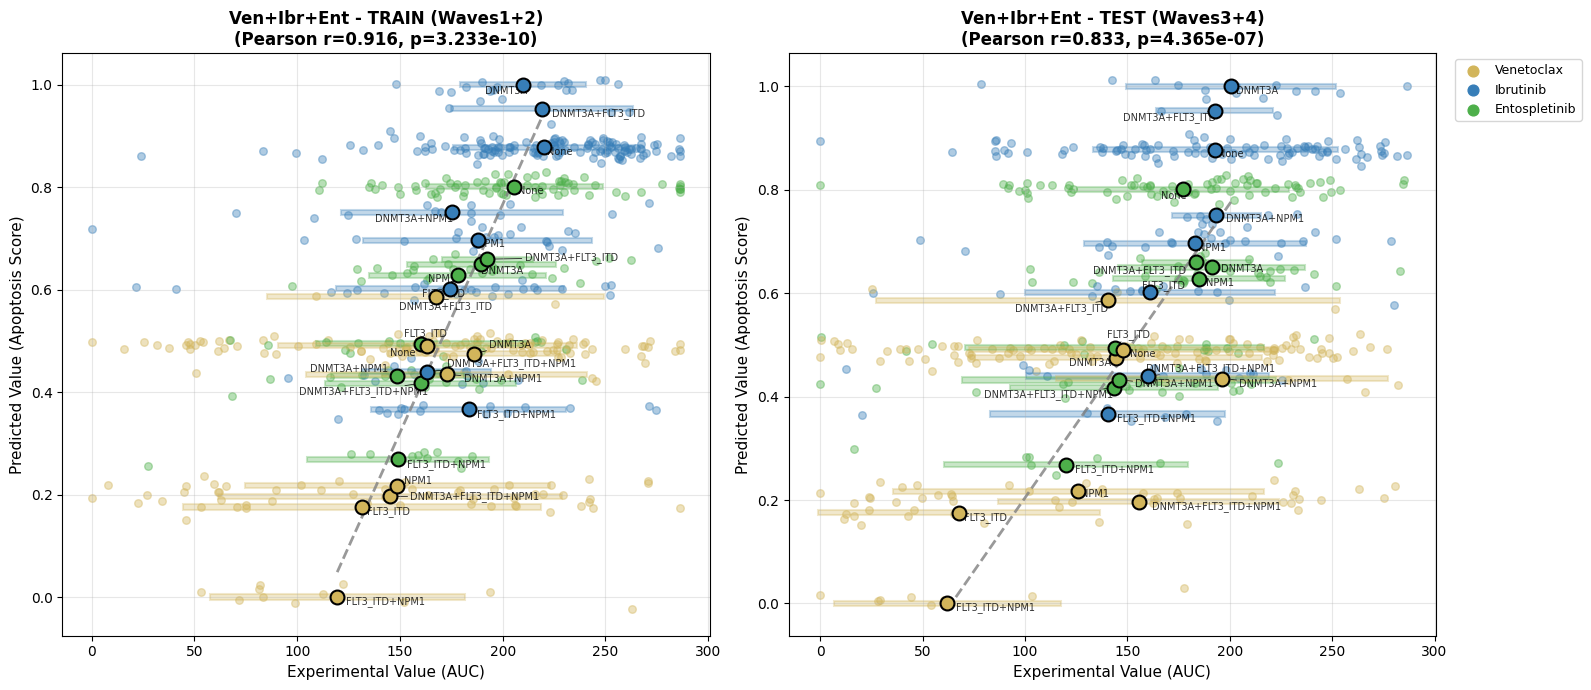

In [322]:
# Plot for combined drugs (Venetoclax + Ibrutinib + Entospletinib)
expanded_plot_beataml(
    drug='Ven+Ibr+Ent', 
    df=df, 
    drug2target=drug2target, 
    use_spearman=False,
    save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png'
)

In [320]:
drug2target

{'Venetoclax': ['BCL2'],
 'Ibrutinib': ['BTK'],
 'Entospletinib': ['SYK'],
 'Trametinib': ['MAP2K1', 'MAP2K2'],
 'Selumetinib': ['MAP2K1', 'MAP2K2'],
 'Midostaurin': ['FLT3', 'KIT']}

TRAIN: Matched 1084 individual samples to predictions
TEST: Matched 839 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_5drugs_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


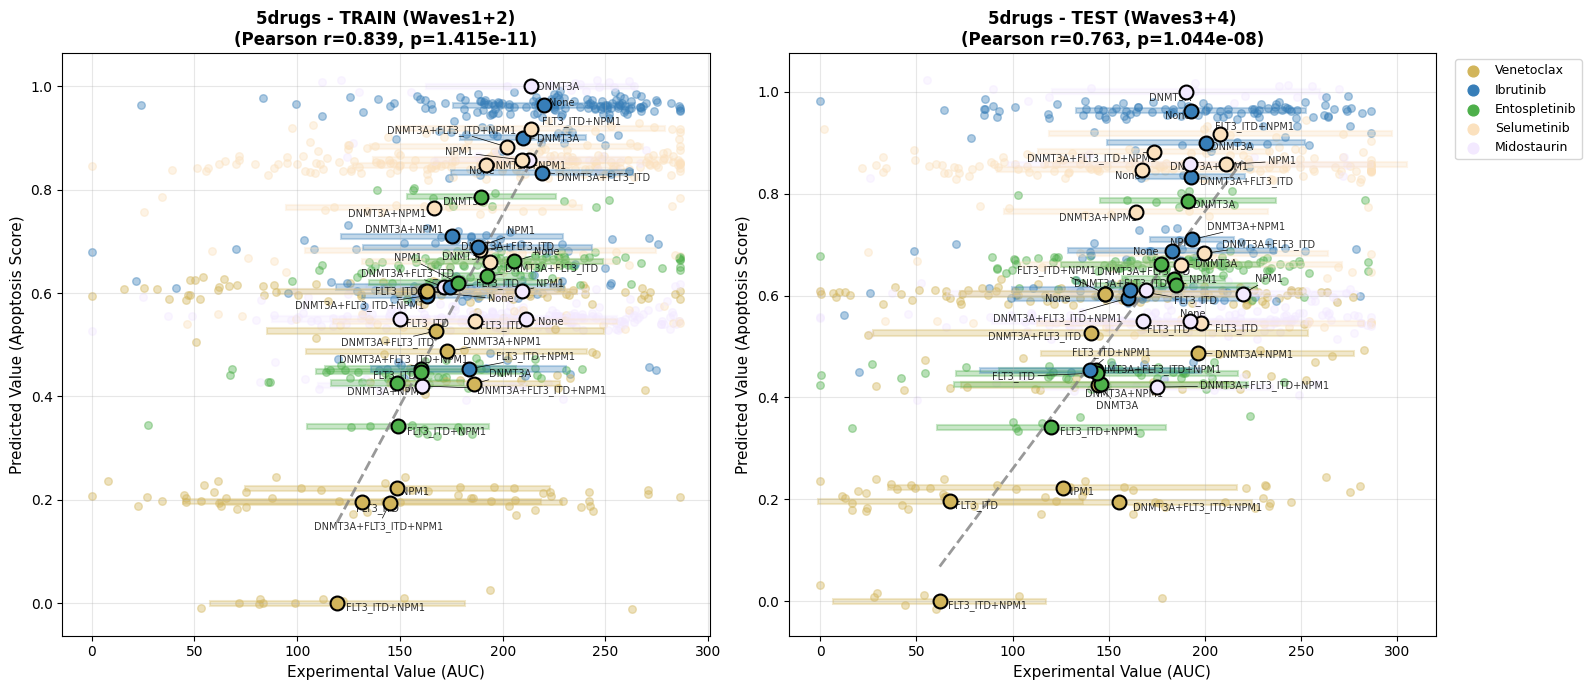

In [327]:
# Plot for combined 5 drugs
expanded_plot_beataml(
    drug='5drugs', 
    df=df, 
    drug2target=drug2target, 
    use_spearman=False,
    save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_5drugs_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png'
)

# Extend to more genes
## NRAS

In [ ]:
# The Palma model
network = KGBN.load_network(network_file_no_phenotype)
# extended PBN by adding drug targets
genes = list(network.nodeDict.keys())
genes = genes + ['NRAS','TP53']
KG_string, relations = KGBN.load_signor_network(genes, joiner='&')
KG = KGBN.load_network_from_string(KG_string)
KGBN.vis_network(KG, output_html="NRAS+TP53_KG.html", interactive=True, color_node='#E1F2D0', physics=False)
# Visualize extended PBN
pbn_string = KGBN.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = KGBN.load_pbn_from_string(pbn_string)
vis_extension(network,pbn, output_html="Palma2021+KG_NRAS+TP53.html", interactive=True, color_node='lightblue', color_edge='lightblue', extension_color_node='#D783FF', physics=False)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
number of genes found: 20
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 4893, 7157]
No initial state provided, using a random initial state
Network loaded successfully. There are 20 genes in the network.
Network visualization saved to NRAS+TP53_KG.html
No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Extension comparison:
  Original nodes: 18
  Extended nodes: 20
  New nodes: 2 - ['DAB2IP', 'NRAS']
  Original edges: 20
  Extended edges: 42
  New edges: 22
Extension visualization saved to Palma2021+KG_NRAS+TP53.html


In [499]:
# Create dataset with drug response and mutations
sample_mutations = {}
for ptid in mutation_matrix.index:
    mutated_genes = mutation_matrix.loc[ptid][mutation_matrix.loc[ptid] == 1].index.tolist()
    # Filter to only model genes
    # mutated_genes_in_model = [g for g in mutated_genes if g in pbn.nodeDict.keys()]
    mutated_genes_in_model = [g for g in mutated_genes if g in ['FLT3_ITD', 'NPM1', 'DNMT3A', 'NRAS']]
    sample_mutations[ptid] = set(mutated_genes_in_model)

# Create mutation profile mapping
mutation_profiles = []
for _, row in sample_to_ptid.iterrows():
    ptid = row['ptid']
    if ptid in sample_mutations:
        mutation_profiles.append({
            'dbgap_sample_id': row['dbgap_sample_id'],
            'ptid': ptid,
            'mutation_profile': sample_mutations[ptid]
        })

mutation_profile_df = pd.DataFrame(mutation_profiles)

# Merge with drug response data
drug_response_merged = pd.merge(
    mutation_profile_df,
    drug_response,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample',
    how='inner'
)

# Filter for selected drugs of interest
df = drug_response_merged[drug_response_merged['inhibitor'].apply(lambda x: any(drug in x for drug in drugs))].copy()

# Merge cohort information
df = pd.merge(df, sample_to_ptid[['dbgap_sample_id', 'cohort']], on='dbgap_sample_id', how='left')

print(f"dataset: {len(df)} records")
print(f"Drugs: {sorted(df['inhibitor'].unique())}")

dataset: 2383 records
Drugs: ['Entospletinib (GS-9973)', 'Ibrutinib (PCI-32765)', 'Midostaurin', 'Selumetinib (AZD6244)', 'Trametinib (GSK1120212)', 'Venetoclax']


Drug:Entospletinib (GS-9973)


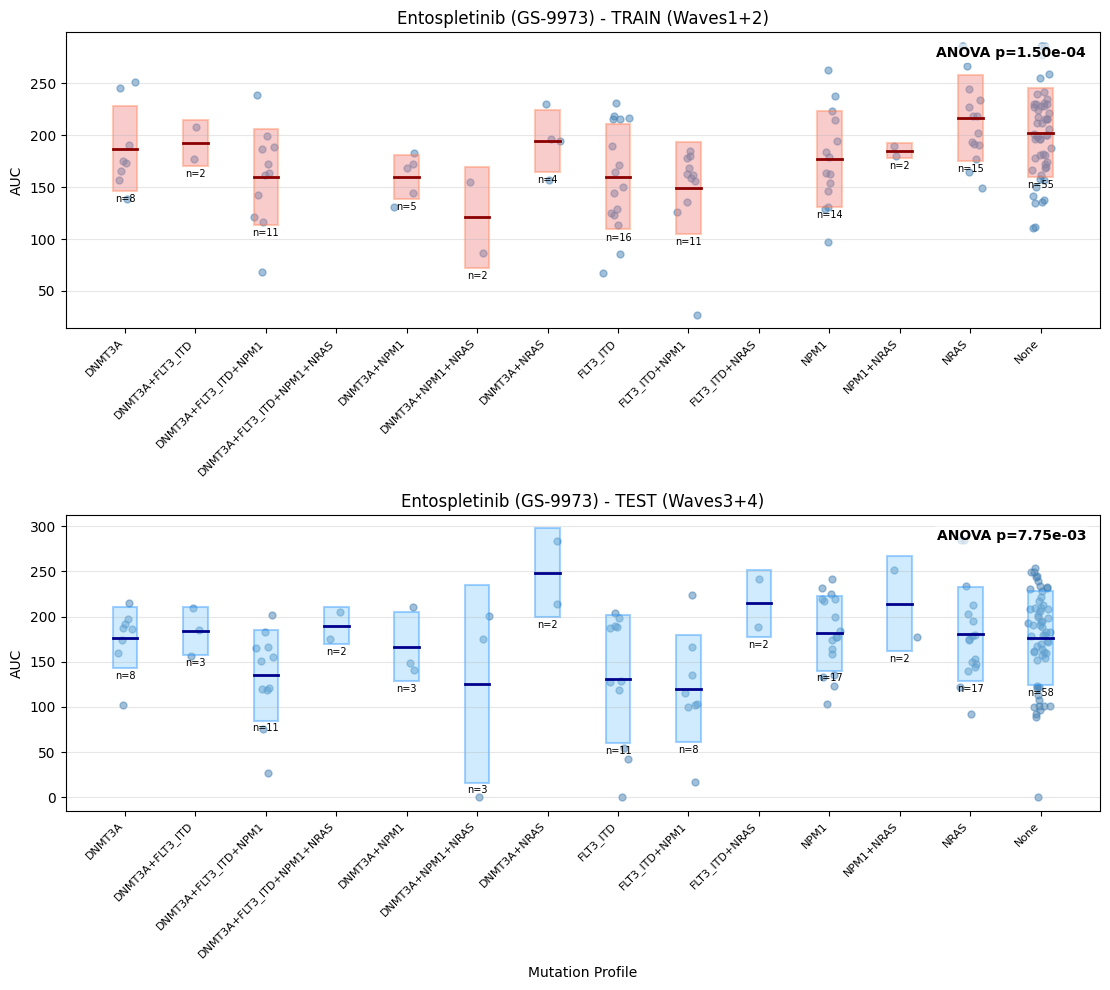

Drug:Ibrutinib (PCI-32765)


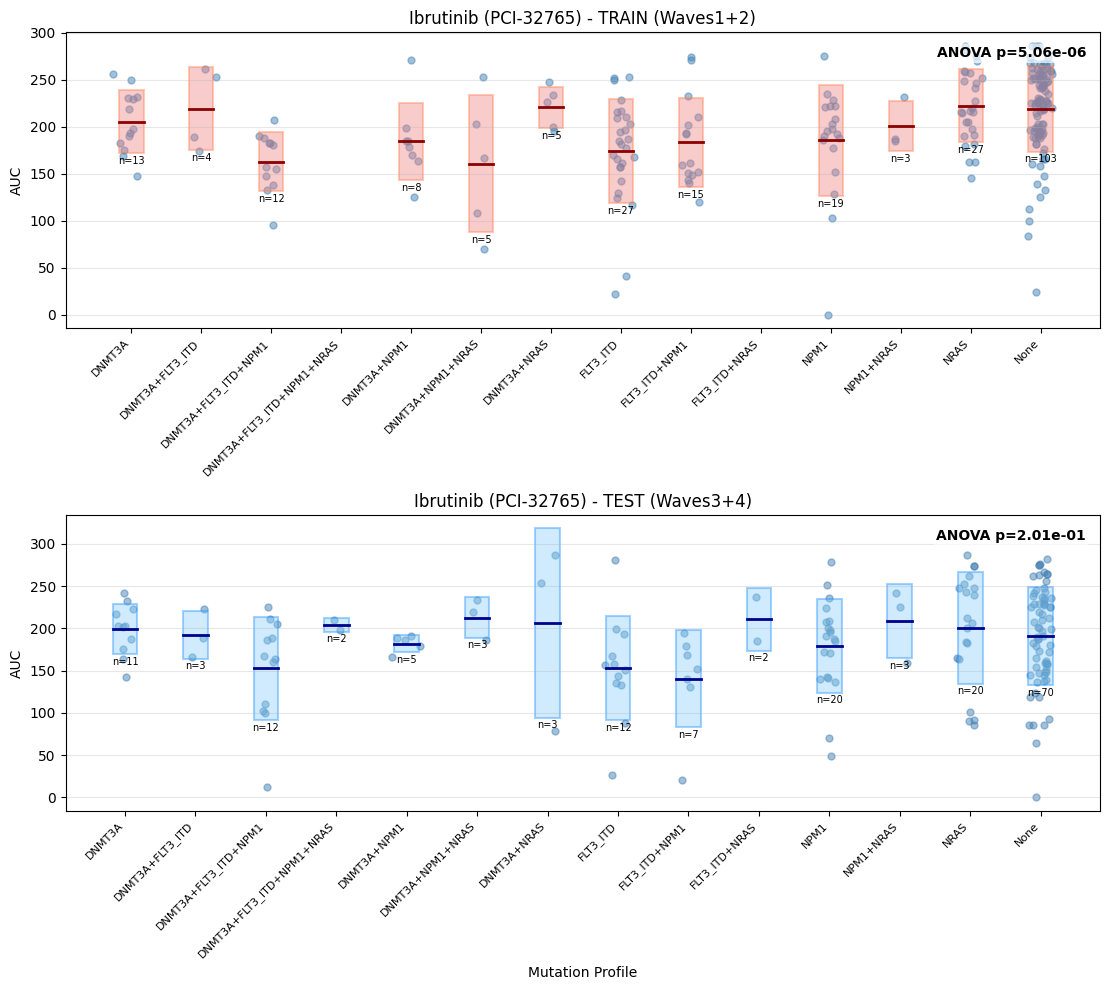

Drug:Midostaurin


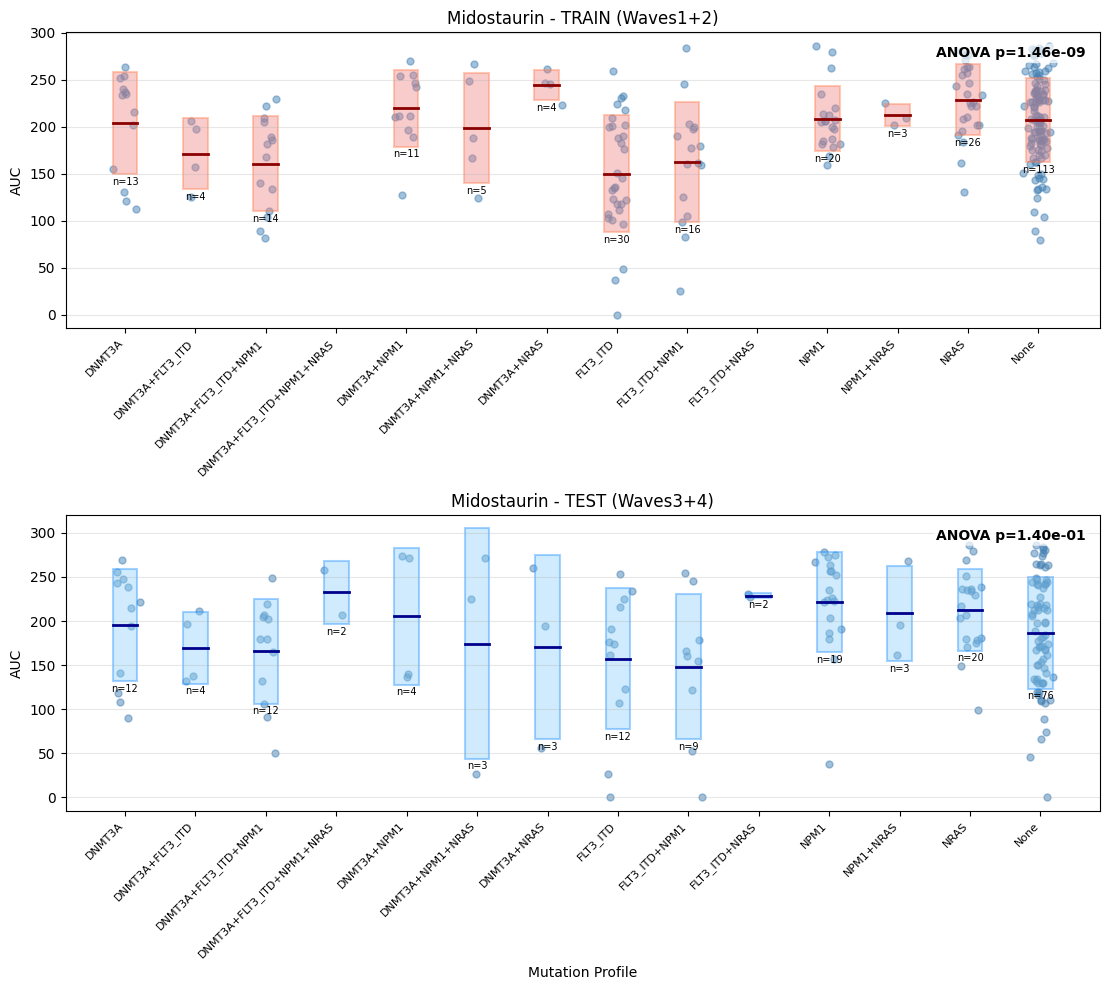

Drug:Selumetinib (AZD6244)


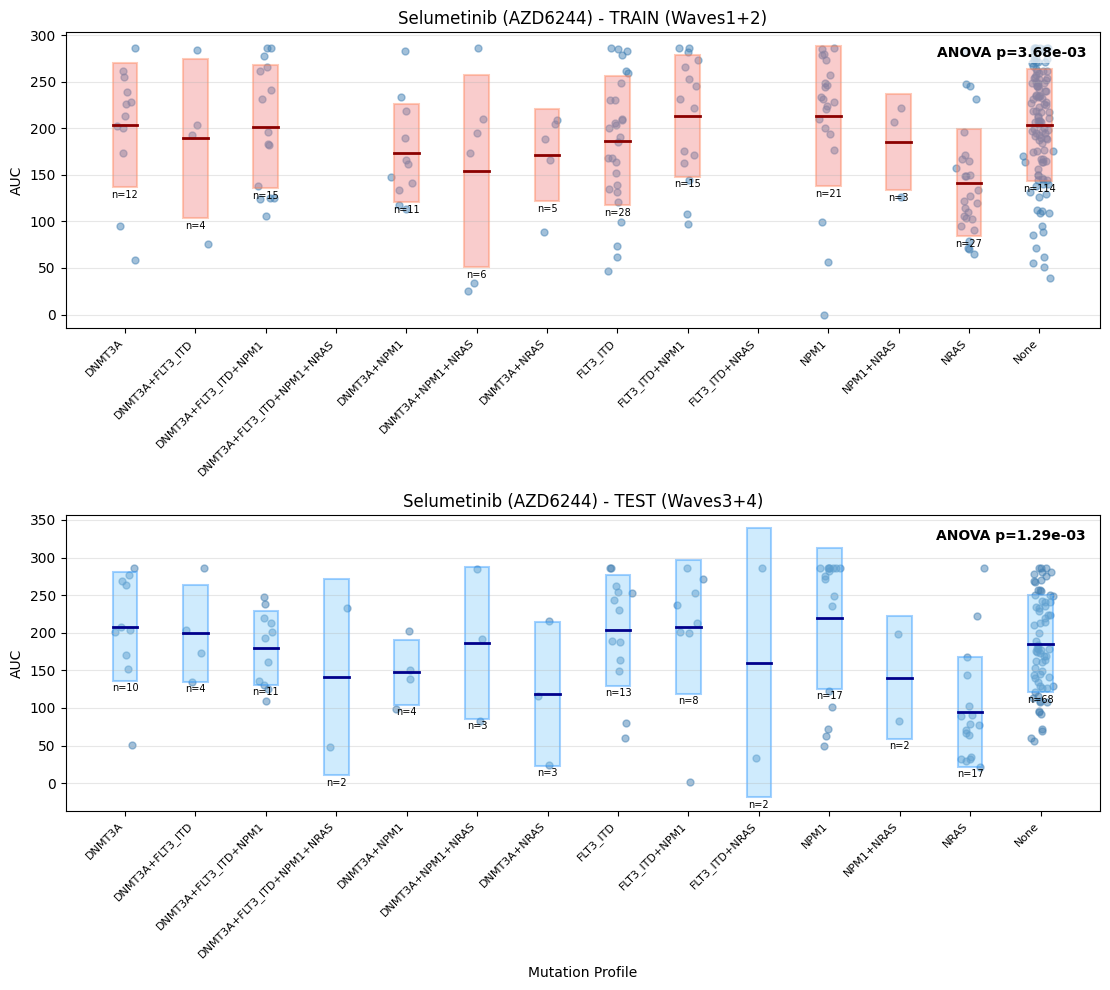

Drug:Trametinib (GSK1120212)


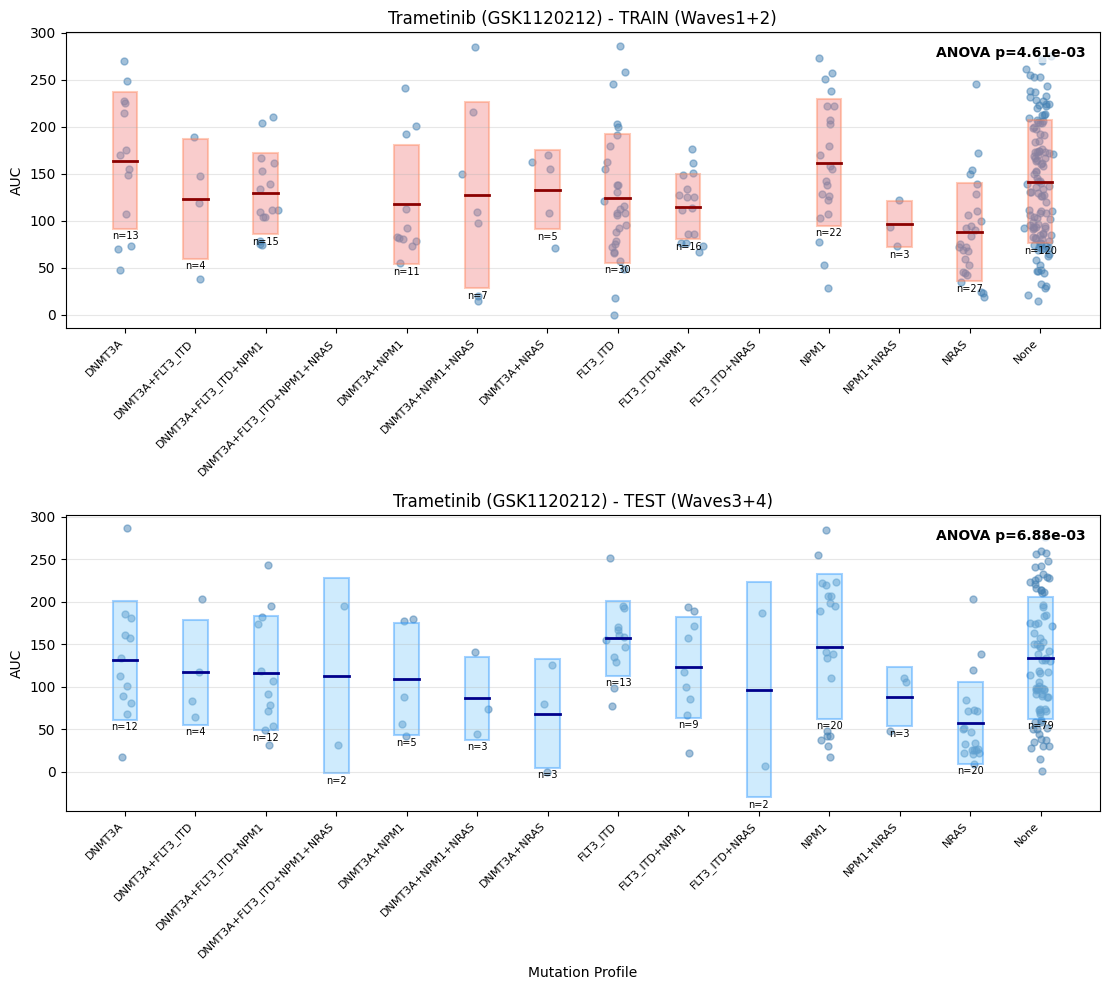

Drug:Venetoclax


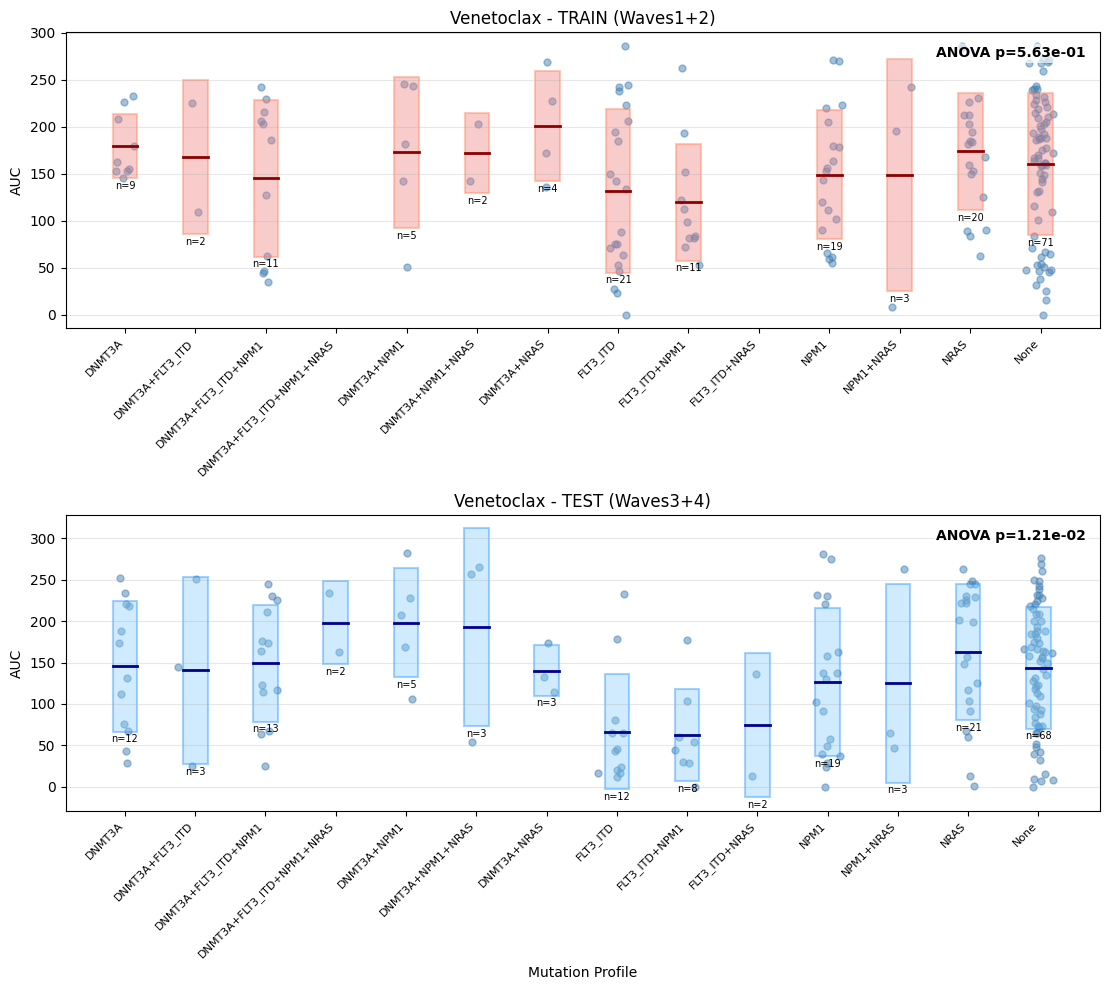

In [500]:
# AUC by mutation profile with mean ± s.d. boxes (Train vs Test)
AUC_by_mutation_profile(df)

In [ ]:
# Create experimental data
for drug in drugs:
    exp_data = create_experimental_data(
        df, 
        cohort='Waves1+2',
        mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A', 'NRAS'],
        inhibitors=[drug],
        output_file=f'../data/BeatAML_AUC_{drug}_NRAS_Waves1+2.csv'
    )
    exp_data = create_experimental_data(
        df, 
        cohort='Waves3+4',
        mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A', 'NRAS'],
        inhibitors=[drug],
        output_file=f'../data/BeatAML_AUC_{drug}_NRAS_Waves3+4.csv'
    )

\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 12 experiments to ../data/BeatAML_AUC_Venetoclax_NRAS_Waves1+2.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             178  160.12±22.46
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 14 experiments to ../data/BeatAML_AUC_Venetoclax_NRAS_Waves3+4.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             174  137.47±44.97
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 12 experiments to ../data/BeatAML_AUC_Entospletinib_NRAS_Waves1+2.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             145  175.50±26.49
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 14 experiments to ../data/BeatAML_AUC_Entospletinib_NRAS_Waves3+4.csv
\nSummary by dr

In [ ]:
# get phenotype score formula
network = KGBN.load_network(network_file_no_phenotype)
genes = list(network.nodeDict.keys())
genes = genes + ['BTK','NRAS']

KG_AND_string, relations = KGBN.load_signor_network(genes, joiner='&')
KG_AND = KGBN.load_network_from_string(KG_AND_string)
pbn_string = KGBN.merge_networks([network, KG_AND], method="PBN", prob=0.6)
pbn = KGBN.load_pbn_from_string(pbn_string)

formula = KGBN.phenotype_scores(
    genes=pbn.nodeDict.keys(),
    simulation_results=None,
    phenotypes=['APOPTOSIS']
)
formula

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
number of genes found: 20
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 695, 4893]
No initial state provided, using a random initial state
Network loaded successfully. There are 21 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 21 genes in the network.
Path found for 1 phenotypes: ['APOPTOSIS']


{'APOPTOSIS': '- AKT1 -  BCL2 + CDKN2A + GSK3B -  MAPK1 -  MEIS1 -  NRAS -  STAT5A + TP53'}

TRAIN: Matched 178 individual samples to predictions
TEST: Matched 174 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Venetoclax_NRAS_DAB_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


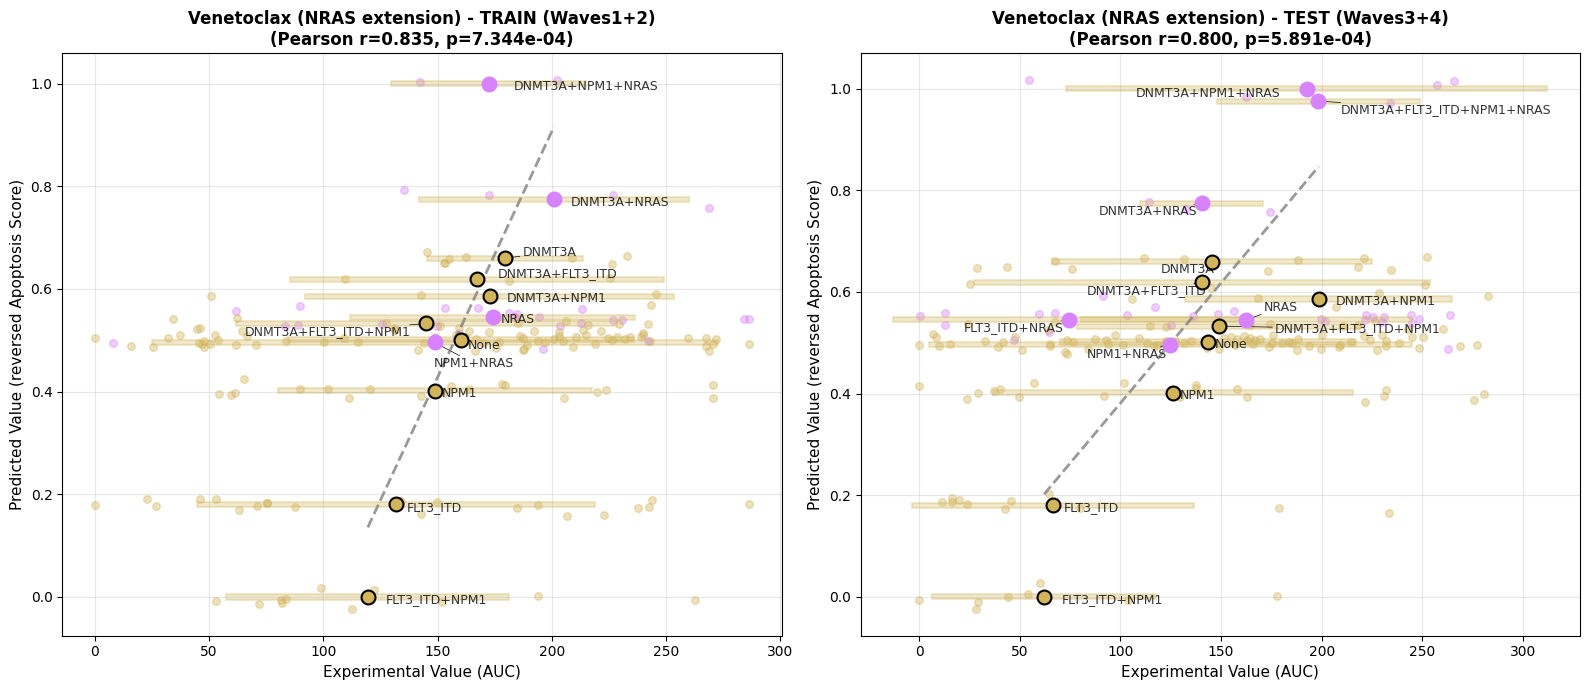

TRAIN: Matched 145 individual samples to predictions
TEST: Matched 147 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Entospletinib_NRAS_DAB_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


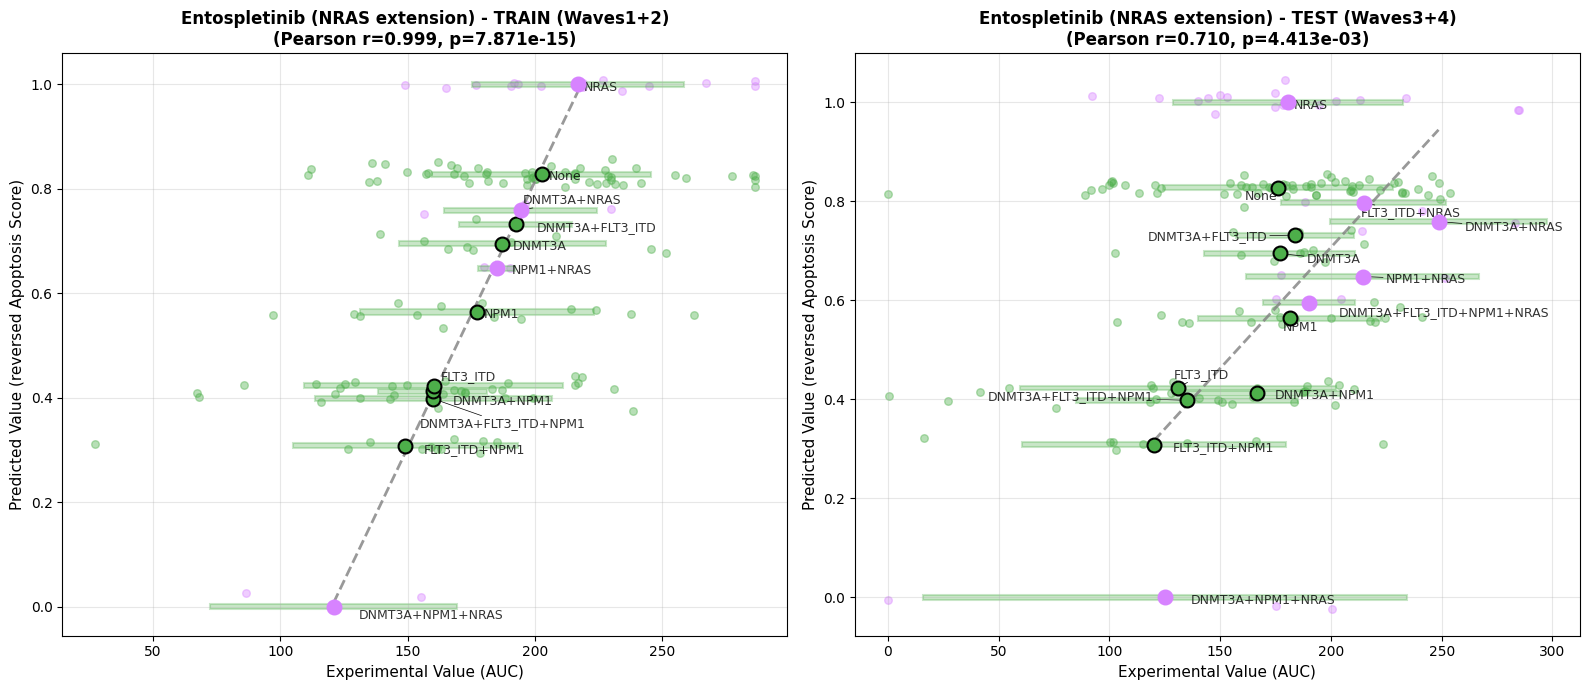

TRAIN: Matched 241 individual samples to predictions
TEST: Matched 173 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ibrutinib_NRAS_DAB_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


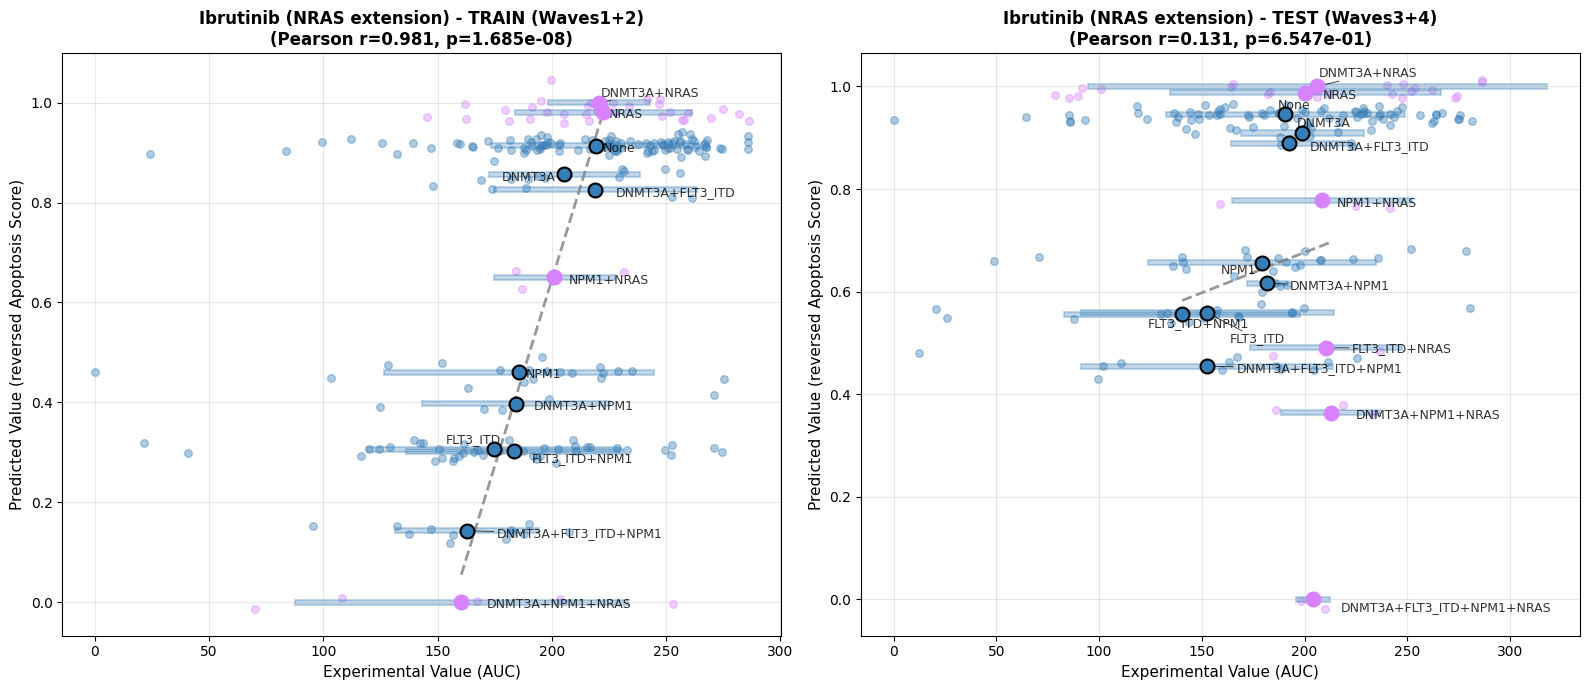

TRAIN: Matched 273 individual samples to predictions
TEST: Matched 187 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Trametinib_NRAS_DAB_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


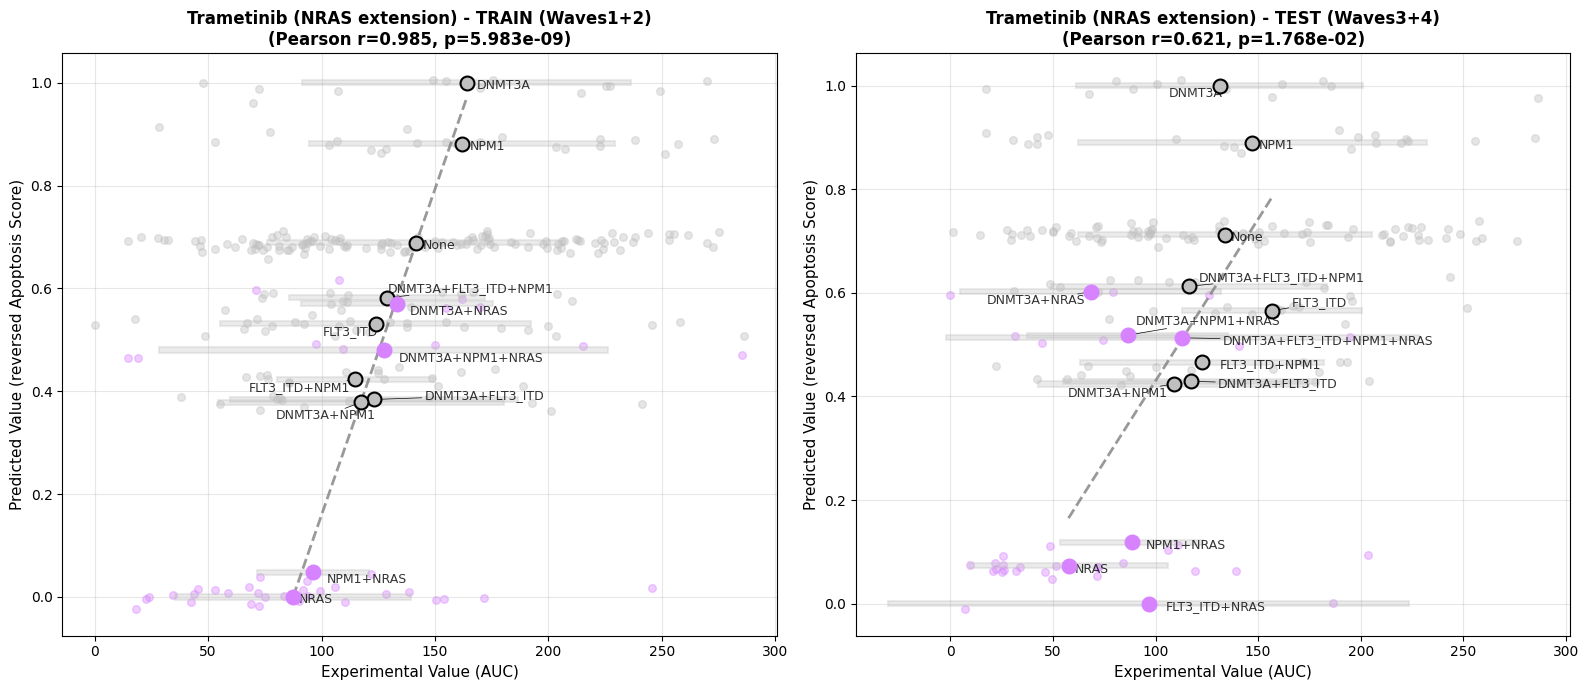

TRAIN: Matched 261 individual samples to predictions
TEST: Matched 164 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Selumetinib_NRAS_DAB_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


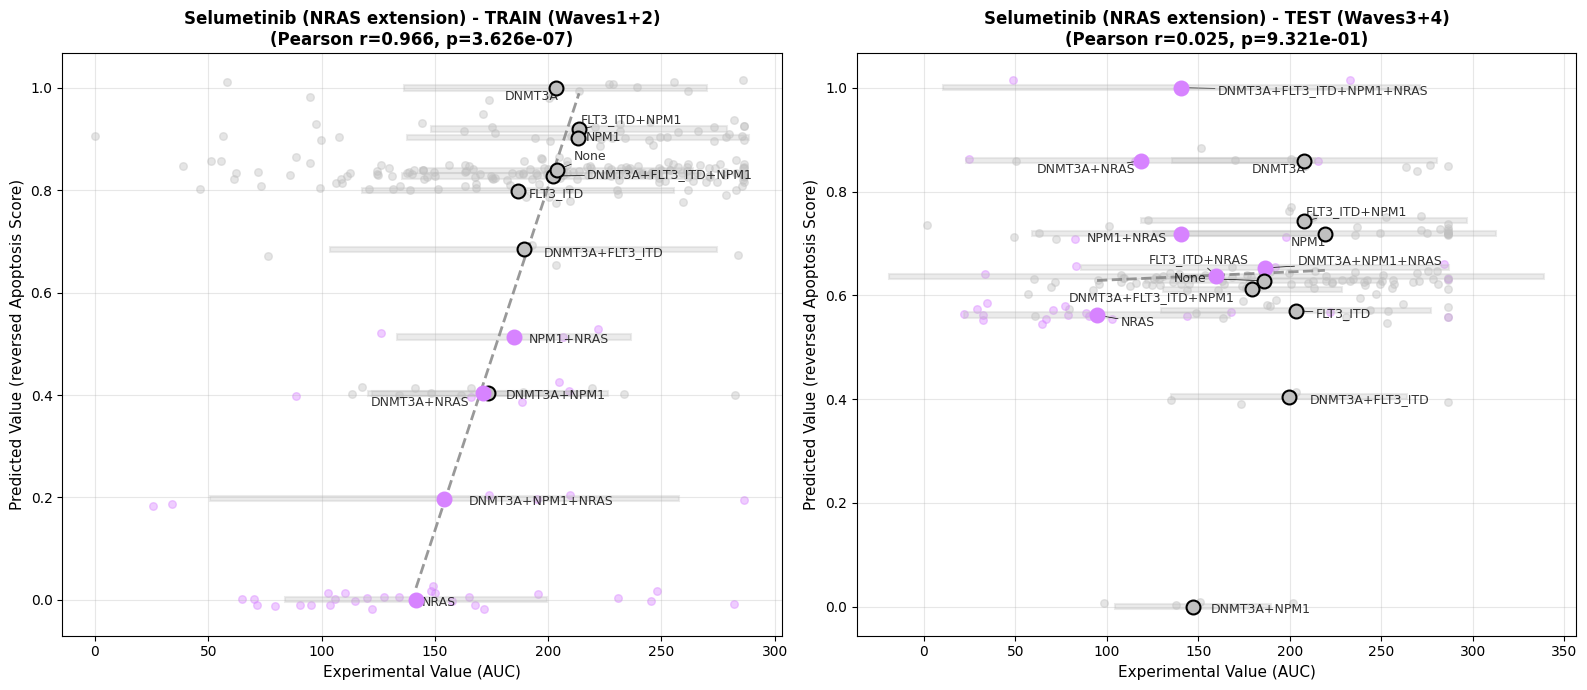

TRAIN: Matched 259 individual samples to predictions
TEST: Matched 181 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Midostaurin_NRAS_DAB_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


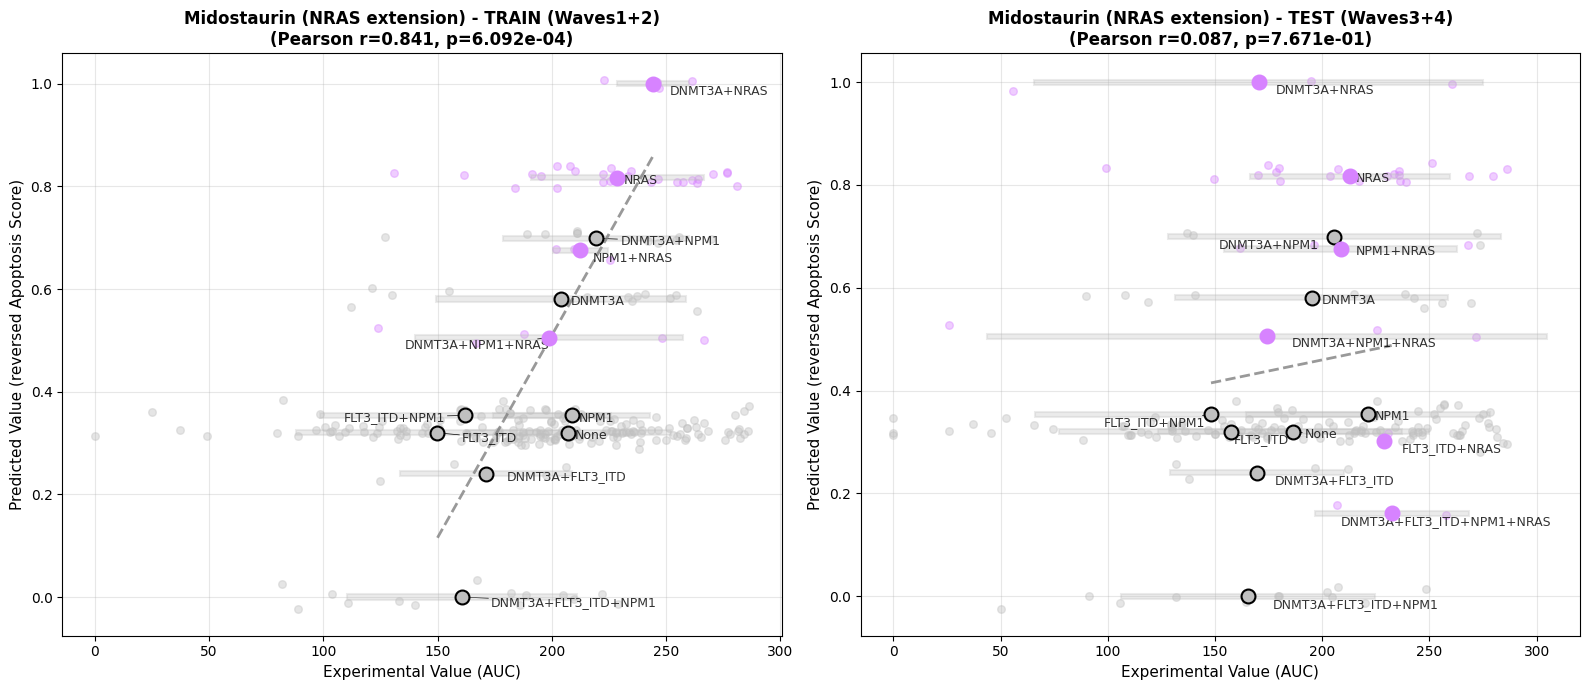

In [525]:
extended_gene = 'NRAS'
for drug in drugs:
    expanded_plot_beataml(
        drug=drug, 
        df=df, 
        drug2target=drug2target, 
        text_size=9,
        extended_gene=extended_gene,
        use_spearman=False,
        save_path=f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_NRAS_DAB_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png'
    )

## TP53

Drug:Entospletinib (GS-9973)


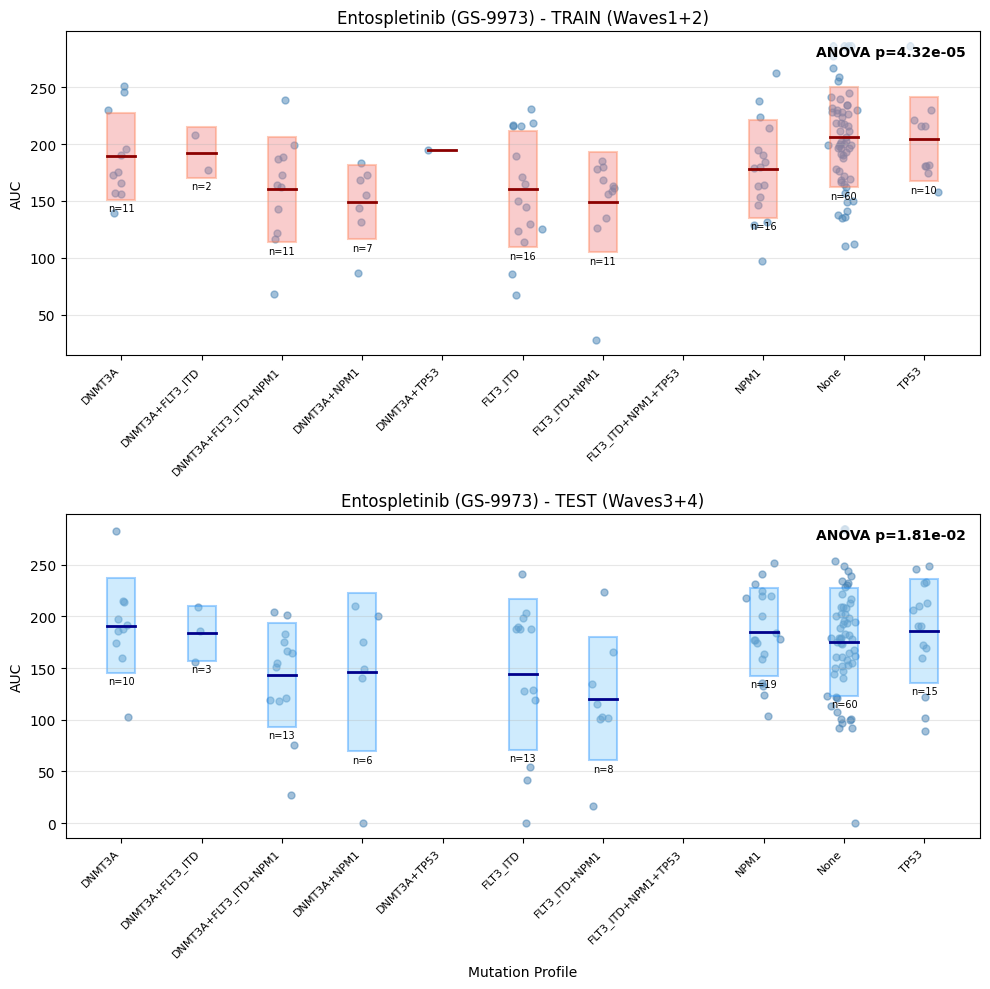

Drug:Ibrutinib (PCI-32765)


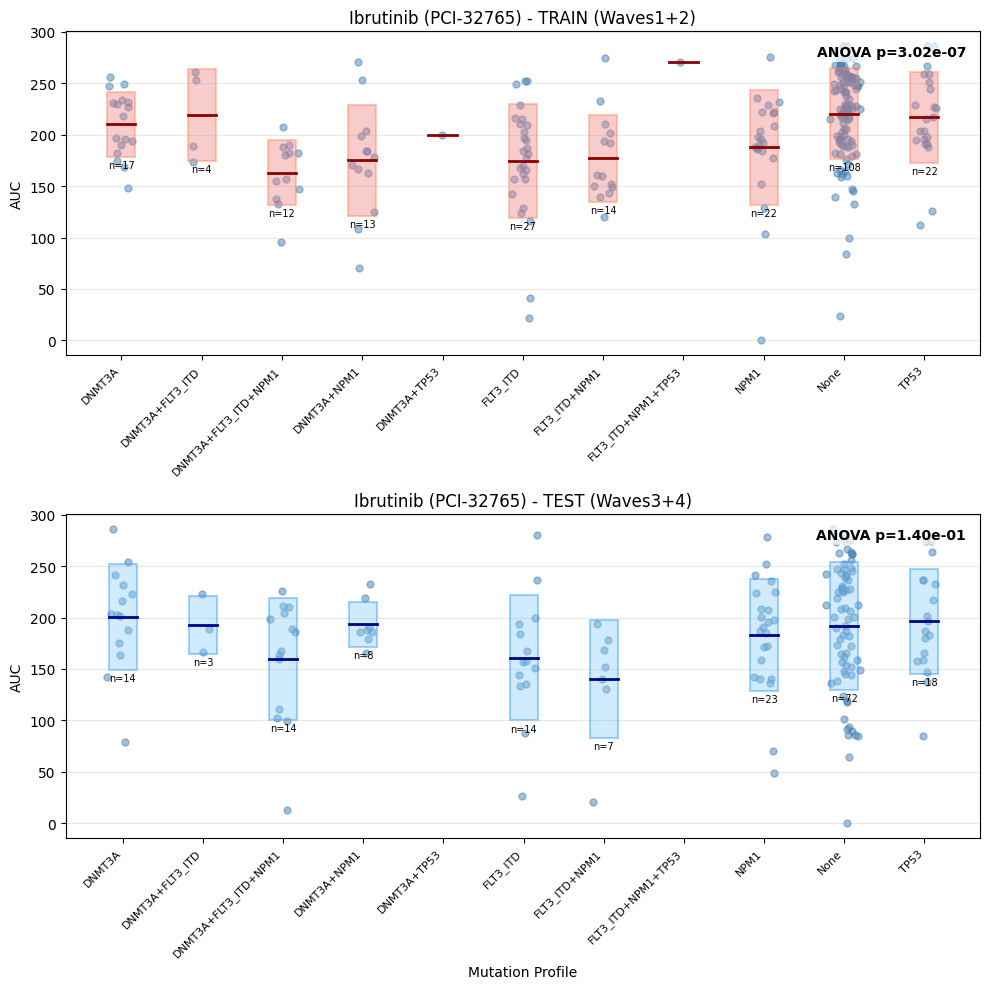

Drug:Midostaurin


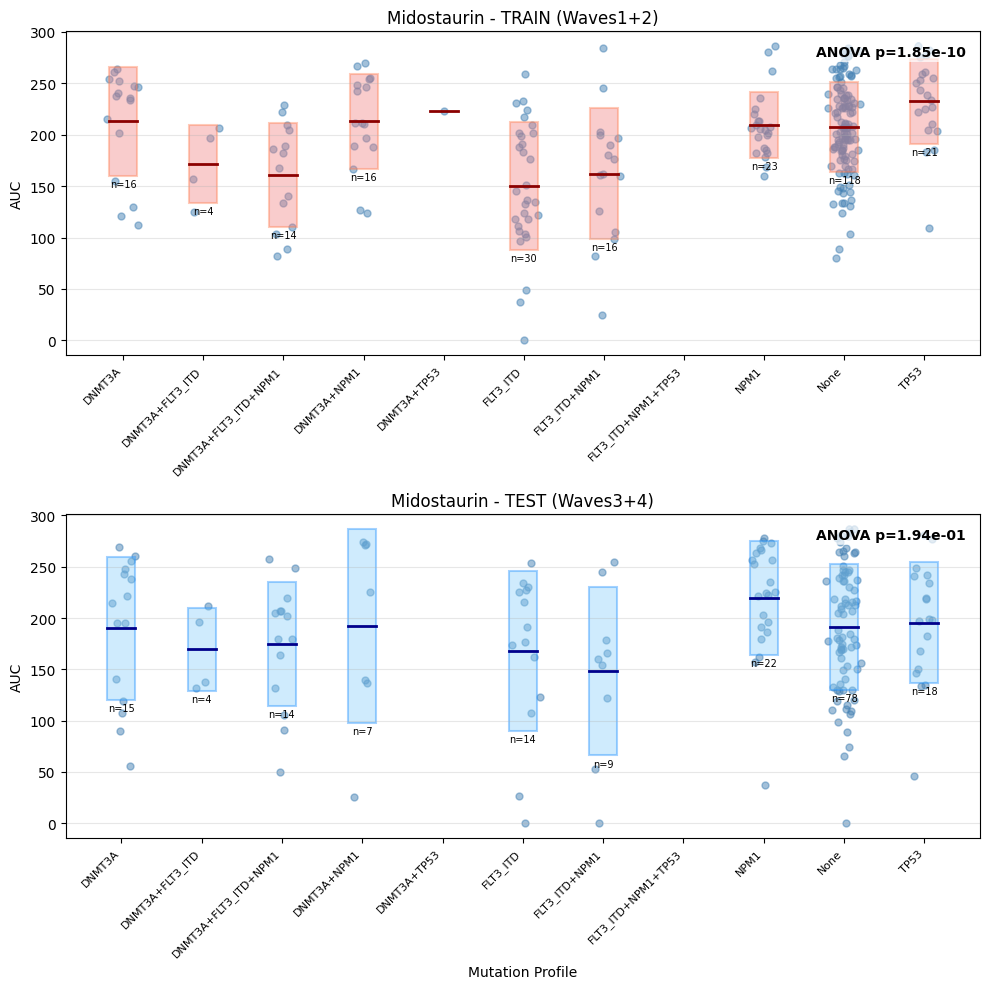

Drug:Selumetinib (AZD6244)


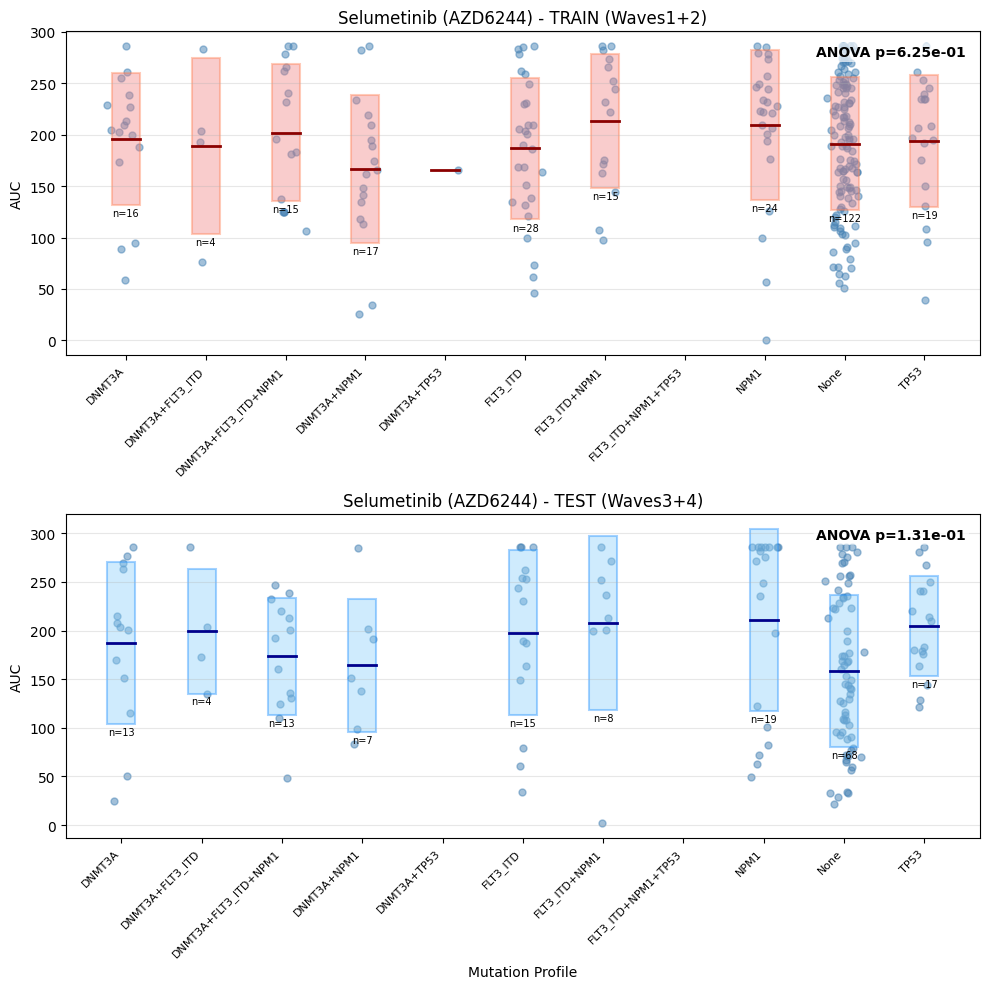

Drug:Trametinib (GSK1120212)


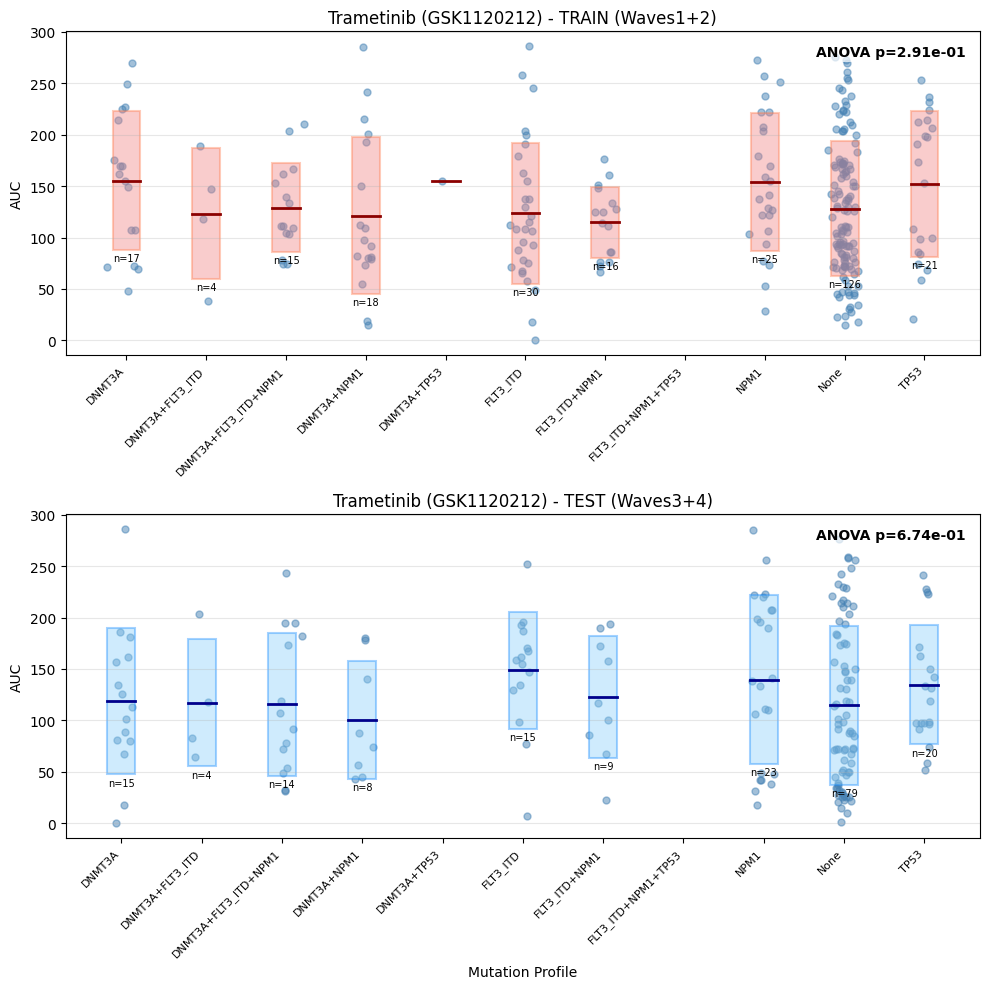

Drug:Venetoclax


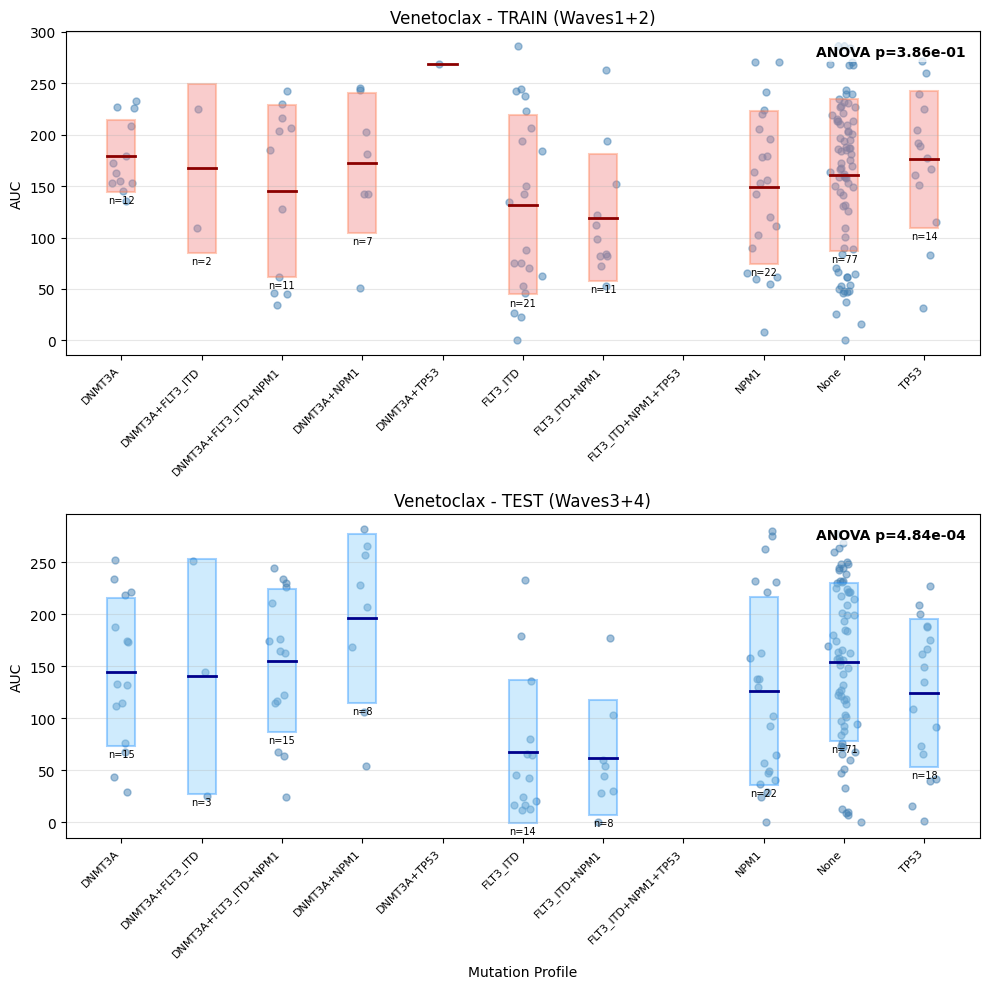

In [463]:
# Create dataset with drug response and mutations
sample_mutations = {}
for ptid in mutation_matrix.index:
    mutated_genes = mutation_matrix.loc[ptid][mutation_matrix.loc[ptid] == 1].index.tolist()
    # Filter to only model genes
    # mutated_genes_in_model = [g for g in mutated_genes if g in pbn.nodeDict.keys()]
    mutated_genes_in_model = [g for g in mutated_genes if g in ['FLT3_ITD', 'NPM1', 'DNMT3A', 'TP53']]
    sample_mutations[ptid] = set(mutated_genes_in_model)

# Create mutation profile mapping
mutation_profiles = []
for _, row in sample_to_ptid.iterrows():
    ptid = row['ptid']
    if ptid in sample_mutations:
        mutation_profiles.append({
            'dbgap_sample_id': row['dbgap_sample_id'],
            'ptid': ptid,
            'mutation_profile': sample_mutations[ptid]
        })

mutation_profile_df = pd.DataFrame(mutation_profiles)

# Merge with drug response data
drug_response_merged = pd.merge(
    mutation_profile_df,
    drug_response,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample',
    how='inner'
)

# Filter for selected drugs of interest
df = drug_response_merged[drug_response_merged['inhibitor'].apply(lambda x: any(drug in x for drug in drugs))].copy()

# Merge cohort information
df = pd.merge(df, sample_to_ptid[['dbgap_sample_id', 'cohort']], on='dbgap_sample_id', how='left')

# AUC by mutation profile with mean ± s.d. boxes (Train vs Test)
AUC_by_mutation_profile(df)

In [10]:
for drug in drugs:
    exp_data = create_experimental_data(
        df, 
        cohort='Waves1+2',
        mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A', 'TP53'],
        inhibitors=[drug],
        output_file=f'../data/BeatAML_AUC_{drug}_TP53_Waves1+2.csv'
    )
    exp_data = create_experimental_data(
        df, 
        cohort='Waves3+4',
        mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A', 'TP53'],
        inhibitors=[drug],
        output_file=f'../data/BeatAML_AUC_{drug}_TP53_Waves3+4.csv'
    )

\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 10 experiments to ../data/BeatAML_AUC_Entospletinib_TP53_Waves1+2.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             145  178.33±22.19
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 9 experiments to ../data/BeatAML_AUC_Entospletinib_TP53_Waves3+4.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             147  163.76±25.55
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 11 experiments to ../data/BeatAML_AUC_Ibrutinib_TP53_Waves1+2.csv
\nSummary by drug:
           Total patients   Mean AUC±SD
drug                                   
Ibrutinib             241  201.39±30.87
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 9 experiments to ../data/BeatAML_AUC_Ibrutinib_TP53_Waves3+4.csv
\nSummary by 

TRAIN: Matched 178 individual samples to predictions
TEST: Matched 174 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Venetoclax_TP53_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


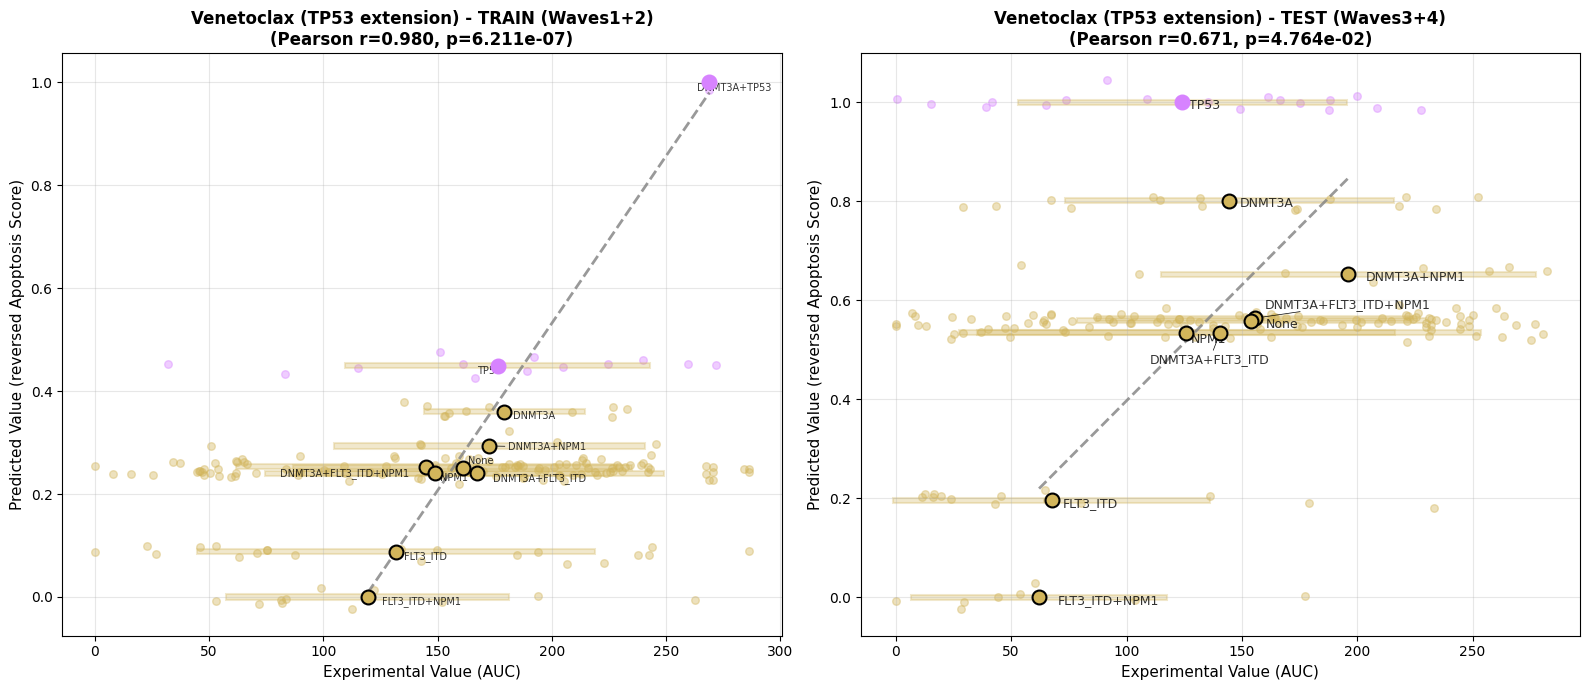

TRAIN: Matched 145 individual samples to predictions
TEST: Matched 147 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Entospletinib_TP53_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


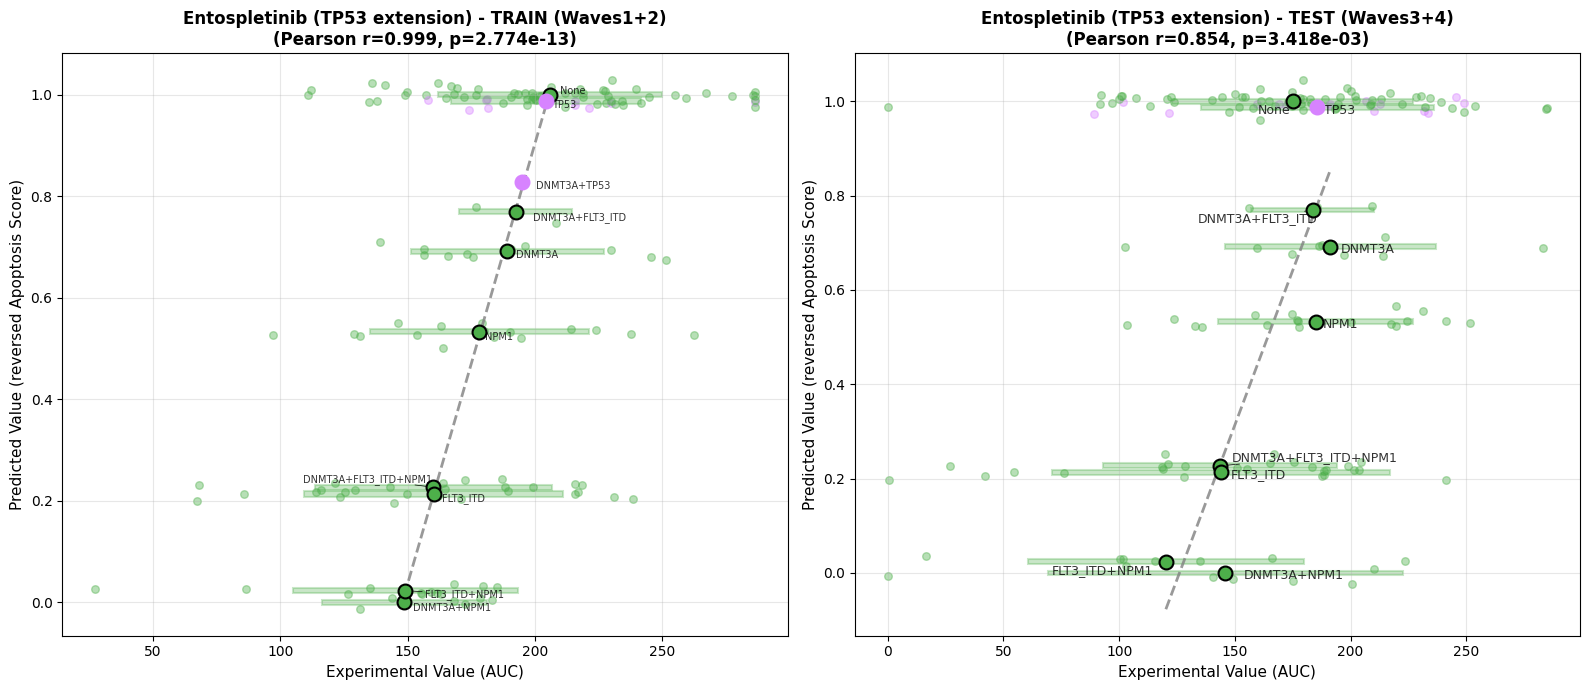

TRAIN: Matched 241 individual samples to predictions
TEST: Matched 173 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ibrutinib_TP53_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


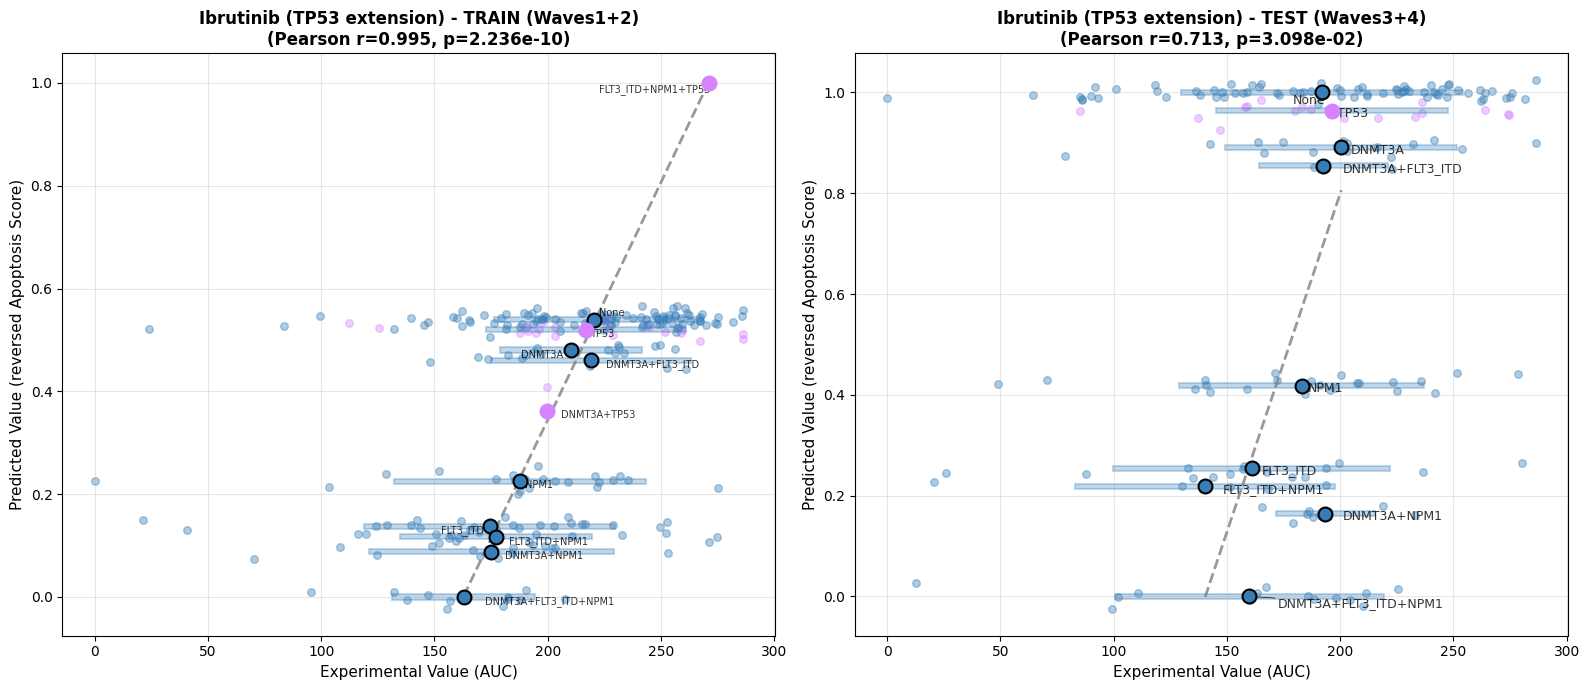

TRAIN: Matched 273 individual samples to predictions
TEST: Matched 187 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Trametinib_TP53_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


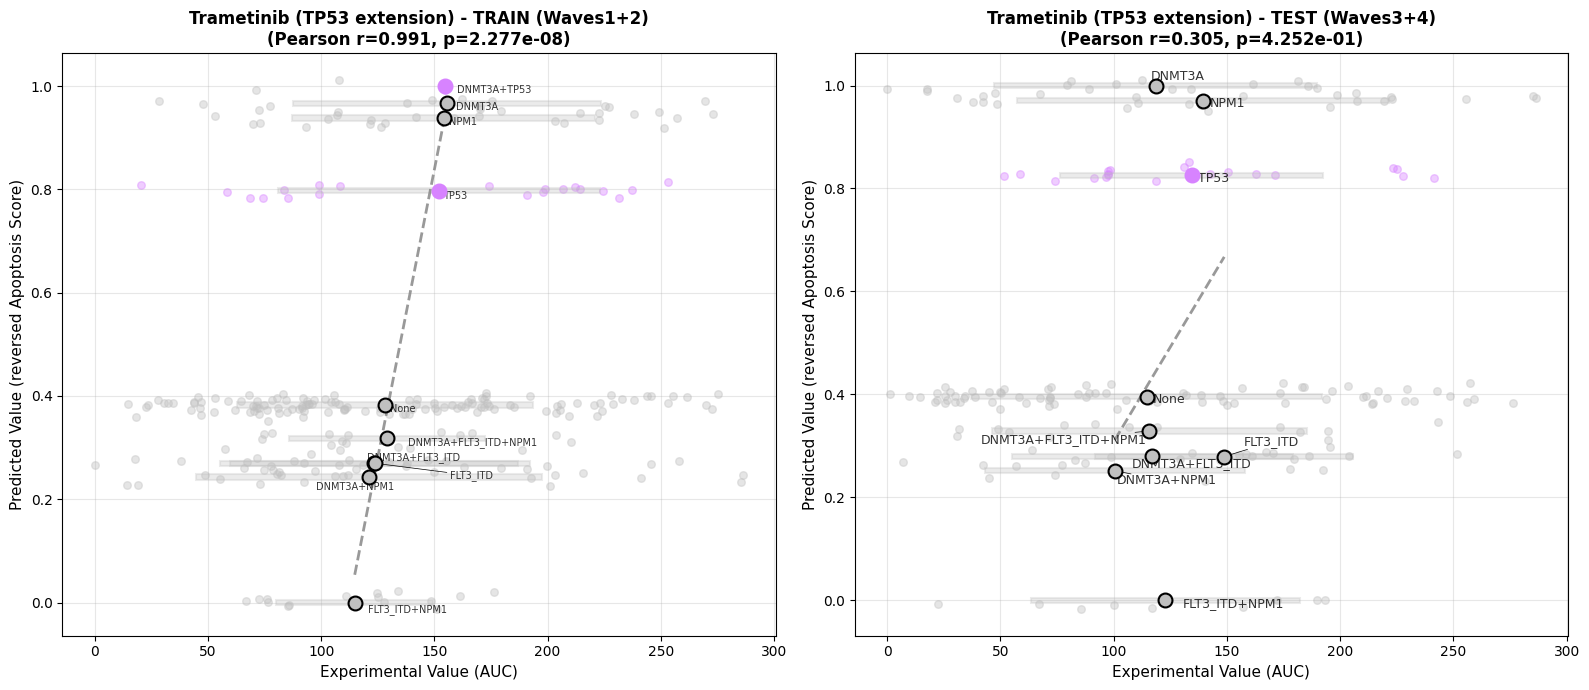

TRAIN: Matched 261 individual samples to predictions
TEST: Matched 164 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Selumetinib_TP53_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


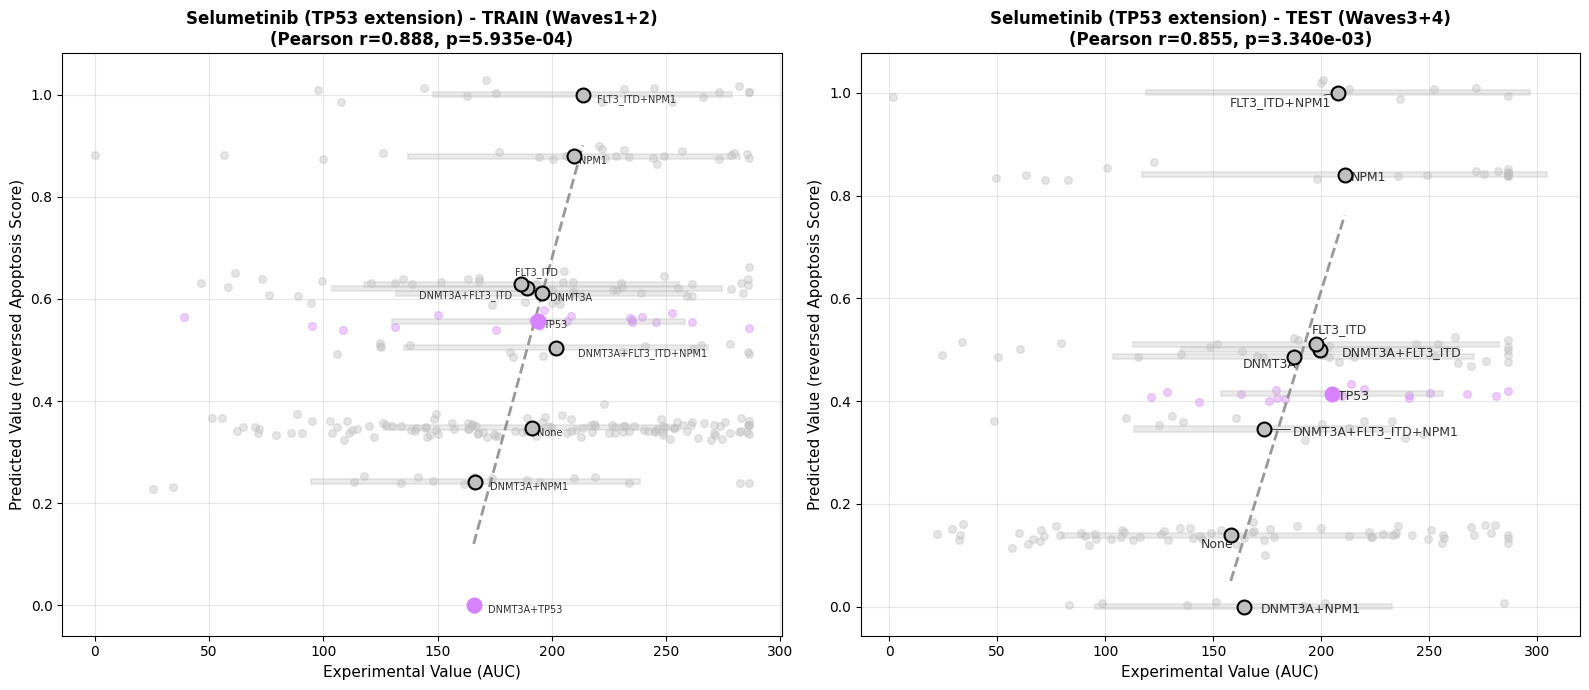

TRAIN: Matched 259 individual samples to predictions
TEST: Matched 181 individual samples to predictions
Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Midostaurin_TP53_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png


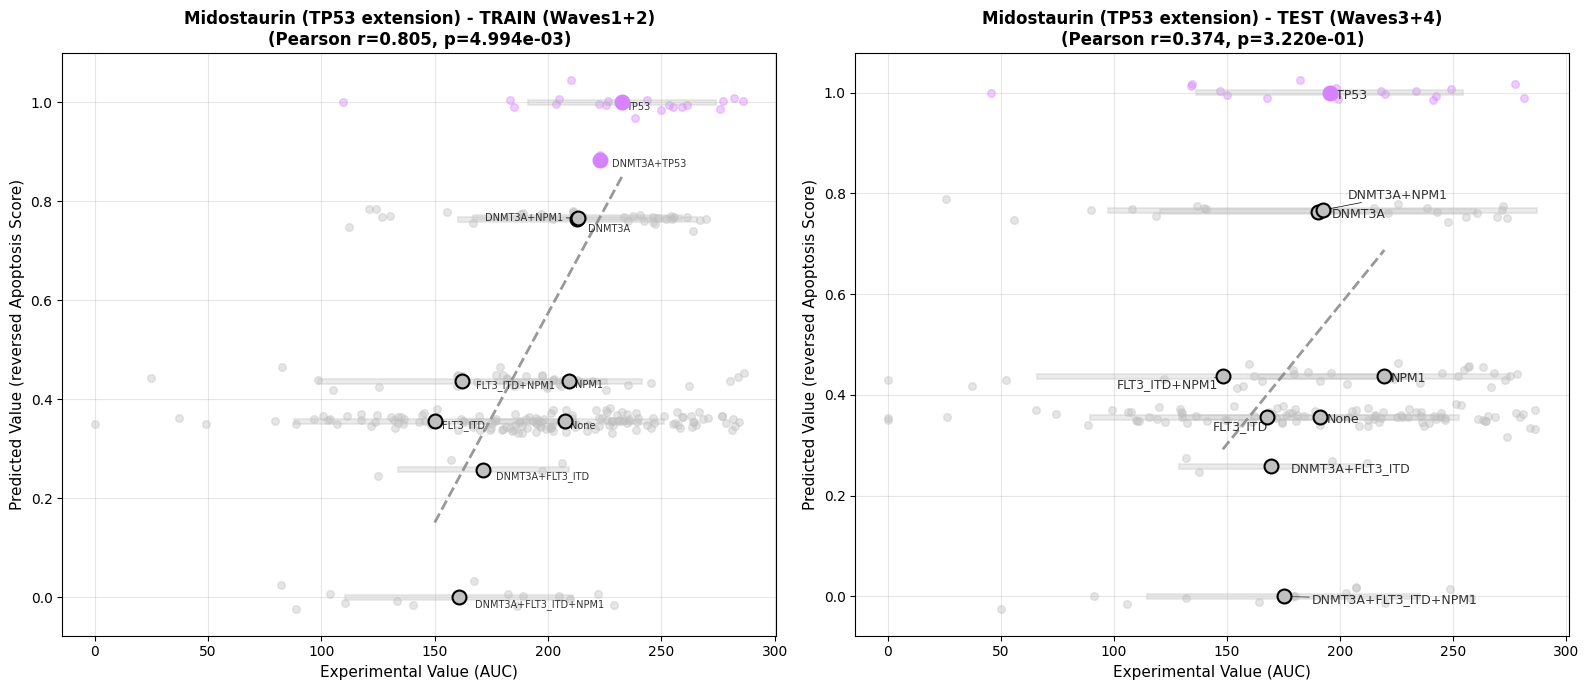

In [464]:
extended_gene = 'TP53'
for drug in drugs:
    expanded_plot_beataml(
        drug=drug, 
        df=df, 
        drug2target=drug2target, 
        text_size=9,
        extended_gene=extended_gene,
        use_spearman=False,
        save_path=f'/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_{drug}_{extended_gene}_Waves1+2_AND+OR+IW/prediction_vs_experimental_individual.png'
    )

## RUNX1

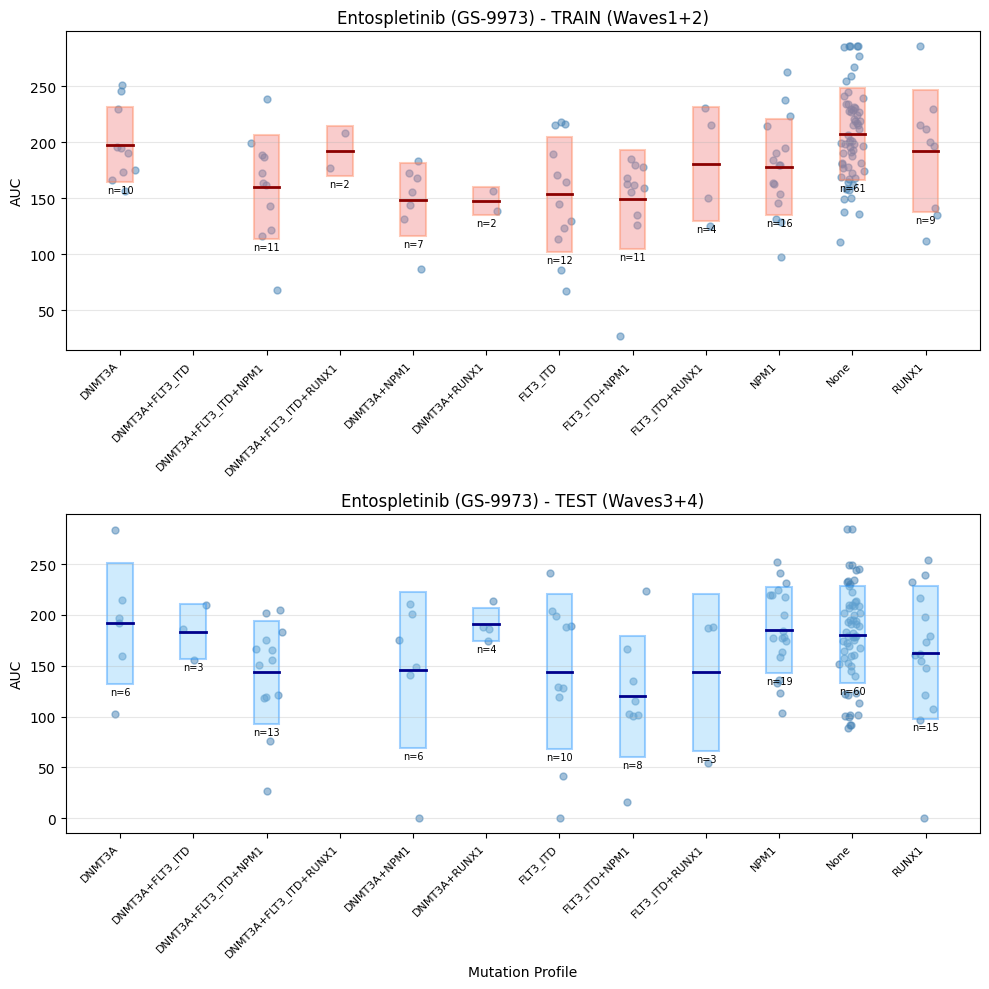

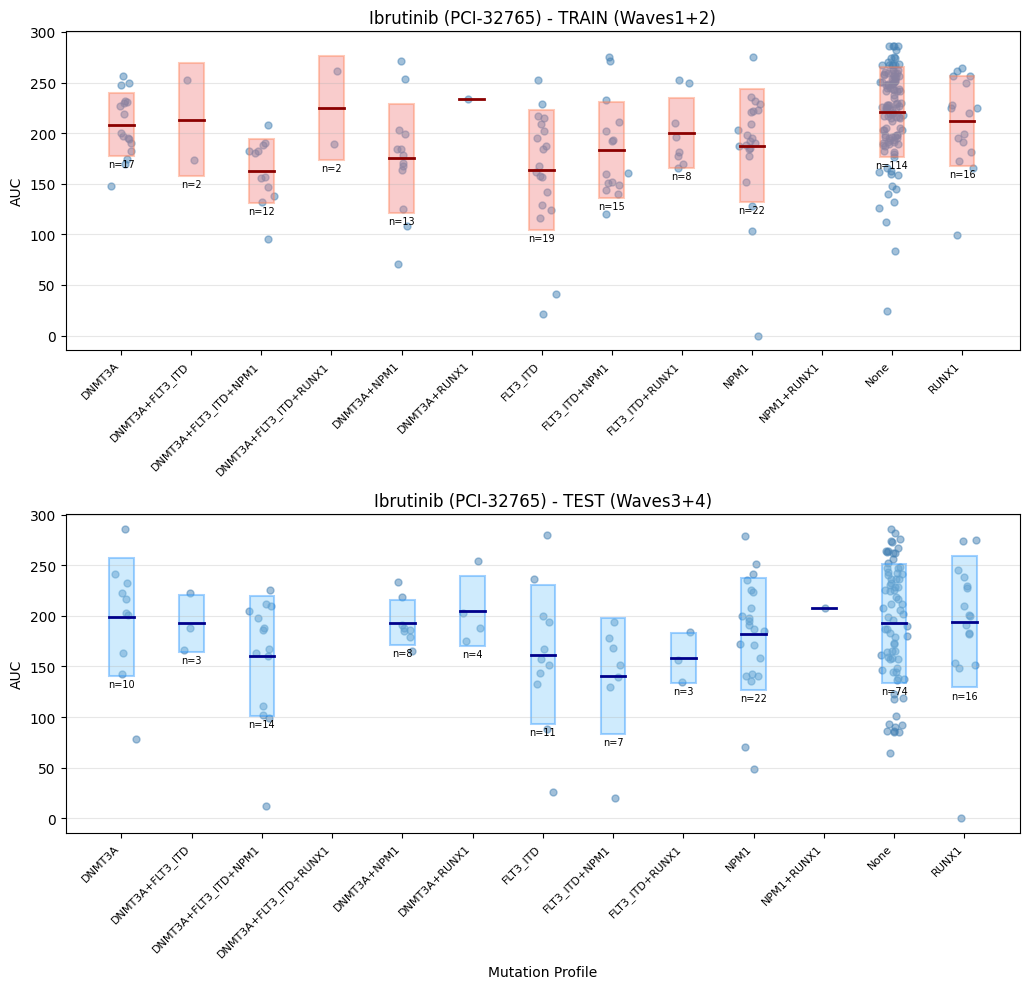

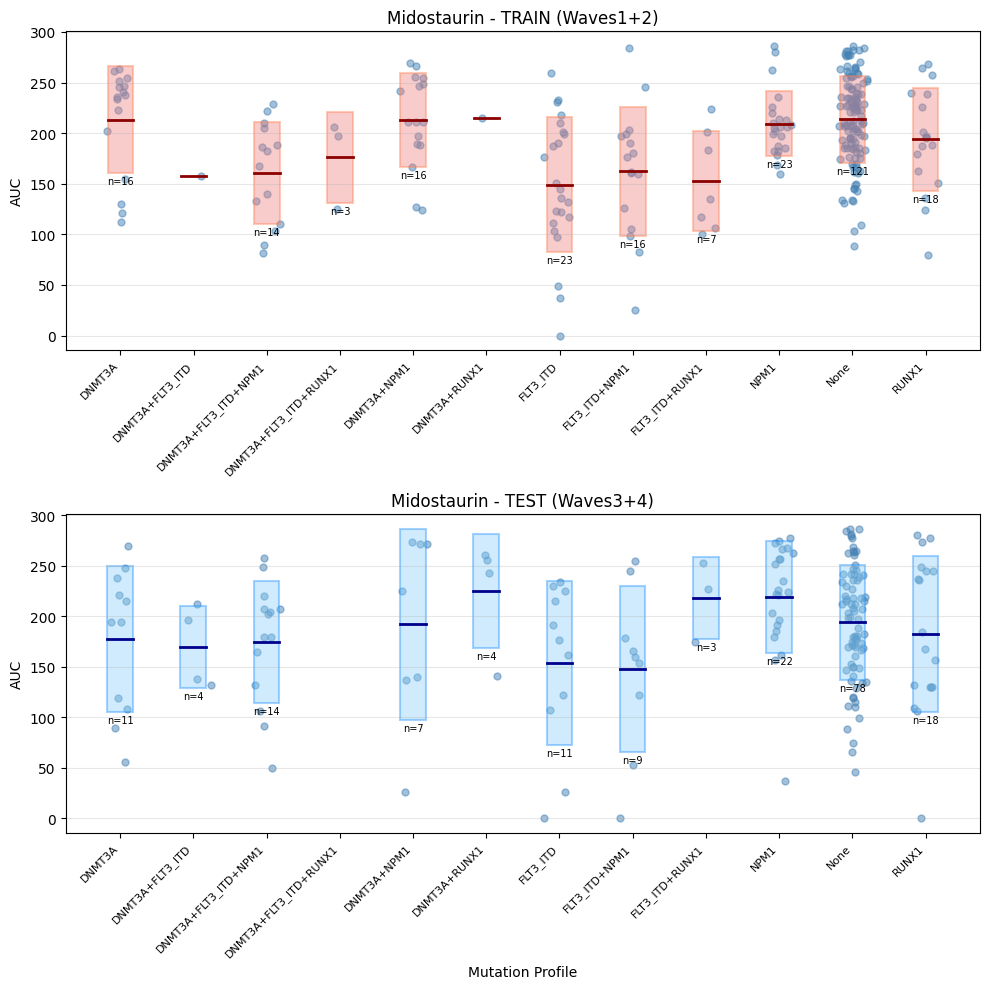

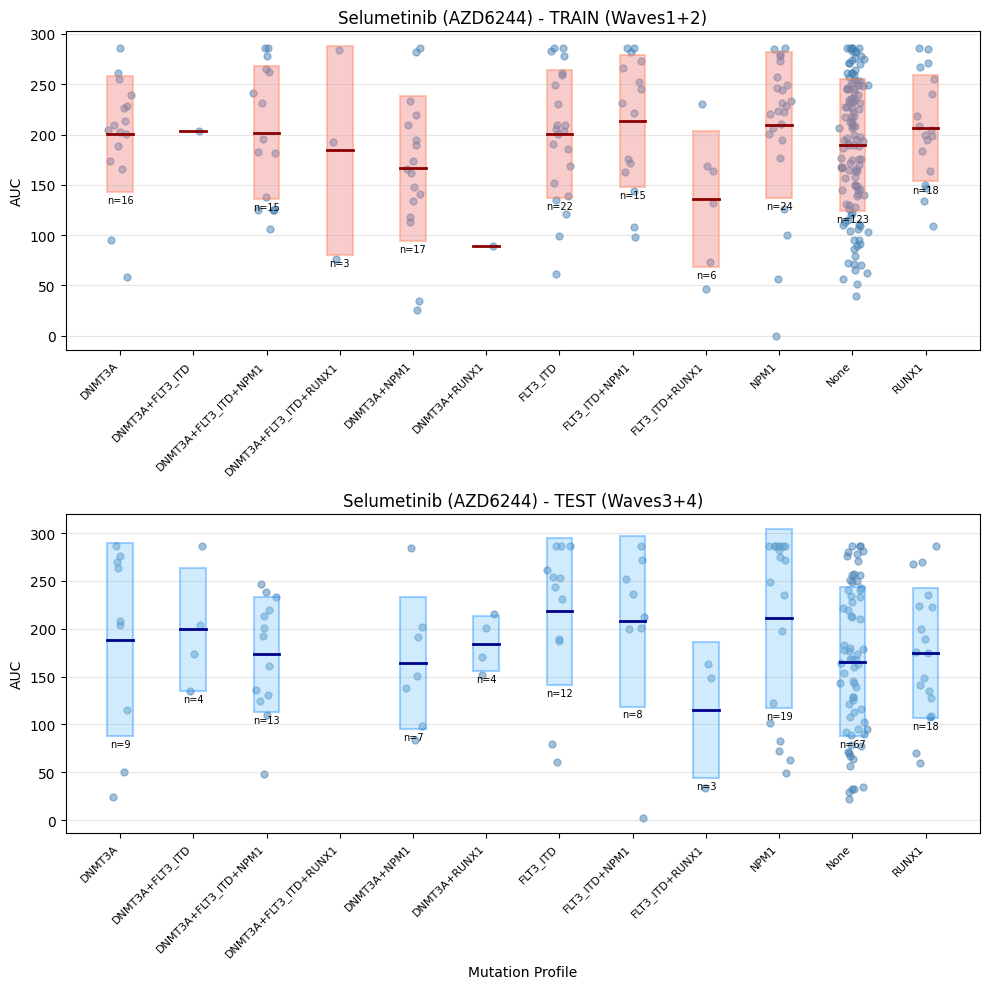

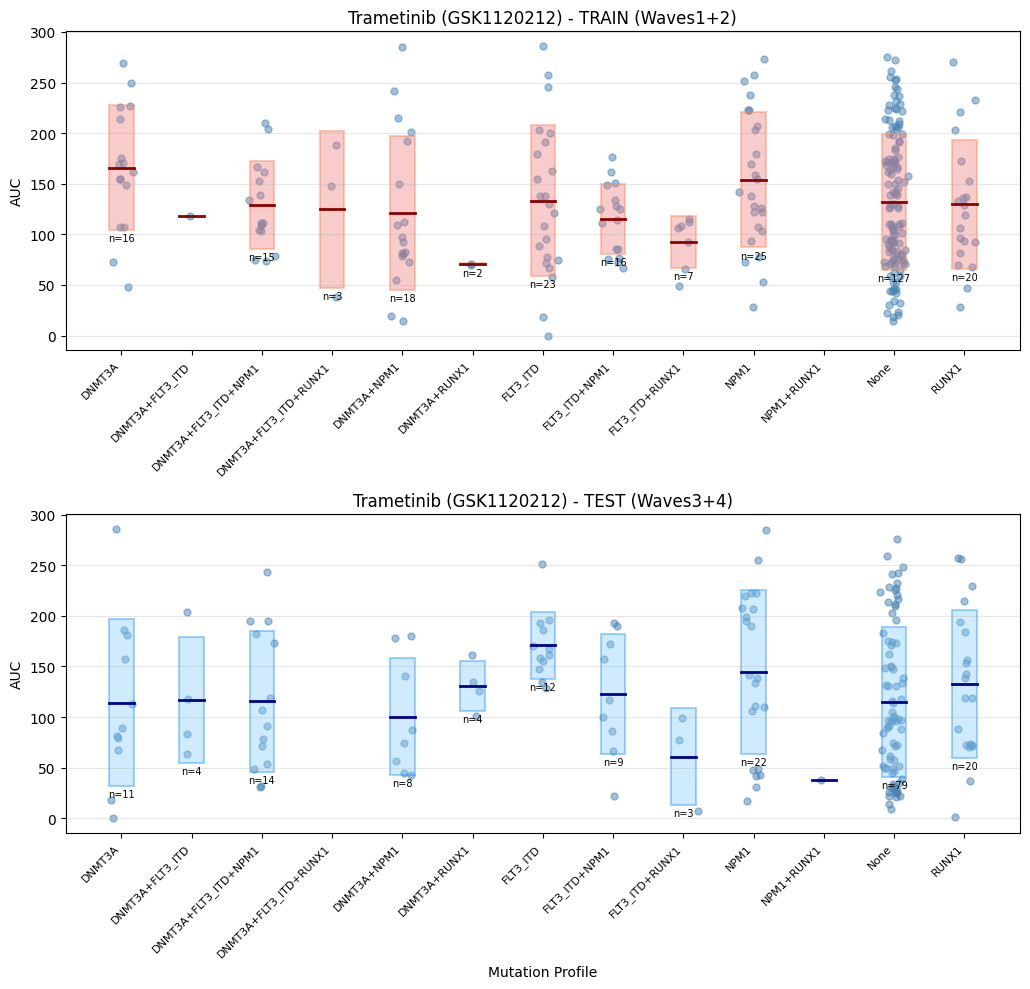

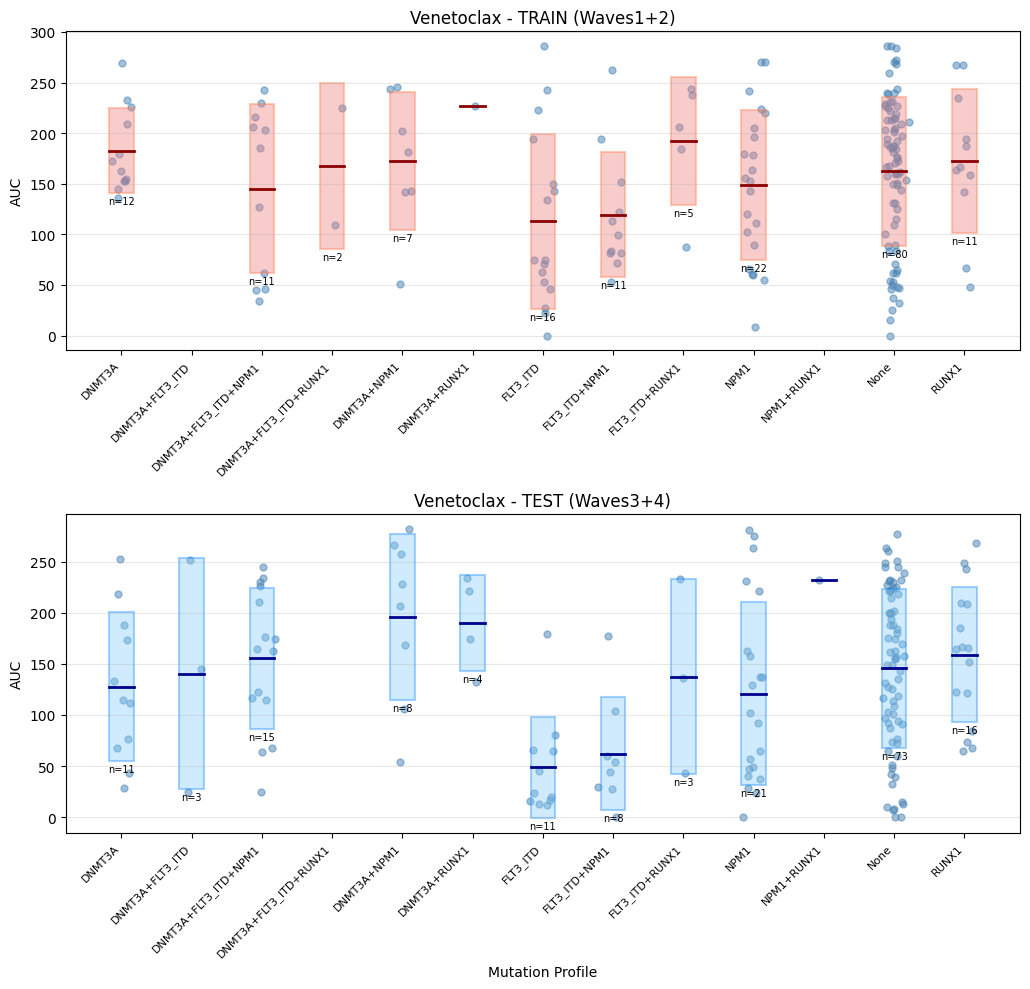

In [367]:
# Create dataset with drug response and mutations
sample_mutations = {}
for ptid in mutation_matrix.index:
    mutated_genes = mutation_matrix.loc[ptid][mutation_matrix.loc[ptid] == 1].index.tolist()
    # Filter to only model genes
    # mutated_genes_in_model = [g for g in mutated_genes if g in pbn.nodeDict.keys()]
    mutated_genes_in_model = [g for g in mutated_genes if g in ['FLT3_ITD', 'NPM1', 'DNMT3A', 'RUNX1']]
    sample_mutations[ptid] = set(mutated_genes_in_model)

# Create mutation profile mapping
mutation_profiles = []
for _, row in sample_to_ptid.iterrows():
    ptid = row['ptid']
    if ptid in sample_mutations:
        mutation_profiles.append({
            'dbgap_sample_id': row['dbgap_sample_id'],
            'ptid': ptid,
            'mutation_profile': sample_mutations[ptid]
        })

mutation_profile_df = pd.DataFrame(mutation_profiles)

# Merge with drug response data
drug_response_merged = pd.merge(
    mutation_profile_df,
    drug_response,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample',
    how='inner'
)

# Filter for selected drugs of interest
df = drug_response_merged[drug_response_merged['inhibitor'].apply(lambda x: any(drug in x for drug in drugs))].copy()

# Merge cohort information
df = pd.merge(df, sample_to_ptid[['dbgap_sample_id', 'cohort']], on='dbgap_sample_id', how='left')

# AUC by mutation profile with mean ± s.d. boxes (Train vs Test)
AUC_by_mutation_profile(df)

In [368]:
classification = pd.read_csv("../input_files/Palma_class_extended.csv")
gene_to_class = dict(zip(classification['symbol'], classification['class']))

for drug in drugs:
    exp_data = create_experimental_data(
        df, 
        cohort='Waves1+2',
        mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A', 'RUNX1'],
        inhibitors=[drug],
        gene_to_class=gene_to_class,
        output_file=f'../data/BeatAML_AUC_{drug}_RUNX1_Waves1+2.csv'
    )
    exp_data = create_experimental_data(
        df, 
        cohort='Waves3+4',
        mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A', 'RUNX1'],
        inhibitors=[drug],
        gene_to_class=gene_to_class,
        output_file=f'../data/BeatAML_AUC_{drug}_RUNX1_Waves3+4.csv'
    )

\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 11 experiments to ../data/BeatAML_AUC_Venetoclax_RUNX1_Waves1+2.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             178  163.90±32.35
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 12 experiments to ../data/BeatAML_AUC_Venetoclax_RUNX1_Waves3+4.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             174  142.98±51.84
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 11 experiments to ../data/BeatAML_AUC_Entospletinib_RUNX1_Waves1+2.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             145  173.47±22.37
\nGenerating data for 16 profiles × 1 drugs = 16 experiments
\nSaved 11 experiments to ../data/BeatAML_AUC_Entospletinib_RUNX1_Waves3+4.csv
\nSummary b

# FPMTB data
https://zenodo.org/records/7370747

In [516]:
df_mutation = pd.read_excel('/Users/luna/Desktop/Pancreatic cancer/Data/AML_FPMTB/Functional_Precision_Medicine_Tumor_Board_AML/File_6_Binary_mutation_225S_57G.xlsx',index_col=0)
df_dss = pd.read_excel('/Users/luna/Desktop/Pancreatic cancer/Data/AML_FPMTB/Functional_Precision_Medicine_Tumor_Board_AML/File_3.1_Drug_response_sDSS_164S_17Healthy.xlsx',index_col=0)
df_dss.set_index('Drug_name',inplace=True)

In [234]:
gene_of_interest = ['FLT3','NPM1','DNMT3A']

# Filter mutations to genes of interest
genes_to_use = df_mutation.index.intersection(gene_of_interest)
df_mut_filt = df_mutation.loc[genes_to_use]

# Build mutation_profile per sample (set of mutated genes)
mutation_profile = df_mut_filt.apply(
    lambda col: {gene for gene, val in col.items() if val == 1},
    axis=0
)

# Filter DSS to selected drugs
drugs_to_use = df_dss.index.intersection(drugs)
df_dss_filt = df_dss.loc[drugs_to_use]

# Long-format DSS: one row per (sample, drug)
df_long = (
    df_dss_filt
    .reset_index()    
    .rename(columns={'index': 'drug'})
    .melt(id_vars='Drug_name',
          var_name='sample_id',
          value_name='DSS')
)

# drop missing DSS values
df_long = df_long.dropna(subset=['DSS'])

# Add mutation_profile column
df_long['mutation_profile'] = df_long['sample_id'].map(mutation_profile)
df_long = df_long.dropna(subset=['mutation_profile'])
df_long

Drug_name   sample_id    DSS mutation_profile
0      Selumetinib  AML_084_04  15.46               {}
1       Trametinib  AML_084_04  16.54               {}
2      Midostaurin  AML_084_04  -0.96               {}
3        Ibrutinib  AML_084_04   0.00               {}
4       Venetoclax  AML_084_04  -2.14               {}
..             ...         ...    ...              ...
979     Trametinib  AML_183_02  10.03               {}
980    Midostaurin  AML_183_02   9.23               {}
981      Ibrutinib  AML_183_02   0.00               {}
982     Venetoclax  AML_183_02   1.10               {}
983  Entospletinib  AML_183_02   0.50               {}

[743 rows x 4 columns]

In [89]:
df_long['mutation_profile'].value_counts()

mutation_profile
{}                      513
{DNMT3A}                 64
{NPM1}                   49
{DNMT3A, NPM1}           33
{FLT3}                   30
{FLT3, DNMT3A}           21
{FLT3, NPM1}             18
{FLT3, DNMT3A, NPM1}     15
Name: count, dtype: int64

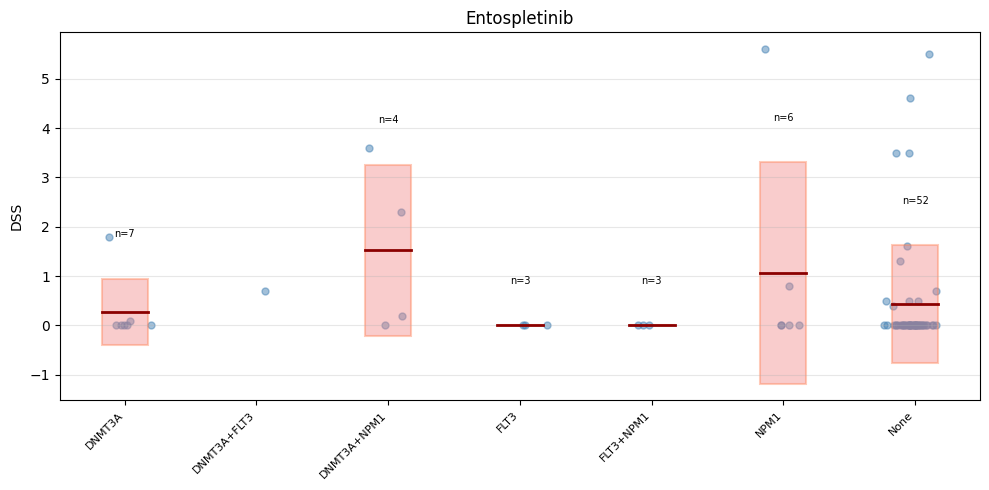

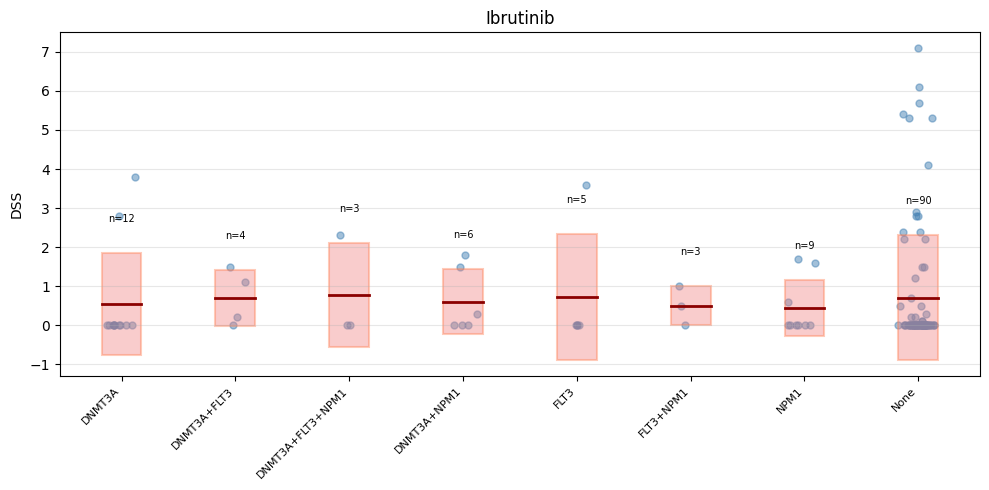

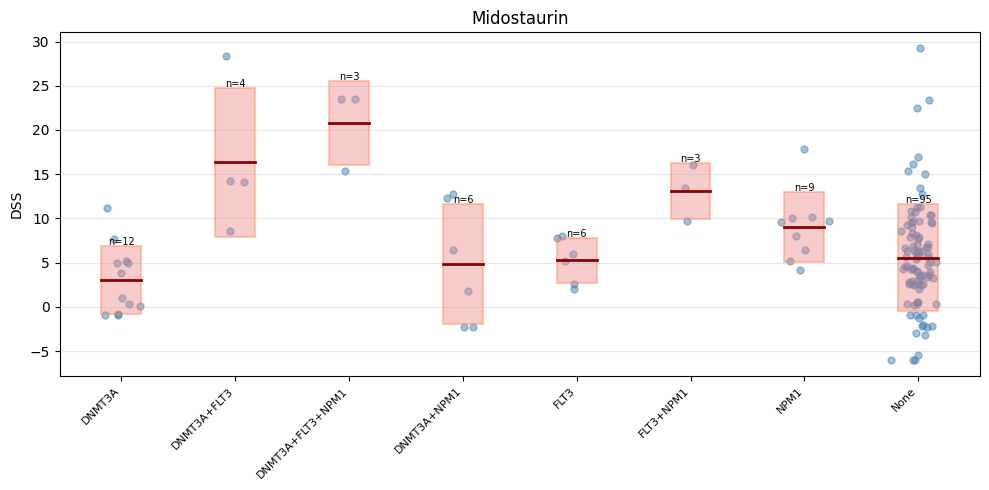

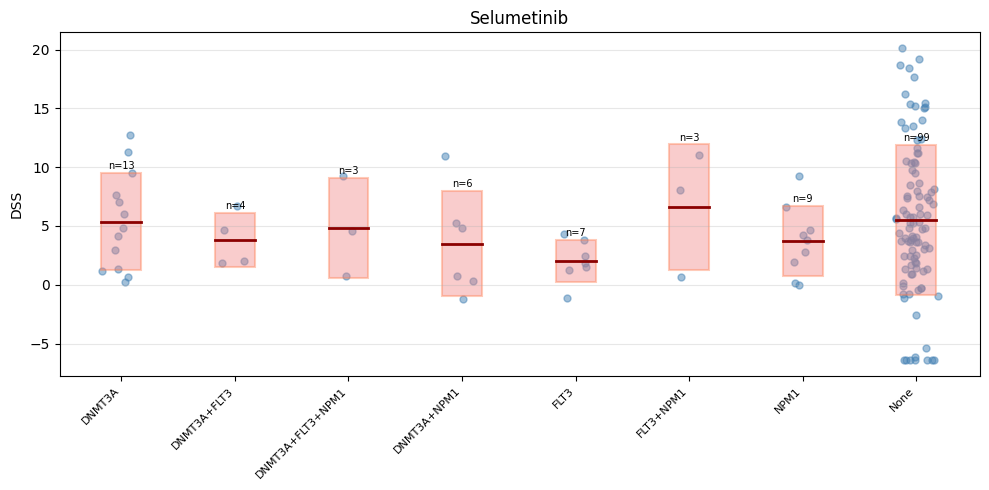

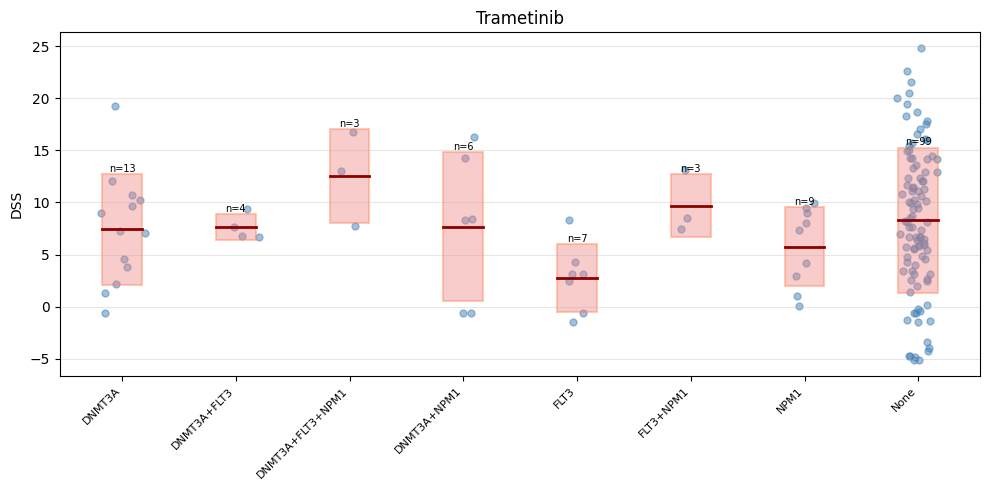

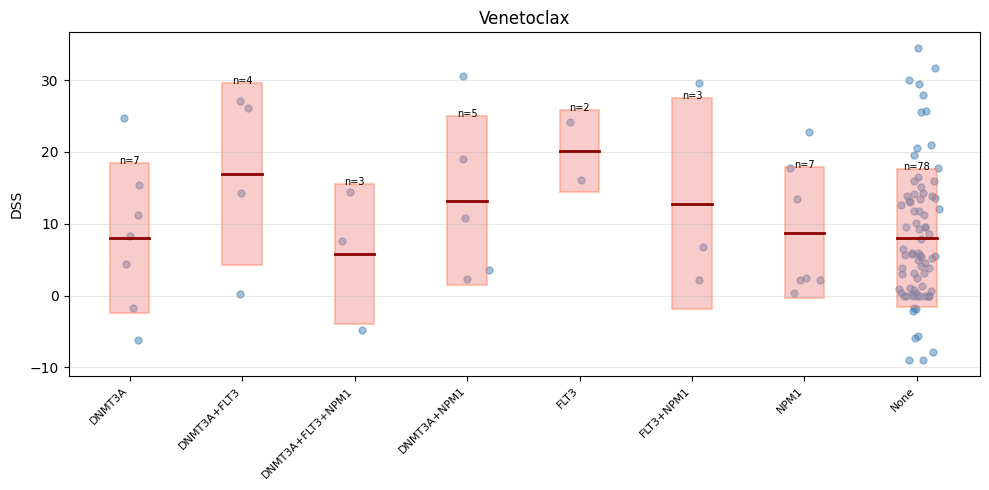

In [99]:
# DSS by mutation profile with mean ± s.d. boxes
def normalize_profile_text(p):
    if isinstance(p, (set, frozenset, list, tuple)):
        genes = sorted(map(str, p))
    else:
        s = re.sub(r'[\{\}]', '', str(p))
        genes = sorted([g.strip() for g in s.split(',') if g.strip()])
    return "+".join(genes) if genes else "None"

df_plot = df_long.copy()
df_plot["profile_label"] = df_plot["mutation_profile"].apply(normalize_profile_text)

# Create plots for each drug
for drug in sorted(df_plot["Drug_name"].unique()):
    sub = df_plot[df_plot["Drug_name"] == drug].copy()

    # Get profile statistics
    stats = sub.groupby("profile_label")['DSS'].agg(['mean', 'std', 'count']).reset_index()
    
    # Get union of profiles
    all_profiles = sorted(set(stats['profile_label'].tolist()))
    
    if len(all_profiles) == 0:
        continue
    
    # create figure
    fig, ax1 = plt.subplots(figsize=(max(10, len(all_profiles) * 0.8), 5))
    positions = range(len(all_profiles))

    # Create a stats lookup dict for each profile
    stats_by_profile = {row['profile_label']: row for _, row in stats.iterrows()}
    
    for i, profile in enumerate(all_profiles):
        profile_data = sub[sub['profile_label'] == profile]
        if len(profile_data) > 0:
            x_jitter = np.random.normal(i, 0.08, len(profile_data))
            ax1.scatter(x_jitter, profile_data['DSS'], alpha=0.5, s=25, color='steelblue')

        # Plot mean ± sd box for every profile
        row = stats_by_profile.get(profile)
        if row is not None and not pd.isnull(row['mean']) and not pd.isnull(row['std']):
            mean_val = row['mean']
            std_val = row['std']
            count = row['count']
            
            box_width = 0.35
            # Use facecolor and edgecolor separately to avoid warning
            ax1.add_patch(plt.Rectangle((i - box_width/2, mean_val - std_val), 
                                        box_width, 2*std_val, 
                                        facecolor='lightcoral', alpha=0.4, 
                                        linewidth=1.5, edgecolor='coral'))
            
            ax1.plot([i - box_width/2, i + box_width/2], [mean_val, mean_val], 
                    color='darkred', linewidth=2, zorder=10)
            
            ax1.text(i, mean_val + std_val+1, f'n={int(count)}', 
                    ha='center', va='top', fontsize=7)
    
    ax1.set_xticks(positions)
    ax1.set_xticklabels(all_profiles, rotation=45, ha='right', fontsize=8)
    ax1.set_ylabel('DSS')
    ax1.set_title(f'{drug}')
    ax1.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [92]:
sub.groupby("profile_label")['DSS'].agg(['mean', 'std', 'count']).reset_index()

profile_label       mean        std  count
0            DNMT3A   8.000000  10.435432      7
1       DNMT3A+FLT3  16.922500  12.604868      4
2  DNMT3A+FLT3+NPM1   5.760000   9.725739      3
3       DNMT3A+NPM1  13.228000  11.765053      5
4              FLT3  20.135000   5.706352      2
5         FLT3+NPM1  12.800000  14.729902      3
6              NPM1   8.734286   9.113448      7
7              None   8.038974   9.608254     78

In [235]:
def create_FPMTB(df, gene_of_interest,
                    inhibitors=['Venetoclax'],
                    drug2target=None,
                    min_patients=3,
                    output_file='beataml_experiments.csv'):
    """
    Create experimental data CSV from FPMTB drug response data.
    
    Parameters:
    - df: DataFrame with mutation_profile, Drug_name, and DSS columns
    - gene_of_interest: List of genes
    - inhibitors: List of drug names
    - min_patients: Minimum number of patients per profile
    - output_file: Output CSV filename
    
    Note: Oncogenes become Stimuli, TSGs become Inhibitors based on gene_to_class
    """
    
    # Drug to target mapping
    if drug2target is None:
        drug2target = {
            'Venetoclax': ['BCL2'],
            'Ibrutinib': ['BTK'], 
            'Entospletinib': ['SYK'],
            }
    
    # Normalize profile text for comparison
    def normalize_profile_text(p):
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else: 
            s = re.sub(r'[\\{\\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return set(genes) if genes else set()
    
    df_work = df.copy()
    df_work['profile_set'] = df_work['mutation_profile'].apply(normalize_profile_text)
   
    # Generate all mutation profile combinations
    from itertools import combinations
    all_profiles = []
    for r in range(len(gene_of_interest) + 1):
        for combo in combinations(gene_of_interest, r):
            all_profiles.append(set(combo))
    
    print(f"\nGenerating data for {len(all_profiles)} profiles × {len(inhibitors)} drugs = {len(all_profiles) * len(inhibitors)} experiments")
    
    # Create experiment rows
    experiments = []
    exp_id = 1
    
    for profile in all_profiles:
        for drug in inhibitors:
            # Filter data for this profile and drug
            matching_data = df_work[
                (df_work['profile_set'] == profile) & 
                (df_work['Drug_name'] == drug)
            ]
            
            if len(matching_data) == 0:
                continue
            
            # Calculate average AUC
            avg_dss = matching_data['DSS'].mean()
            std_dss = matching_data['DSS'].std()
            n_patients = len(matching_data)
            if n_patients < min_patients:
                print(f"Not enough patients for {drug} {profile}, skipping...")
                continue
            
            # Classify genes as oncogenes or TSGs
            oncogenes = []
            tsgs = []
            
            for gene in profile:
                gene_class = gene_to_class.get(gene, 'unknown')
                if gene_class == 'oncogene':
                    oncogenes.append(gene)
                elif gene_class == 'TSG':
                    tsgs.append(gene)
                else:
                    print(f"Warning: Unknown classification for {gene}, treating as oncogene")
                    oncogenes.append(gene)
            
            # Oncogenes → Stimuli (activate)
            stimuli = ','.join(sorted(oncogenes)) if oncogenes else ''
            stimuli_efficacy = ','.join(['1'] * len(oncogenes)) if oncogenes else ''
            
            # TSGs + Drug target → Inhibitors (knockdown)
            target = drug2target.get(drug, '')
            if not target:
                print(f"Warning: No target mapping for {drug}, skipping...")
                continue
            
            all_inhibitors = sorted(tsgs + target)
            inhibitors_str = ','.join(all_inhibitors)
            inhibitors_efficacy = ','.join(['1'] * len(all_inhibitors))
            
            measured_nodes = 'DSS'
            measured_values = f'{avg_dss:.2f}'
            
            experiments.append({
                'Experiments': exp_id,
                'Stimuli': stimuli,
                'Stimuli_efficacy': stimuli_efficacy,
                'Inhibitors': inhibitors_str,
                'Inhibitors_efficacy': inhibitors_efficacy,
                'Measured_nodes': measured_nodes,
                'Measured_values': measured_values,
                'n_patients': n_patients,
                'std': f'{std_dss:.2f}',
                'drug': drug
            })
            
            exp_id += 1
    
    # Create DataFrame
    exp_df = pd.DataFrame(experiments)
    
    # Save to CSV
    exp_df.to_csv(output_file, index=False)
    
    print(f"\nSaved {len(exp_df)} experiments to {output_file}")
    print(f"\nSummary by drug:")
    print(exp_df.groupby('drug').agg({
        'n_patients': 'sum',
        'Measured_values': lambda x: f"{pd.to_numeric(x).mean():.2f}±{pd.to_numeric(x).std():.2f}"
    }).rename(columns={'Measured_values': 'Mean DSS±SD', 'n_patients': 'Total patients'}))
    
    return exp_df 

In [276]:
def expanded_plot(data_df, df_long, eval_result, drug2target, use_spearman=False, save_path=None):
    # Expanded plot: show individual samples instead of aggregated experiments
    import numpy as np
    from scipy import stats
    from scipy.stats import spearmanr
    from adjustText import adjust_text

    def normalize_profile_text(p):
        """Normalize mutation profile to consistent text format"""
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\{\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return "+".join(genes) if genes else "None"

    # Get predicted values from eval_result
    sim_results = eval_result['simulation_results']
    exp_ids = sim_results['experiment_ids']

    # Min-max normalize predicted values to 0-1
    def minmax_normalize(values):
        arr = np.array(values)
        min_val = np.min(arr)
        max_val = np.max(arr)
        if max_val - min_val == 0:
            return np.zeros_like(arr, dtype=float)
        return (arr - min_val) / (max_val - min_val)
    predicted_values = minmax_normalize(sim_results['predicted_values'])

    # Create mapping: experiment_id -> predicted_value
    exp_to_pred = dict(zip(exp_ids, predicted_values))

    # Also get the profile_label and drug for each experiment from data_df
    all_drug_targets = set()
    for targets in drug2target.values():
        all_drug_targets.update(targets)

    def get_profile_label_from_row(row):
        """Extract mutation profile from Stimuli and Inhibitors columns"""
        mutated_genes = set()
        stimuli = str(row.get('Stimuli', ''))
        if stimuli and stimuli != 'nan':
            for gene in stimuli.split(','):
                gene = gene.strip()
                if gene:
                    mutated_genes.add(gene)
        inhibitors = str(row.get('Inhibitors', ''))
        if inhibitors and inhibitors != 'nan':
            for gene in inhibitors.split(','):
                gene = gene.strip()
                if gene and gene not in all_drug_targets:
                    mutated_genes.add(gene)
        if mutated_genes:
            return '+'.join(sorted(mutated_genes))
        return 'None'

    data_df['profile_label'] = data_df.apply(get_profile_label_from_row, axis=1)
    data_df['predicted'] = data_df['Experiments'].map(exp_to_pred)

    # Create mapping: (profile_label, drug) -> predicted_value
    profile_drug_to_pred = {}
    for _, row in data_df.iterrows():
        key = (row['profile_label'], row['drug'])
        profile_drug_to_pred[key] = row['predicted']

    # Map individual samples in df_long to predicted values
    df_samples = df_long.copy()
    df_samples['profile_label'] = df_samples['mutation_profile'].apply(normalize_profile_text)
    df_samples['profile_drug'] = list(zip(df_samples['profile_label'], df_samples['Drug_name']))
    df_samples['predicted'] = df_samples['profile_drug'].map(profile_drug_to_pred)
    df_samples = df_samples.dropna(subset=['predicted', 'DSS'])

    print(f"Matched {len(df_samples)} individual samples to predictions")

    # Create the expanded plot
    fig, ax = plt.subplots(figsize=(8, 7))

    # Define colors for each drug
    drug_colors = {
        'Venetoclax': '#D2B55B',   # Yellow
        'Ibrutinib': '#377EB8',    # Blue
        'Entospletinib': '#4DAF4A', # Green
        # 'Trametinib': '#984EA3',   # Purple
        # 'Selumetinib': '#FF7F00',  # Orange
        # 'Midostaurin': '#FFFF33',  # Yellow
    }

    # Plot individual samples with jitter on y-axis
    np.random.seed(42) 
    for _, row in df_samples.iterrows():
        y_jitter = row['predicted'] + np.random.normal(0, 0.015)
        color = drug_colors.get(row['Drug_name'], 'gray')
        ax.scatter(row['DSS'], y_jitter, alpha=0.4, s=30, color=color)

    # Calculate and plot mean ± s.d. for each profile-drug combination
    profile_drug_means = df_samples.groupby(['profile_label', 'Drug_name']).agg({
        'DSS': ['mean', 'std', 'count'],
        'predicted': 'first'
    }).reset_index()
    profile_drug_means.columns = ['profile_label', 'Drug_name', 'DSS_mean', 'DSS_std', 'count', 'predicted']

    # Correlation on means (Spearman or Pearson based on option)
    if use_spearman:
        r, p_value = spearmanr(profile_drug_means['DSS_mean'], profile_drug_means['predicted'])
        corr_label = 'Spearman'
    else:
        r, p_value = stats.pearsonr(profile_drug_means['DSS_mean'], profile_drug_means['predicted'])
        corr_label = 'Pearson'

    box_height = 0.01
    texts = []
    for _, row in profile_drug_means.iterrows():
        # print(f"drug: {row['Drug_name']}, profile: {row['profile_label']}, n: {row['count']}")
        mean_val = row['DSS_mean']
        std_val = row['DSS_std'] if pd.notna(row['DSS_std']) else 0
        pred = row['predicted']
        color = drug_colors.get(row['Drug_name'], 'gray')
        
        # Horizontal patch for mean ± s.d. in DSS (like in pred_vs_exp)
        ax.add_patch(plt.Rectangle((mean_val - std_val, pred - box_height/2), 
                                    2*std_val, box_height, 
                                    facecolor=color, alpha=0.3, 
                                    linewidth=1.5, edgecolor=color))
        # Vertical line at mean
        ax.plot([mean_val, mean_val], [pred - box_height/2, pred + box_height/2], 
                color='darkred', linewidth=2, zorder=10)
        
        # Mean marker
        ax.scatter(mean_val, pred, s=100, color=color, edgecolor='black', linewidth=1.5, zorder=15)
        
        # Collect text annotations for adjustText
        txt = ax.text(mean_val, pred, f'{row["profile_label"]} (n={int(row["count"])})      ', 
                     fontsize=7, alpha=0.8, ha='right', va='top')
        texts.append(txt)
    
    # Adjust text positions to avoid overlap
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    # Regression line
    slope, intercept, _, _, _ = stats.linregress(df_samples['DSS'], df_samples['predicted'])
    x_reg = np.linspace(df_samples['DSS'].min(), df_samples['DSS'].max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, 'k--', linewidth=1.5, alpha=0.6, label='Regression line')

    # Legend for drugs
    legend_handles = [plt.scatter([], [], c=color, s=60, label=drug) 
                    for drug, color in drug_colors.items()]
    ax.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(0.98, 1), fontsize=9)

    ax.set_xlabel('Experimental Value (DSS)', fontsize=11)
    ax.set_ylabel('Predicted Value (Apoptosis Score)', fontsize=11)
    ax.set_title(f'{drug} - TEST (FPMTB)\n({corr_label} r={r:.3f}, p={p_value:.3e})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: {save_path}")

In [128]:
create_FPMTB(df_long, gene_of_interest = gene_of_interest,
                            inhibitors=['Ibrutinib','Entospletinib','Venetoclax'],
                            drug2target=drug2target,
                            min_patients=5,
                            output_file='../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv')


Generating data for 8 profiles × 3 drugs = 24 experiments
Not enough patients for Entospletinib {'FLT3'}, skipping...
Not enough patients for Venetoclax {'FLT3'}, skipping...
Not enough patients for Ibrutinib {'NPM1', 'FLT3'}, skipping...
Not enough patients for Entospletinib {'NPM1', 'FLT3'}, skipping...
Not enough patients for Venetoclax {'NPM1', 'FLT3'}, skipping...
Not enough patients for Ibrutinib {'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Entospletinib {'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Venetoclax {'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Entospletinib {'NPM1', 'DNMT3A'}, skipping...
Not enough patients for Ibrutinib {'NPM1', 'DNMT3A', 'FLT3'}, skipping...
Not enough patients for Venetoclax {'NPM1', 'DNMT3A', 'FLT3'}, skipping...

Saved 12 experiments to ../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv

Summary by drug:
               Total patients Mean DSS±SD
drug                                     
Entospletinib              65   0.59±0

Experiments Stimuli Stimuli_efficacy        Inhibitors  \
0             1                                        BTK   
1             2                                        SYK   
2             3                                       BCL2   
3             4    FLT3                1               BTK   
4             5                                   BTK,NPM1   
5             6                                   NPM1,SYK   
6             7                                  BCL2,NPM1   
7             8                                 BTK,DNMT3A   
8             9                                 DNMT3A,SYK   
9            10                                BCL2,DNMT3A   
10           11                            BTK,DNMT3A,NPM1   
11           12                           BCL2,DNMT3A,NPM1   

   Inhibitors_efficacy Measured_nodes Measured_values  n_patients    std  \
0                    1            DSS            0.71          90   1.61   
1                    1            DSS            0.43          52   1.19   
2                    1            DSS            8.04          78   9.61   
3                    1            DSS            0.72           5   1.61   
4                  1,1            DSS            0.43           9   0.72   
5                  1,1            DSS            1.07           6   2.24   
6                  1,1            DSS            8.73           7   9.11   
7                  1,1            DSS            0.55          12   1.30   
8                  1,1            DSS            0.27           7   0.68   
9                  1,1            DSS            8.00           7  10.44   
10               1,1,1            DSS            0.60           6   0.83   
11               1,1,1            DSS           13.23           5  11.77   

             drug  
0       Ibrutinib  
1   Entospletinib  
2      Venetoclax  
3       Ibrutinib  
4       Ibrutinib  
5   Entospletinib  
6      Venetoclax  
7       Ibrutinib  
8   Entospletinib  
9      Venetoclax  
10      Ibrutinib  
11     Venetoclax

In [ ]:
pbn = KGBN.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/pbn.txt')
formula = KGBN.phenotype_scores(
    genes=pbn.nodeDict.keys(),
    simulation_results=None,
    phenotypes=['APOPTOSIS'],
    reversed=True
)
eval_result = KGBN.evaluate_pbn(pbn, '../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv', 
    config=config, 
    Measured_formula=formula['APOPTOSIS'],
    normalize=True,
    output_dir='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5')

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Path found for 1 phenotypes: ['APOPTOSIS']
Plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/prediction_vs_experimental.png
Residual plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/residual_analysis.png
Evaluation report saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/evaluation_report.txt
Results exported to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/detailed_results.csv
PBN saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/pbn.txt


Matched 284 individual samples to predictions


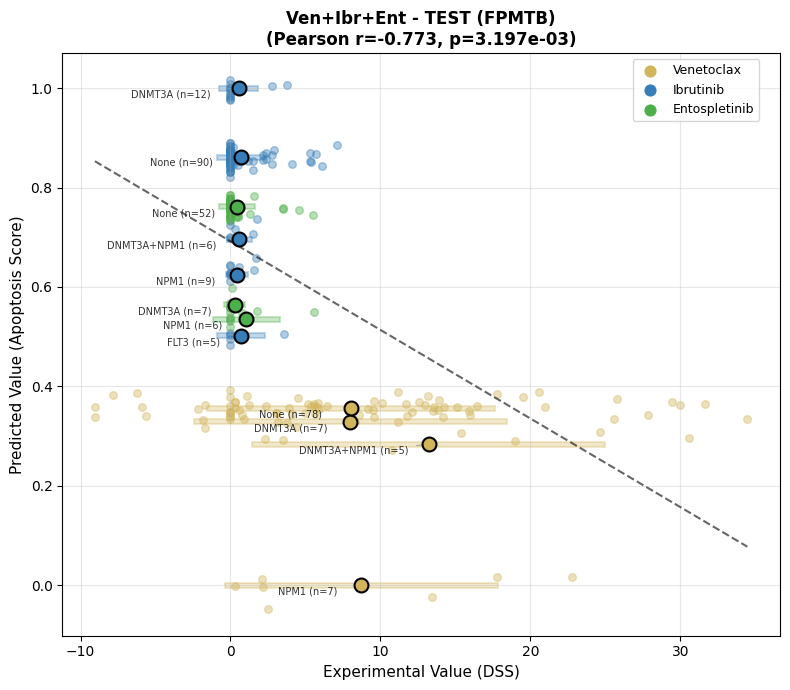

Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/prediction_vs_experimental_individual.png


In [279]:
data_df = pd.read_csv('../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv')
expanded_plot(data_df, df_long, eval_result, drug2target, use_spearman=False, save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5/prediction_vs_experimental_individual.png')

## Not reversed apoptosis score

In [ ]:
pbn = KGBN.load_pbn_from_file('/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/pbn.txt')
formula = KGBN.phenotype_scores(
    genes=pbn.nodeDict.keys(),
    simulation_results=None,
    phenotypes=['APOPTOSIS'],
    reversed=False
)
eval_result = KGBN.evaluate_pbn(pbn, '../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv', 
    config=config, 
    Measured_formula=formula['APOPTOSIS'],
    normalize=True,
    output_dir='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5_apoptosis_not_reversed')

No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
Path found for 1 phenotypes: ['APOPTOSIS']
Plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5_apoptosis_not_reversed/prediction_vs_experimental.png
Residual plot saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5_apoptosis_not_reversed/residual_analysis.png
Evaluation report saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5_apoptosis_not_reversed/evaluation_report.txt
Results exported to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5_apoptosis_not_reversed/detailed_results.csv
PBN saved to /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+I

Matched 284 individual samples to predictions


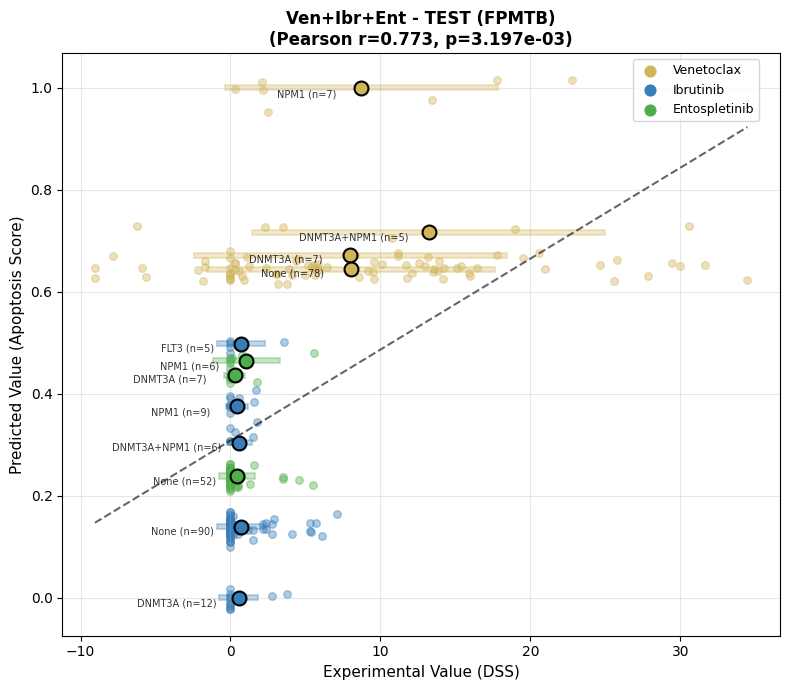

Saved: /Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5_apoptosis_not_reversed/prediction_vs_experimental_individual.png


In [288]:
data_df = pd.read_csv('../data/FPMTB_sDSS_Ven+Ibr+Ent_min5.csv')
expanded_plot(data_df, df_long, eval_result, drug2target, use_spearman=False, save_path='/Users/luna/Desktop/Pancreatic cancer/Results/AML/BeatAML_-AUC_Ven+Ibr+Ent_Waves1+2_AND+OR+IW/FPMTB_sDSS_Ven+Ibr+Ent_min5_apoptosis_not_reversed/prediction_vs_experimental_individual.png')